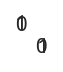

In [3]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt

# Load models together
from src.torch_utils import load_model_full
from src.multimodal_metrics import BSSVAELoss
from src.utils import get_class_initcode_keys
from src.multimodal_models import BSSVAE
from src.multimodal_train_eval import predict_multimodal, multimodal_train_eval_loops, train_multimodal_step, eval_multimodal_step
from src.multimodal_datasets import MultimodalPepTCRDataset, MultimodalCLFLatentDataset
from src.datasets import TwoStageTCRpMHCDataset, FullTCRDataset, LatentTCRpMHCDataset, TCRSpecificDataset
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
%load_ext autoreload
%autoreload 2
    
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180



def get_model(folder, **kwargs):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, **kwargs)
    return model
    

In [4]:
from src.data_processing import PEP_MAP, PEP_MAP2

df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')

# quick annealing checks

In [113]:

class AbstractParent():
    def __init__(self, arg_a):
        self.arg_a = arg_a
        self.max_len_tcr = 1

    def slice_x(self, x):
        print(x)
        print(self.max_len_tcr)

class ChildClass(AbstractParent):
    def __init__(self, max_len_tcr):
        super(ChildClass, self).__init__(arg_a='nothing')
        self.max_len_tcr = max_len_tcr

instance = ChildClass(max_len_tcr=12)
instance.slice_x(x='test')


test
12


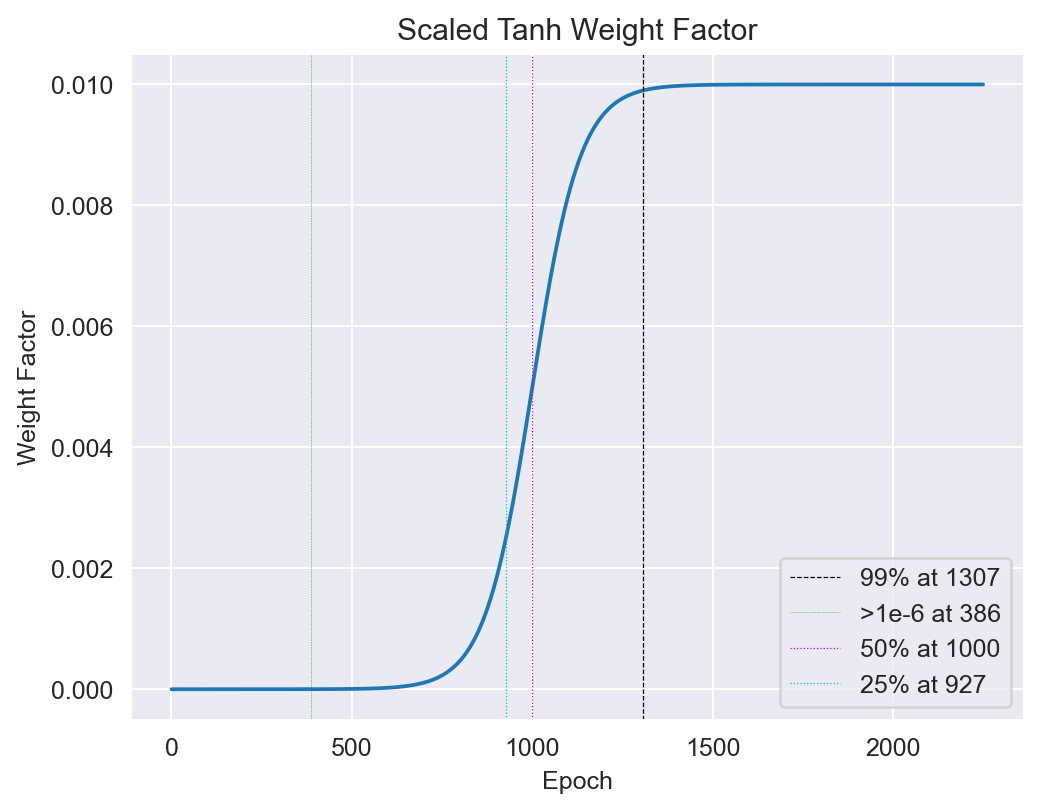

In [81]:
from src.utils import plot_tanh_annealing

plot_tanh_annealing(15000, 0.01, 0.0075, 1500)

In [83]:
n_epochs = 1500
for e in range(1, n_epochs+1):
    if (n_epochs >= 10 and e % math.ceil(0.1 * n_epochs) == 0) or e == 1 or e == n_epochs:
        print(e)


1
150
300
450
600
750
900
1050
1200
1350
1500


# BSSVAE with paired data

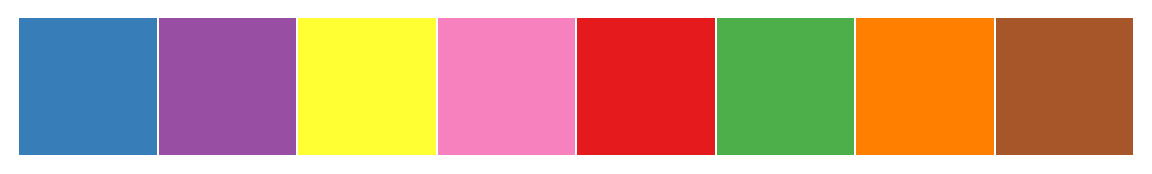

In [124]:
sns.palplot(get_palette('Set1', 8))

In [128]:
a = 1

c = 5
for b in range(10):
    print(b, a < b <= c)

0 False
1 False
2 True
3 True
4 True
5 True
6 False
7 False
8 False
9 False


tensor([0.0000e+00, 2.3779e-07, 2.4260e-07,  ..., 2.5000e-03, 2.5000e-03,
        2.5000e-03])


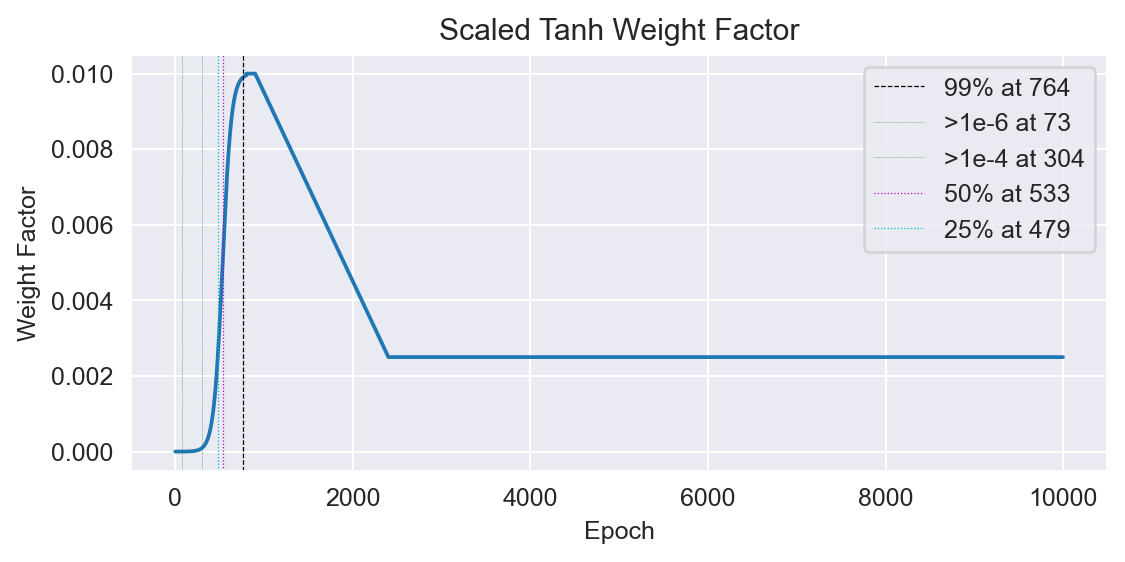

In [204]:
from src.multimodal_metrics import JMVAELoss, BSSVAELoss
from src.utils import plot_criterion_annealing
crit = BSSVAELoss(weight_kld_n = 1e-2, kld_warm_up = 800, kld_tanh_scale=0.01, flat_phase=100, kld_decrease=5e-4)
y = plot_criterion_annealing(10000, crit, 1)

In [153]:
base_weight = crit.base_weight_kld_n
p50 = torch.where((y < 0.5025 * base_weight) & (y > 0.4975 * base_weight))[0]
p50

tensor([466, 467])

# Re-loading models

In [205]:
multimodal_df = pd.read_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv')

In [206]:
preds = pd.read_csv('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/valid_predictions_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.csv')

In [208]:
cols=[x for x in preds.columns if not x.startswith('z_')]
preds[cols]

peptide      A1        A2            A3     B1      B2  \
0      XXXXXXXXX  TSGFNG    NVLDGL    AAADSNYQLI  MRHNA  SNTAGT   
1      XXXXXXXXX  NSMFDY   ISSIKDK  AAAEFDAGNMLT  LGHDT  YNNKEL   
2      XXXXXXXXX  SSVPPY  YTSAATLV    AAAGGSYIPT  MNHEY  SVGAGI   
3      XXXXXXXXX  DSASNY   IRSNVGE  AAAKSYNTDKLI  SGHDY  FNNNVP   
4      XXXXXXXXX   SVFSS   VVTGGEV   AAANQAGTALI  LGHDT  YNNKEL   
...          ...     ...       ...           ...    ...     ...   
7727  AVFDRKSDAK  NSASQS     VYSSG  VVNAGGGADGLT  MNHEY  SVGAGI   
7728  AVFDRKSDAK  VSGLRG   LYSAGEE   AVHTDNDYKLS  MGHRA  YSYEKL   
7729   LLWNGPMAV  NSASQS     VYSSG     VVFNFNKFY  KGHSH  LQKENI   
7730    RAKFKQLL  NSASDY   IRSNMDK  AENEVGSQGNLI  SGHTA  FQGTGA   
7731   VAANIVLTV   TSINN   IRSNERE     AVTGANNLF  LNHDA  SQIVND   

                   B3       allele  binder  target  partition input_type  \
0        ASSRQGGTDTQY          NaN     NaN     NaN          0        tcr   
1     ASSQETSGSLTDTQY          NaN     NaN     NaN          0        tcr   
2         ASSLATNEKLF          NaN     NaN     NaN          0        tcr   
3        ASSYRQGAETQY          NaN     NaN     NaN          0        tcr   
4        ASSLAGGPYEQY          NaN     NaN     NaN          0        tcr   
...               ...          ...     ...     ...        ...        ...   
7727       ASSYPGQPQH  HLA-A*11:01     1.0     NaN          0    tcr_pep   
7728     ASSQARGGYEQY  HLA-A*11:01     1.0     NaN          0    tcr_pep   
7729   ASSPDGGHSTDTQY  HLA-A*02:01     1.0     NaN          0    tcr_pep   
7730    ASSFYAGSTNEQF  HLA-B*08:01     1.0     NaN          0    tcr_pep   
7731     ASSIEGPTGELF  HLA-A*02:01     1.0     NaN          0    tcr_pep   

               db                                           seq_true  \
0     immrep_negs  TSGFNGXNVLDGLXXAAADSNYQLIXXXXXXXXXXXXMRHNAXSNT...   
1     immrep_negs  NSMFDYXISSIKDKXAAAEFDAGNMLTXXXXXXXXXXLGHDTXYNN...   
2     immrep_negs  SSVPPYXYTSAATLVAAAGGSYIPTXXXXXXXXXXXXMNHEYXSVG...   
3     immrep_negs  DSASNYXIRSNVGEXAAAKSYNTDKLIXXXXXXXXXXSGHDYXFNN...   
4     immrep_negs  SVFSSXXVVTGGEVXAAANQAGTALIXXXXXXXXXXXLGHDTXYNN...   
...           ...                                                ...   
7727       nettcr  NSASQSXVYSSGXXXVVNAGGGADGLTXXXXXXXXXXMNHEYXSVG...   
7728       nettcr  VSGLRGXLYSAGEEXAVHTDNDYKLSXXXXXXXXXXXMGHRAXYSY...   
7729       nettcr  NSASQSXVYSSGXXXVVFNFNKFYXXXXXXXXXXXXXKGHSHXLQK...   
7730       nettcr  NSASDYXIRSNMDKXAENEVGSQGNLIXXXXXXXXXXSGHTAXFQG...   
7731       nettcr  TSINNXXIRSNEREXAVTGANNLFXXXXXXXXXXXXXLNHDAXSQI...   

                                              seq_recon   seq_acc  fold  
0     SSGYNGXTMTNGGXXAVTNSNHKLMXXXXXXXXXXXXTSHNTXTTN...  0.377778     0  
1     SSATSGXITSNSNPXAASTASSSSKLCXXXXXXXXXXTGHETXYTN...  0.313726     0  
2     TSATNWXMTSSNEPXAMTSSSNKLVXXXXXXXXXXXXTNHNTXTTN...  0.260870     0  
3     SSATSGXITSSSDGXAASAASSSNKLVXXXXXXXXXXTNHETXYTN...  0.312500     0  
4     NSATSGXIMSNAEPXAASASSSNKLTXXXXXXXXXXXTNHETXYTN...  0.326087     0  
...                                                 ...       ...   ...  
7727  NSATQGXVYSNGGXXAVSAASSSSKLVXXXXXXXXXXTNHSTXTHN...  0.523102     0  
7728  SSATSGXIYSNGEGXAATSSSSNKLTXXXXXXXXXXXTNHETXTTN...  0.550013     0  
7729  NTATQGXVYSNGGXXAVSSSNKLLXXXXXXXXXXXXXTNHSTXATN...  0.438954     0  
7730  NSATNWXITSNADPXAASSASASNKLVXXXXXXXXXXTGHNTXYHN...  1.156783     0  
7731  NSATSGXIYSNGDGXAASSSNKMVXXXXXXXXXXXXXTNHSTXTTN...  0.329649     0  

[7732 rows x 17 columns]

In [227]:
from src.metrics import get_acc_list_string
preds['seq_acc'] = get_acc_list_string(preds['seq_true'], preds['seq_recon'])

In [228]:
preds.groupby('input_type')['seq_acc'].describe()

count      mean       std       min       25%       50%  \
input_type                                                             
pep         2750.0  0.054416  0.075780  0.000000  0.000000  0.000000   
tcr         3021.0  0.302699  0.074343  0.046512  0.254545  0.300000   
tcr_pep     1961.0  0.282336  0.081287  0.087719  0.228070  0.271186   

                 75%       max  
input_type                      
pep         0.111111  0.500000  
tcr         0.348837  0.585366  
tcr_pep     0.327273  0.618182

In [111]:
# 3rd test can load best
# redo 1st test can load 2250

first_model = get_model('../output/BSSVAE_worked/BSSVAE_FirstTest_200nh_100nl_15kepochs_250wu_KFold_0_240318_1645_07Gc9A/', verbose=True, map_location='cpu')

third_model = get_model('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/', verbose=True, map_location='cpu')
third_model_last = load_model_full('../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/epoch_13500_interval_checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
                                   '../output/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c_JSON_kwargs.json',
                                   map_location='cpu')

Reloading best model:
Best epoch: 994
Best val loss: 0.08882168347223993
total: 0.08882168347223993
recon_marg: 0.02913100861700623
recon_joint: 0.023316913937379485
kld_marg: 0.0008898978936070389
kld_joint: 0.03548386655007012
tcr_marg_seq_accuracy: 0.29168784618377686
tcr_joint_seq_accuracy: 0.31561216711997986
pep_joint_seq_accuracy: 0.2850262224674225
pep_marg_seq_accuracy: 0.0527159683406353
mean_seq_accuracy: 0.23626055102795362
Reloading best model:
Best epoch: 2360
Best val loss: 0.09844853986227531
total: 0.09844853986227531
recon_marg: 0.029187592968899397
recon_joint: 0.030139345347060652
kld_marg: 0.0010232108396756776
kld_joint: 0.03809838730239674
tcr_marg_seq_accuracy: 0.2907351553440094
tcr_joint_seq_accuracy: 0.3056580126285553
pep_joint_seq_accuracy: 0.16265100240707397
pep_marg_seq_accuracy: 0.05322333797812462
mean_seq_accuracy: 0.20306687708944082
Reloading best model:
epoch: 13500
total: 0.4343040112267338
recon_marg: 0.028617679920809297
recon_joint: 0.020017263

In [241]:
nn.Identity??

Init signature: nn.Identity(*args: Any, **kwargs: Any) -> None
Source:        
class Identity(Module):
    r"""A placeholder identity operator that is argument-insensitive.

    Args:
        args: any argument (unused)
        kwargs: any keyword argument (unused)

    Shape:
        - Input: :math:`(*)`, where :math:`*` means any number of dimensions.
        - Output: :math:`(*)`, same shape as the input.

    Examples::

        >>> m = nn.Identity(54, unused_argument1=0.1, unused_argument2=False)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 20])

    """
    def __init__(self, *args: Any, **kwargs: Any) -> None:
        super().__init__()

    def forward(self, input: Tensor) -> Tensor:
        return input
File:           ~/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/torch/nn/modules/linear.py
Type:           type
Subclasses:     

In [248]:
test = [nn.Linear(100, 50), nn.LeakyReLU(), nn.BatchNorm1d(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.BatchNorm1d(20)]
test.extend([nn.Linear(20, 10), nn.LeakyReLU(), nn.BatchNorm1d(10)])
test2 = [nn.Linear(100, 50), nn.LeakyReLU(), nn.Identity(50),
        nn.Linear(50, 20), nn.LeakyReLU(), nn.Identity(20)]
m = nn.Sequential(*test)
m2 = nn.Sequential(*test2)
x = torch.rand((100,100))

m(x)

tensor([[ 2.3526e-01, -2.9895e-01, -4.7957e-01, -4.6173e-01, -1.7089e-01,
         -2.8655e-01, -7.5871e-01, -3.1143e-01, -1.8083e-01,  4.8768e-01],
        [-6.0486e-01,  9.0394e-02, -7.4524e-01,  1.7329e+00, -5.8739e-01,
         -6.5449e-01, -6.1739e-01,  5.8146e-01, -6.7050e-01,  1.0021e+00],
        [-5.9844e-01, -7.4348e-01,  1.1644e+00, -4.7539e-01, -5.9805e-01,
         -5.3622e-01,  1.2740e-01, -8.6661e-01, -2.0065e-01, -1.1648e-01],
        [-4.6469e-02, -1.7896e-01, -7.6181e-01, -4.6614e-01, -6.0121e-01,
         -6.5935e-01, -7.6692e-01, -8.5411e-01, -6.7428e-01, -6.8079e-01],
        [ 4.9365e-01,  2.2271e+00,  1.9602e-01, -2.8226e-01,  2.5921e+00,
          1.9314e+00, -7.5687e-01, -8.6291e-01,  2.2532e+00,  2.0262e+00],
        [ 1.0160e+00,  2.0001e+00,  2.4067e+00, -4.7975e-01,  2.8203e+00,
         -3.0646e-01, -8.1242e-01,  8.3680e-01,  3.6275e+00, -6.6315e-01],
        [ 7.9421e-01,  1.8090e+00, -7.5387e-01, -4.5517e-01, -5.9512e-01,
         -6.6357e-01, -7.6702e-0

In [239]:
zz=torch.load('../output/2403XX_multimodal/BSSVAE_worked/BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c/checkpoint_best_fold00_kcv_240314_multimodal_NO_HUMAN_tcr_pep_f00_BSSVAE_3rdTest_HigherWD_LowerLR_KFold_0_240318_1648_64Io5c.pt',
           map_location='cpu')
zz['best']

{'Best epoch': 2360,
 'total': 0.09844853986227531,
 'recon_marg': 0.029187592968899397,
 'recon_joint': 0.030139345347060652,
 'kld_marg': 0.0010232108396756776,
 'kld_joint': 0.03809838730239674,
 'tcr_marg_seq_accuracy': 0.2907351553440094,
 'tcr_joint_seq_accuracy': 0.3056580126285553,
 'pep_joint_seq_accuracy': 0.16265100240707397,
 'pep_marg_seq_accuracy': 0.05322333797812462,
 'mean_seq_accuracy': 0.20306687708944082}

In [254]:
multimodal_df.query('peptide=="GILGFVFTL"').groupby(['A3', 'B3']).agg(count=('allele','count')).sort_values('count', ascending=False)

count
A3                     B3                            
AAAETSYDKVI            ATTYGDRRNTEAF                1
AVHLIWEGGGATNKLI       ATSDFTDSGANVLT               1
AVGGSQGNLI             ASMVGQGTGELF                 1
AVGGNNNDMR             SARDYLNSYEQY                 1
AVGGGGGSQGNLI          ASSSRSGTEQF                  1
...                                               ...
AGHGTASKLT             ASSGRSTDTQY                  1
AGGYGGSQGNLI           ASSIRSVAEA                   1
AGGRQTGANNLF           ASSYLEGSETQETQY              1
AGGRHSGGGADGLT         ASSYSRPGLSNQPQH              1
XXXXXXXXXXXXXXXXXXXXXX XXXXXXXXXXXXXXXXXXXXXXX      0

[1166 rows x 1 columns]

In [276]:
abdf = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv')
abdf['input_type'] = abdf['input_type'].apply(lambda x: {'beta':'pep', 'alpha':'tcr', 'paired':'tcr_pep'}[x])
abdf.query('binder==1').to_csv('../data/multimodal/240321_nettcr2-2_alpha_beta_fakemultimodal_bindersonly.csv', index=False)

[autoreload of src.datasets failed: Traceback (most recent call last):
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 621, in _exec
  File "<frozen importlib._bootstrap_external>", line 936, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1074, in get_code
  File "<frozen importlib._bootstrap_external>", line 1004, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/riwa/Documents/code/tclustr/src/datasets.py", line 45

In [273]:
known_primes = [2,3]

def is_prime(n):
    if n <= 1:
        return False
    elif n <= 3:
        return True
    elif n % 2 == 0 or n % 3 == 0:
        return False
    i = 5
    while i * i <= n:
        if n % i == 0 or n % (i + 2) == 0:
            return False
        i += 6
    return True

import time
n=10000000

start = time.perf_counter()
[x for x in range(n) if is_prime(x)]
end = time.perf_counter()
end-start

20.506675291981082

In [270]:
def generate_primes_recursive(limit, primes=None):
    if primes is None:
        primes = []

    # Base case: if the limit is less than 2, return an empty list
    if limit < 2:
        return []

    # Base case: if there are no known primes yet, initialize primes with 2
    if not primes:
        primes.append(2)

    # Calculate the next potential prime number
    next_number = primes[-1] + 1

    # Check if the next number is prime by dividing it by all known primes
    for prime in primes:
        if next_number % prime == 0:
            # If the next number is divisible by any known prime, it's not prime
            break
    else:
        # If the loop completes without finding a divisor, the next number is prime
        primes.append(next_number)

    # If we haven't reached the limit yet, recursively call the function
    if next_number < limit:
        generate_primes_recursive(limit, primes)

    return primes

# Example usage:
limit = 10000
prime_list = generate_primes_recursive(limit, primes=[2,3])
print(prime_list)


RecursionError: maximum recursion depth exceeded

In [265]:
pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv').query('binder==1')

peptide       A1        A2                      A3      B1  \
8         TTDPSFLGRY   ATGYPS   ATKADDK              ALSGNTDKLI   MDHEN   
12        KRWIILGLNK  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   MNHNY   
18      TVATSRTLSYYK  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   LNHDA   
21      SMWSFNPETNIL  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   SGHNT   
34         RLQSLQTYV  TSENNYY  QEAYKQQN              AFDPLYNDMR  XXXXXX   
...              ...      ...       ...                     ...     ...   
417075     FLNGSCGSV  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   WNHNN   
417080    CMTSCCSCLK  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   WSHSY   
417081     FPRPWLHGL  XXXXXXX  XXXXXXXX  XXXXXXXXXXXXXXXXXXXXXX   SQVTM   
417084     VAANIVLTV    TSINN   IRSNERE               AVTGANNLF   LNHDA   
417089     GLCTLVAML   DSSSTY   IFSNMDM           AESPGSGNTPLVI  XXXXXX   

             B2                       B3       allele  partition  binder  \
8        SYDVKM            ASSLAGGIVDEQF  HLA-A*01:01          1       1   
12       SVGAGI          ASSSSPGTSGNQPQH  HLA-B*27:05          2       1   
18       SQIVND             ASSTSRGGTEAF          NaN          1       1   
21       YYREEE             ASSEGGMAYGYT          NaN          1       1   
34      XXXXXXX  XXXXXXXXXXXXXXXXXXXXXXX  HLA-A*02:01          3       1   
...         ...                      ...          ...        ...     ...   
417075   SYGVQD            ASSPTDGGADTQY          NaN          2       1   
417080   SAAADI                AIRQDGAEY          NaN          3       1   
417081  ANQGSEA              SVEDSLVNEQF  HLA-B*42:01          1       1   
417084   SQIVND             ASSIEGPTGELF  HLA-A*02:01          0       1   
417089  XXXXXXX  XXXXXXXXXXXXXXXXXXXXXXX  HLA-A*02:01          0       1   

       origin original_peptide    raw_index  \
8       VDJdb       TTDPSFLGRY  VDJdb_69875   
12      VDJdb       KRWIILGLNK    VDJdb_954   
18       IEDB     TVATSRTLSYYK  IEDB_123556   
21       IEDB     SMWSFNPETNIL   IEDB_69947   
34      VDJdb        RLQSLQTYV   VDJdb_4716   
...       ...              ...          ...   
417075   IEDB        FLNGSCGSV  IEDB_107654   
417080   IEDB       CMTSCCSCLK   IEDB_58798   
417081  VDJdb        FPRPWLHGL  VDJdb_68648   
417084  VDJdb        VAANIVLTV  VDJdb_24025   
417089   IEDB        GLCTLVAML  IEDB_150417   

                                                reference  \
8       https://github.com/antigenomics/vdjdb-db/issue...   
12                                               21135165   
18                                               32793919   
21                                               32793919   
34      https://github.com/antigenomics/vdjdb-db/issue...   
...                                                   ...   
417075                                           32793919   
417080                                           32793919   
417081                                           25911754   
417084                                           29429978   
417089                                           32184241   

                                          source_organism input_type  
8                                              SARS-CoV-2     paired  
12                                                  HIV-1       beta  
18                                              SARS-CoV1       beta  
21                                              SARS-CoV1       beta  
34                                             SARS-CoV-2      alpha  
...                                                   ...        ...  
417075                                          SARS-CoV2       beta  
417080  SARS coronavirus Tor2 (Severe acute respirator...       beta  
417081                                              HIV-1       beta  
417084                                        HomoSapiens     paired  
417089           Human herpesvirus 4 (Epstein Barr virus)      alpha  

[71782 rows x 16 columns]

In [263]:
multimodal_df.query('B3=="ASSFSGNTGELF"').groupby(['partition','peptide']).count()

A1  A2  A3  B1  B2  B3  allele  binder  target  \
partition peptide                                                     
0         GILGFVFTL   3   3   3   3   3   3       3       3       0   
          RAKFKQLL   18  18  18  18  18  18      18      18       0   
1         GILGFVFTL   1   1   1   1   1   1       1       1       0   
          IVTDFSVIK   2   2   2   2   2   2       2       2       0   
          RAKFKQLL   14  14  14  14  14  14      14      14       0   
          YLLEMLWRL   1   1   1   1   1   1       1       1       0   
2         GILGFVFTL   1   1   1   1   1   1       1       1       0   
          RAKFKQLL   15  15  15  15  15  15      15      15       0   
3         RAKFKQLL   22  22  22  22  22  22      22      22       0   
4         GILGFVFTL   4   4   4   4   4   4       4       4       0   
          RAKFKQLL   21  21  21  21  21  21      21      21       0   

                     input_type  db  
partition peptide                    
0         GILGFVFTL           3   3  
          RAKFKQLL           18  18  
1         GILGFVFTL           1   1  
          IVTDFSVIK           2   2  
          RAKFKQLL           14  14  
          YLLEMLWRL           1   1  
2         GILGFVFTL           1   1  
          RAKFKQLL           15  15  
3         RAKFKQLL           22  22  
4         GILGFVFTL           4   4  
          RAKFKQLL           21  21

In [261]:
multimodal_df.query('B3=="ASSFSGNTGELF"').groupby('peptide').first()

A1        A2                 A3     B1      B2            B3  \
peptide                                                                       
GILGFVFTL  VSGNPY  YITGDNLV  AVAKDLQNSGGGADGLT  SGHNS  FNNNVP  ASSFSGNTGELF   
IVTDFSVIK   SIFNT   LYKAGEL          AGHTGNQFY  SGHNS  FNNNVP  ASSFSGNTGELF   
RAKFKQLL   NSASDY   IRSNMDK        AEMETSYDKVI  SGHNS  FNNNVP  ASSFSGNTGELF   
YLLEMLWRL  DRGSQS    IYSNGD   AVNGAESSGGSNYKLT  SGHNS  FNNNVP  ASSFSGNTGELF   

                allele  binder  target  partition input_type      db  
peptide                                                               
GILGFVFTL  HLA-A*02:01     1.0     NaN          1    tcr_pep  nettcr  
IVTDFSVIK  HLA-A*11:01     1.0     NaN          1    tcr_pep  nettcr  
RAKFKQLL   HLA-B*08:01     1.0     NaN          0    tcr_pep  nettcr  
YLLEMLWRL  HLA-A*02:01     1.0     NaN          1    tcr_pep  nettcr

In [256]:
multimodal_df.groupby(['peptide', 'input_type', 'B3']).agg(count=('binder','count')).sort_values('count',ascending=False)

count
peptide   input_type B3                            
RAKFKQLL  tcr_pep    ASSFSGNTGELF                90
GILGFVFTL tcr_pep    ASSIRSSYEQY                 80
IVTDFSVIK tcr_pep    ASSWGGGSHYGYT               63
RAKFKQLL  tcr_pep    ASSLRDGSEAF                 58
GILGFVFTL tcr_pep    ASSARSSYEQY                 22
...                                             ...
SEIKDRIL  pep        XXXXXXXXXXXXXXXXXXXXXXX      0
SEIIYEILY pep        XXXXXXXXXXXXXXXXXXXXXXX      0
SEIIYEIL  pep        XXXXXXXXXXXXXXXXXXXXXXX      0
SEIISFKSL pep        XXXXXXXXXXXXXXXXXXXXXXX      0
YYYSNSYLY pep        XXXXXXXXXXXXXXXXXXXXXXX      0

[36740 rows x 1 columns]

In [280]:
a='tcr'
b='pep'
multimodal_df.query(f"input_type=='{a}_{b}'")

peptide      A1        A2             A3      B1       B2  \
0     TTDPSFLGRY  ATGYPS   ATKADDK     ALSGNTDKLI   MDHEN   SYDVKM   
1      RLPGVLPRA  SSVSVY  YLSGSTLV    AVSPYNNNDMR   SGHNS   FNNNVP   
2     LLDFVRFMGV   KTLYG   LQKGGEE     GADGNFNKFY   MNHEY   SVGAGI   
3      VYFLQSINF  SSVSVY  YLSGSTLV  AVSTNTGANSKLT   SGHDT   YYEEEE   
4     ELAGIGILTV  DRGSQS    IYSNGD    AAPQGAGTALI   LGHNA   YSLEER   
...          ...     ...       ...            ...     ...      ...   
9764   NLVPMVATV  NYSPAY   IRENEKE     ALVTGYSTLT   SGHNT   YYREEE   
9765  ELAGIGILTV  DRGSQS    IYSNGD   AVNWWEYGNKLV  DFQATT  SNEGSKA   
9766   GILGFVFTL  DRGSQS    IYSNGD  AVNQGGGSQGNLI   LNHDA   SQIVND   
9767   KLGGALQAK  SSNFYA   MTLNGDE      ALGRNEKLT   SGHRS   YFSETQ   
9768   VAANIVLTV   TSINN   IRSNERE      AVTGANNLF   LNHDA   SQIVND   

                    B3                    allele  binder  target  partition  \
0        ASSLAGGIVDEQF               HLA-A*01:01     1.0     NaN          1   
1         ASRPLAAQETQY               HLA-A*02:01     1.0     NaN          4   
2        ASSQWGQGRETQY               HLA-A*02:01     1.0     NaN          4   
3         ASSFRGLNQPQH  HLA-A*02:01, HLA-A*24:02     1.0     NaN          3   
4        ASSRALLMGNTIY               HLA-A*02:01     1.0     NaN          1   
...                ...                       ...     ...     ...        ...   
9764  ASSSGTSGSGSYNEQF               HLA-A*02:01     1.0     NaN          2   
9765        SARDGTSAEY               HLA-A*02:01     1.0     NaN          3   
9766       ASSFRAPYGYT               HLA-A*02:01     1.0     NaN          1   
9767    ASSPEGSANTGELF               HLA-A*03:01     1.0     NaN          3   
9768      ASSIEGPTGELF               HLA-A*02:01     1.0     NaN          0   

     input_type      db  
0       tcr_pep  nettcr  
1       tcr_pep  nettcr  
2       tcr_pep  nettcr  
3       tcr_pep  nettcr  
4       tcr_pep  nettcr  
...         ...     ...  
9764    tcr_pep  nettcr  
9765    tcr_pep  nettcr  
9766    tcr_pep  nettcr  
9767    tcr_pep  nettcr  
9768    tcr_pep  nettcr  

[9769 rows x 13 columns]

# refactor multimodal to handle diff modalities

In [287]:
from src.data_processing import encode_batch, batch_positional_encode
def _encode_chains(df, encoding, pad_scale, columns, mldict, add_positional_encoding):
    assert all([c in mldict for c in columns]), 'idiot'

    # Filter seqs>ml in DF based on seq max lengths
    for seq_col in columns:
        max_len = mldict[seq_col]
        if max_len:
            df['len_q'] = df[seq_col].apply(len)
            df = df.query('len_q <= @max_len')

    df = df.drop(columns=['len_q']).reset_index(drop=True)
    x_seq = []
    x_pos = []
    # I put this shit here because PyCharm is being an asshole with the if scope + global statement squiggly fucking line
    pad_values = {}
    if add_positional_encoding:
        # Pre-setting the left-right pad tuples depending on which columns are used
        max_lens_values = [mldict[k] for k in columns]
        pad_values = {k: (sum(max_lens_values[:i]), sum(max_lens_values) - sum(max_lens_values[:i])) \
                      for i, k in enumerate(columns)}

    # Building the sequence tensor and (if applicable) positional tensor as 2D tensor
    # Then at the very end, stack, cat, flatten as needed
    for seq_col in columns:
        max_len = mldict[seq_col]
        if max_len > 0:
            seq_tensor = encode_batch(df[seq_col].values, max_len, encoding, pad_scale)
            x_seq.append(seq_tensor)
            if add_positional_encoding:
                pos_tensor = batch_positional_encode(df[seq_col].values, pad_values[seq_col])
                x_pos.append(pos_tensor)

    # Concatenate all the tensors in the list `x_seq` into one tensor `x_seq`
    x_seq = torch.cat(x_seq, dim=1)
    matrix_dim = 20
    if add_positional_encoding:
        # Stack the `x_pos` tensors in the list together into a single tensor along dimension 2 (n_chains)
        matrix_dim += len(x_pos)
        x_pos = torch.stack(x_pos, dim=2)
        # Add the pos encode to the seq tensor (N, sum(ML), 20) -> (N, sum(ML), 20+n_chains)
        x_seq = torch.cat([x_seq, x_pos], dim=2)

    return df, x_seq, matrix_dim

In [288]:
z = _encode_chains(multimodal_df.query('"tcr" in input_type').sample(50), 'BL50LO', -20, ['A1', 'B1', 'B3'], {'A1':7, 'B1':6, 'B3':23}, True)

In [291]:
sum({'A1':7, 'B1':6, 'B3':23}.values())

36

# model assessment

## CLF

In [9]:
df = pd.read_csv('../data/NetTCR/231205_nettcr2-2_alpha_beta_paired_expanded.csv').query('input_type=="paired"')
len(df.peptide.unique())

170

In [170]:
df.replace({'paired':'tcr_pep'}).to_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv', index=False)
df.replace({'paired':'tcr_pep'})

peptide       A1        A2              A3     B1      B2  \
1       AVFDRKSDAK  TSDQSYG  QGSYDEQN     ALHSGGYQKVT  MNHEY  SMNVEV   
2        KLGGALQAK  TISGTDY     GLTSN     ILTETSYDKVI  SEHNR  FQNEAQ   
5       ELAGIGILTV  TSESDYY  QEAYKQQN       AYMDNNDMR  SGDLS  YYNGEE   
8       TTDPSFLGRY   ATGYPS   ATKADDK      ALSGNTDKLI  MDHEN  SYDVKM   
13      AVFDRKSDAK    TSINN   IRSNERE  ATYSITQGGSEKLV  MRHNA  SNTAGT   
...            ...      ...       ...             ...    ...     ...   
417028  AVFDRKSDAK  TSDQSYG  QGSYDEQN  AMRDFEDSGNTPLV  LNHDA  SQIVND   
417031    RAKFKQLL  TRDTTYY  RNSFDEQN   ALSAVGTNAGKST  MNHEY  SMNVEV   
417066   GILGFVFTL    SIFNT   LYKAGEL   AGQNYGGATNKLI  SEHNR  FQNEAQ   
417074  ELAGIGILTV   SSYSPS  YTSAATLV     VVSDRNFNKFY  ENHRY  SYGVKD   
417084   VAANIVLTV    TSINN   IRSNERE       AVTGANNLF  LNHDA  SQIVND   

                   B3       allele  partition  binder           origin  \
1         ASSPTRPVEQY  HLA-A*11:01          4       0  peptide_swapped   
2       ASASLGGGLYEQY  HLA-A*03:01          0       0  peptide_swapped   
5        ASSDGQGGYGYT  HLA-A*02:01          3       0  peptide_swapped   
8       ASSLAGGIVDEQF  HLA-A*01:01          1       1            VDJdb   
13      ASSPSTYKYNEQF  HLA-A*11:01          1       0  peptide_swapped   
...               ...          ...        ...     ...              ...   
417028    ASSTYSRDTQY  HLA-A*11:01          2       0  peptide_swapped   
417031  ASRIGGAGNSPLH  HLA-B*08:01          3       0  peptide_swapped   
417066   ASSIDNFYDEQF  HLA-A*02:01          4       0  peptide_swapped   
417074     AGRDHTDTQY  HLA-A*02:01          2       0  peptide_swapped   
417084   ASSIEGPTGELF  HLA-A*02:01          0       1            VDJdb   

       original_peptide    raw_index  \
1             GILGFVFTL  VDJdb_65943   
2              RAKFKQLL    ITRAP_793   
5             KLWAQCVQL  VDJdb_78926   
8            TTDPSFLGRY  VDJdb_69875   
13            KTFPPTEPK  VDJdb_81316   
...                 ...          ...   
417028        GILGFVFTL  VDJdb_24577   
417031       TPRVTGGGAM  VDJdb_74917   
417066        KLGGALQAK   ITRAP_2470   
417074        CTELKLNDY   IEDB_27207   
417084        VAANIVLTV  VDJdb_24025   

                                                reference  \
1                                                28636592   
2                                                37133356   
5                                                34793243   
8       https://github.com/antigenomics/vdjdb-db/issue...   
13                                               35750048   
...                                                   ...   
417028                                           29483513   
417031                                           34793243   
417066                                           37133356   
417074                                           30575715   
417084                                           29429978   

            source_organism input_type  
1                InfluenzaA    tcr_pep  
2                       NaN    tcr_pep  
5                SARS-CoV-2    tcr_pep  
8                SARS-CoV-2    tcr_pep  
13               SARS-CoV-2    tcr_pep  
...                     ...        ...  
417028           InfluenzaA    tcr_pep  
417031                  CMV    tcr_pep  
417066                  NaN    tcr_pep  
417074  H1N1 subtype (H1N1)    tcr_pep  
417084          HomoSapiens    tcr_pep  

[58614 rows x 16 columns]

In [24]:
count = df.groupby(['peptide']).agg(count=(f'B3', 'count')).to_dict()['count']
loss_tensor = []
for divider in torch.linspace(4, 5, 50):
    pepweights = (np.log2(len(df2) / df2.groupby(['peptide']).agg(count=(f'B3', 'count'))) / divider.item() ).round(4).to_dict()['count']
    for k in pepweights:
        loss_tensor.extend([pepweights[k]]*count[k])
    print(divider, torch.tensor(loss_tensor).mean())

tensor(4.) tensor(1.0096)
tensor(4.0204) tensor(1.0070)
tensor(4.0408) tensor(1.0045)
tensor(4.0612) tensor(1.0020)
tensor(4.0816) tensor(0.9994)
tensor(4.1020) tensor(0.9969)
tensor(4.1224) tensor(0.9945)
tensor(4.1429) tensor(0.9920)
tensor(4.1633) tensor(0.9896)
tensor(4.1837) tensor(0.9871)
tensor(4.2041) tensor(0.9847)
tensor(4.2245) tensor(0.9823)
tensor(4.2449) tensor(0.9799)
tensor(4.2653) tensor(0.9776)
tensor(4.2857) tensor(0.9752)
tensor(4.3061) tensor(0.9729)
tensor(4.3265) tensor(0.9706)
tensor(4.3469) tensor(0.9682)
tensor(4.3673) tensor(0.9660)
tensor(4.3878) tensor(0.9637)
tensor(4.4082) tensor(0.9614)
tensor(4.4286) tensor(0.9592)
tensor(4.4490) tensor(0.9569)
tensor(4.4694) tensor(0.9547)
tensor(4.4898) tensor(0.9525)
tensor(4.5102) tensor(0.9503)
tensor(4.5306) tensor(0.9481)
tensor(4.5510) tensor(0.9459)
tensor(4.5714) tensor(0.9438)
tensor(4.5918) tensor(0.9416)
tensor(4.6122) tensor(0.9395)
tensor(4.6327) tensor(0.9374)
tensor(4.6531) tensor(0.9353)
tensor(4.6735)

In [116]:
pepweights.loc['GILGFVFTL']

count    3.067881
Name: GILGFVFTL, dtype: float64

## Reconstructions

In [4]:
from src.datasets import MultimodalPepTCRDataset
# Take validation dataset 
# Take paired-only data
# Treat pairs as "missing" (and use the marginal encoders)
#    Take TCR in, get latent. Take Pep in, get latent.
#    Compare latent similarity between latent of TCR, its peptide target, and other peptides
valid_df = pd.read_csv('../data/multimodal/240314_multimodal_NO_HUMAN_tcr_pep.csv').query('input_type=="tcr_pep" and partition==0')
valid_dataset = MultimodalPepTCRDataset(valid_df, pad_scale=-20, pair_only=True)
valid_loader = valid_dataset.get_dataloader(1024, torch.utils.data.SequentialSampler)


In [163]:
%ls ../data/nettcr

230919_nettcr_immrepnegs_merged_all.csv
230919_nettcr_immrepnegs_noswap.csv
231205_nettcr2-2_alpha_beta_paired_expanded.csv
231205_nettcr2-2_alpha_beta_paired_expanded_pruned_70th_percentile.csv
95_redundancy_reduced_nettcr_train_mixed_negatives_ls_3_26_peptides_final.csv
anarci_annotated_new_df.csv
anarci_output.tsv
covid_controls/
mathias_nettcr_cv_valid_pred_df.csv
negative_controls_95_redundancy_reduced.csv
nettcr22_test_pan_no_sim_preds.csv
nettcr22_test_pan_rescaled_w_sim_preds.csv
nettcr22_valid_pan_SimRescale_preds.csv
nettcr22_valid_pan_no_sim_preds.csv
nettcr22_valid_pep_no_sim_preds.csv
nettcr_train_mathias_with_swaps.csv
old_nettcr_with_swaps.csv


In [173]:
pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv').query('binder==1').to_csv('../data/multimodal/240326_nettcr_paired_NOswaps.csv')

In [6]:
model, json = load_model_full('../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/last_epoch_checkpoint__kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.pt',
                        '../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/checkpoint_best_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6_JSON_kwargs.json',
                        return_json=True, verbose=True, map_location='cpu')
valid_preds = pd.read_csv('../output/2403XX_multimodal/240321_ADDLAYERS/240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6/valid_predictions_kcv_f00_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_yOqyC6.csv')               
                    

Reloading best model:
epoch: 10000
Best val loss: 0.23817075800372897
total: 0.23817075800372897
recon_marg: 0.05242459668242646
recon_joint: 0.053615428062800785
kld_marg: 2.8831083545996058e-05
kld_joint: 0.1321018964037003
tcr_marg_seq_accuracy: 0.5234533548355103
tcr_joint_seq_accuracy: 0.5130504965782166
pep_joint_seq_accuracy: 0.8015003800392151
pep_marg_seq_accuracy: 0.8091067671775818
wmean_seq_accuracy: 0.6043674200773239


In [178]:
z = torch.rand([100, 64])
r = torch.empty([100, 0])
torch.cat([z, r], dim=1)

tensor([[1.4304e-01, 1.1684e-01, 9.0413e-01,  ..., 5.2015e-01, 9.1652e-01,
         4.8145e-01],
        [1.2753e-01, 8.1682e-01, 7.6114e-01,  ..., 7.6568e-03, 1.3045e-01,
         2.6908e-01],
        [6.0041e-01, 3.9960e-01, 2.9466e-01,  ..., 2.1134e-01, 2.7329e-04,
         4.0990e-01],
        ...,
        [4.3803e-01, 1.8063e-02, 2.5433e-01,  ..., 2.8997e-01, 5.9914e-01,
         3.2514e-01],
        [9.9167e-01, 3.9470e-01, 2.2742e-01,  ..., 5.8156e-01, 1.2644e-01,
         7.1006e-01],
        [3.2612e-01, 8.5759e-01, 6.8518e-01,  ..., 4.0145e-01, 7.2777e-01,
         2.9641e-01]])

In [13]:
seq_cols = ['A1', 'A2','A3', 'B1', 'B2', 'B3', 'peptide']
valid_preds[seq_cols+[x for x in valid_preds.columns if 'recon' in x.lower() or 'true' in x.lower() or 'acc' in x]].query('seq_acc>0.6')

A1        A2                A3      B1       B2              B3  \
3     NIATNDY     GYKTK       LVGDGSNYQLI   SGHAT   FQNNGV   ASSWGGGSHYGYT   
7      TSGFNG    NVLDGL       AVRPLRNTPLV  DFQATT  SNEGSKA  SARDRAGQGADGYT   
8     TRDTTYY  RNSFDEQN  ALSEAYAGGTSYGKLT   SGHDT   YYEEEE     ASSLRDGSEAF   
18     DSSSTY   IFSNMDM       AEMEGGSYIPT   SGHDT   YYEEEE     ASSLRDGSEAF   
21      SVFSS   VVTGGEV       AGGSGTASKLT   MNHEY   SMNVEV   ASSVAGSYGDTQY   
...       ...       ...               ...     ...      ...             ...   
5869   DRGSQS    IYSNGD       AVKRGSQGNLI   MDHEN   SYDVKM     ASSLAWGQPQH   
5874   DSAIYN   IQSSQRE     AVSRIKAAGNKLT   LNHDA   SQIVND     ASSIYSNQPQH   
5875    SVFSS   VVTGGEV        AGGGSQGNLI   LNHDA   SQIVND     ASSTGTLYGYT   
5878   NSASQS     VYSSG      VVNAGGGADGLT   MNHEY   SVGAGI      ASSYPGQPQH   
5880   NSASQS     VYSSG         VVFNFNKFY   KGHSH   LQKENI  ASSPDGGHSTDTQY   

         peptide                                           seq_true  \
3      IVTDFSVIK  NIATNDYGYKTKXXXLVGDGSNYQLIXXXXXXXXXXXSGHATXFQN...   
7       HPVTKYIM  TSGFNGXNVLDGLXXAVRPLRNTPLVXXXXXXXXXXXDFQATTSNE...   
8       RAKFKQLL  TRDTTYYRNSFDEQNALSEAYAGGTSYGKLTXXXXXXSGHDTXYYE...   
18      RAKFKQLL  DSSSTYXIFSNMDMXAEMEGGSYIPTXXXXXXXXXXXSGHDTXYYE...   
21     RLPGVLPRA  SVFSSXXVVTGGEVXAGGSGTASKLTXXXXXXXXXXXMNHEYXSMN...   
...          ...                                                ...   
5869  ELAGIGILTV  DRGSQSXIYSNGDXXAVKRGSQGNLIXXXXXXXXXXXMDHENXSYD...   
5874   GILGFVFTL  DSAIYNXIQSSQREXAVSRIKAAGNKLTXXXXXXXXXLNHDAXSQI...   
5875   GILGFVFTL  SVFSSXXVVTGGEVXAGGGSQGNLIXXXXXXXXXXXXLNHDAXSQI...   
5878  AVFDRKSDAK  NSASQSXVYSSGXXXVVNAGGGADGLTXXXXXXXXXXMNHEYXSVG...   
5880   LLWNGPMAV  NSASQSXVYSSGXXXVVFNFNKFYXXXXXXXXXXXXXKGHSHXLQK...   

                                              seq_recon   seq_acc  
3     NISSNDYGYKSKXXXIVATSGNQKLVXXXXXXXXXXXTGHSTXFQN...  0.617021  
7     TSGFNSXNVLDGLXXAVRNTSSNKLTXXXXXXXXXXXDFQATTSNE...  0.600000  
8     TKDSSYYKNSFDQQNALSEATTSGSSTSKLTXXXXXXSGHNTXYYN...  0.622642  
18    DSASSYXIYSNMDMXAETSGGSYKLTXXXXXXXXXXXSGHNTXYHN...  0.673913  
21    SVFSSXXIVSGGEVXAGAASSSNKLTXXXXXXXXXXXMNHEYXSMN...  0.638298  
...                                                 ...       ...  
5869  DRGSQSXIYSNGDXXAVSAGSSNKLMXXXXXXXXXXXMNHEYXSMN...  0.672727  
5874  NSAMQAXIKSSTEEXAVSAASSSSNKLVXXXXXXXXXLNHDAXSQV...  0.631579  
5875  SVFSSXXVITGGEVXAGAGSQGNLVXXXXXXXXXXXXLNHDAXSQV...  0.792453  
5878  NSASQSXIYSSSXXXVVNASSSSNKLVXXXXXXXXXXMNHEYXSMN...  0.648148  
5880  NSASQSXVYSSGXXXVVNNTNKLLXXXXXXXXXXXXXTGHNTXYTN...  0.648148  

[2707 rows x 10 columns]

In [39]:
valid_preds['modality'] = ['tcr']*1961 + ['pep']*1961 + ['joint']*1961
valid_preds['seq_id'] = list(range(1961)) + list(range(1961)) + list(range(1961))
# valid_preds_tcrs.lo = valid_preds[:1961]
# valid_preds_peps.lo = valid_preds[1961:1961+1961]
# valid_preds_joint.lo = valid_preds[1961+1961:]

In [45]:
from src.sim_utils import make_dist_matrix

dm = make_dist_matrix(valid_preds, label_col='peptide', seq_cols=seq_cols+['modality'], cols=['binder', 'modality', 'peptide', 'seq_id'])

In [54]:
gil_tcrs = valid_preds.query('peptide=="GILGFVFTL" and modality=="tcr"')
gil_peps = valid_preds.query('peptide=="GILGFVFTL" and modality=="pep"')
gil_joint = valid_preds.query('peptide=="GILGFVFTL" and modality=="joint"')
not_tcrs = valid_preds.query('peptide!="GILGFVFTL" and modality=="tcr"')
not_peps = valid_preds.query('peptide!="GILGFVFTL" and modality=="pep"')
not_joint = valid_preds.query('peptide!="GILGFVFTL" and modality=="joint"')

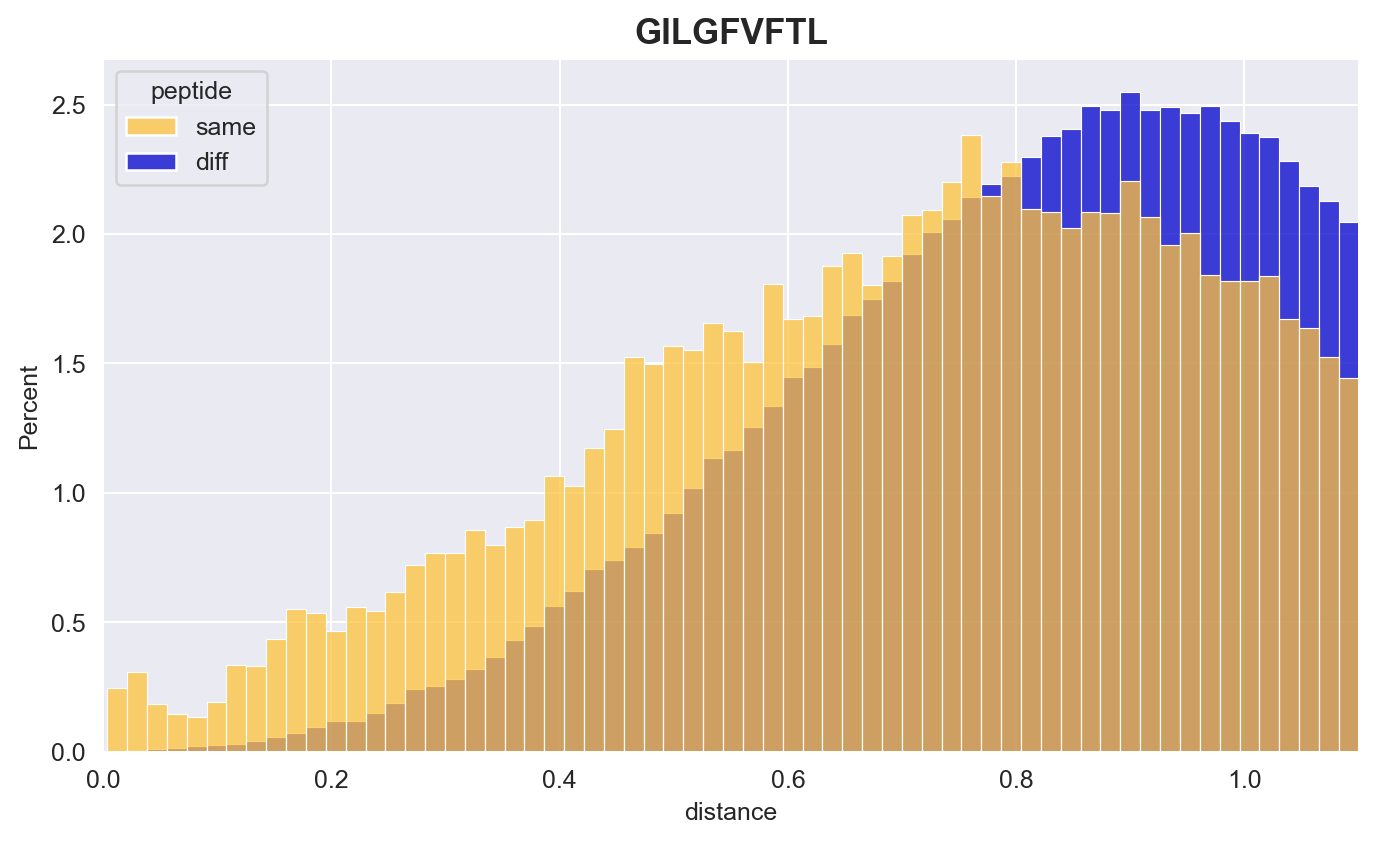

In [66]:
from src.sim_utils import do_histplot_distribution
dist_giltcrs = make_dist_matrix(pd.concat([gil_tcrs, not_tcrs]), 
                 label_col='peptide', seq_cols = seq_cols,
                 cols=['binder', 'seq_id', 'peptide'])
dist_giltcrs['label'] = dist_giltcrs['peptide'].apply(lambda x: int(x=="GILGFVFTL"))
dist_giltcrs['original_peptide']=dist_giltcrs['peptide']
do_histplot_distribution(dist_giltcrs, peptide="GILGFVFTL", label_col='peptide')

In [69]:
def pipe_compare(df_a, df_b, peptide, 
                 seq_cols=['A1','A2','A3','B1','B2','B3','peptide','modality'],
                title=None, xlim=None):
    dm = make_dist_matrix(pd.concat([df_a, df_b]), label_col='peptide', seq_cols=seq_cols,
                          cols=['binder','seq_id','peptide','modality'])
    dm['original_peptide']=dm['peptide']
    do_histplot_distribution(dm, peptide=peptide, label_col='peptide', xlim=xlim, title=title)

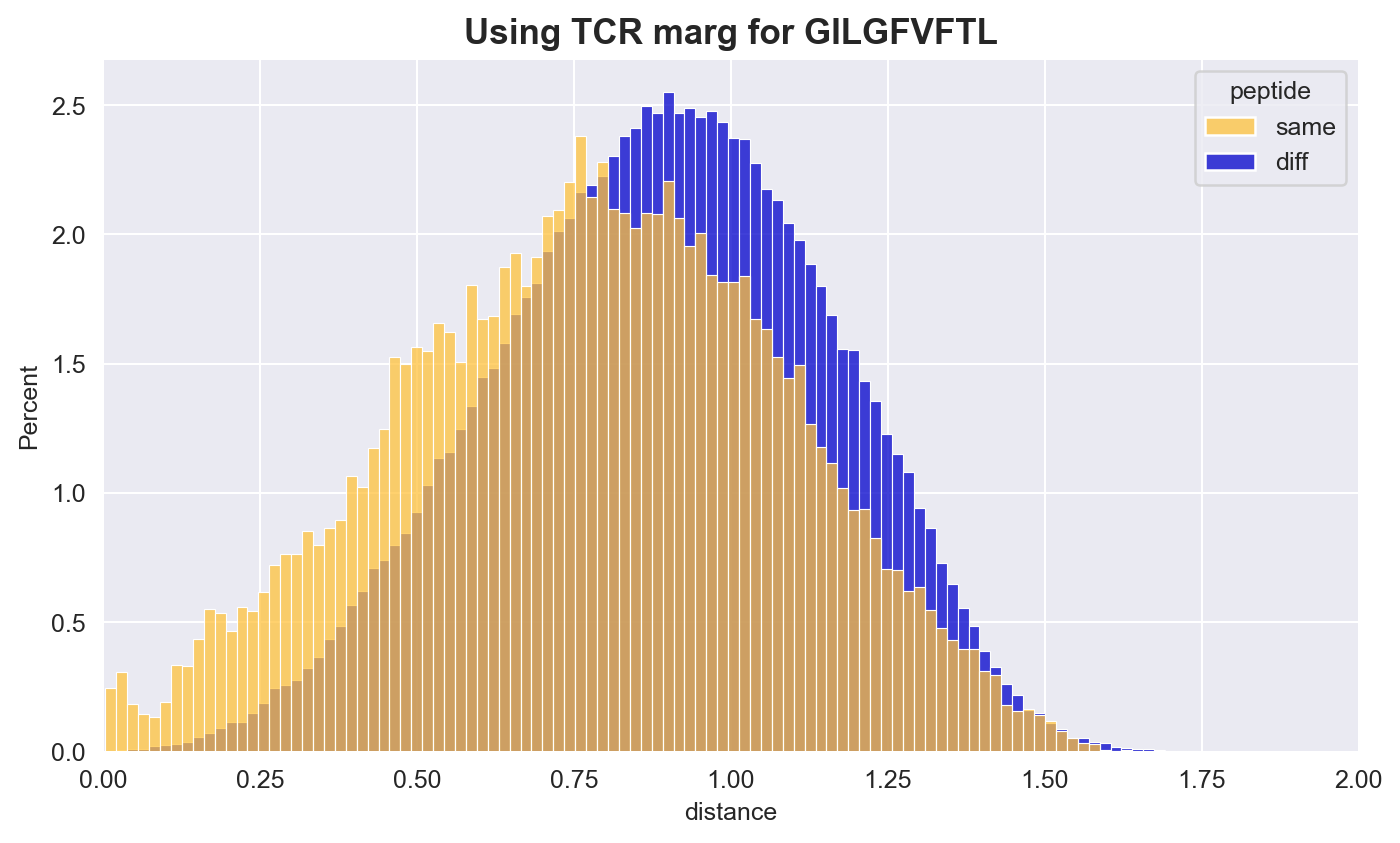

In [106]:
pipe_compare(gil_tcrs, not_tcrs, 'GILGFVFTL', title='Using TCR marg for GILGFVFTL', xlim=[0, 2])

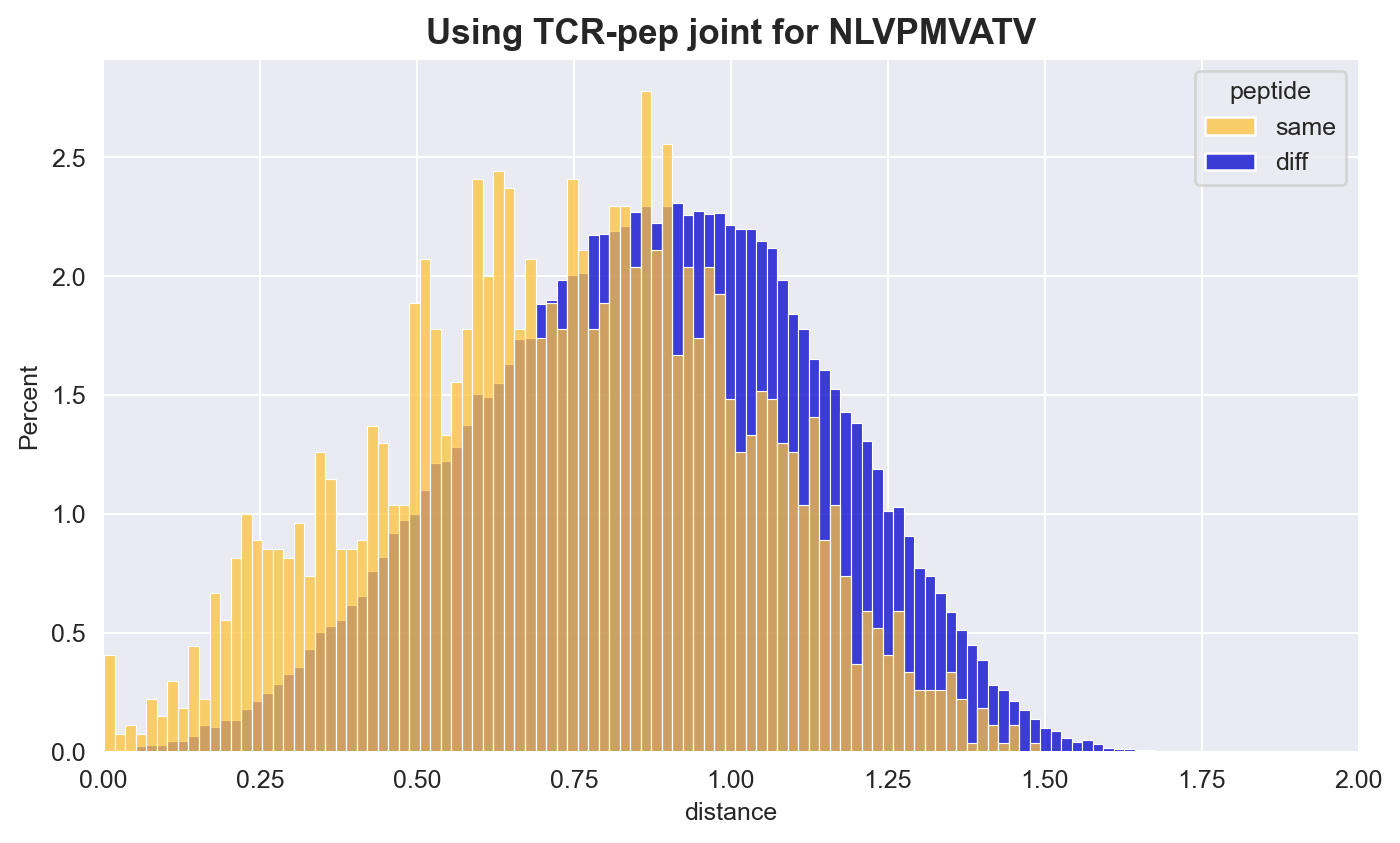

In [112]:
pipe_compare(valid_preds.query('peptide=="NLVPMVATV" and modality=="joint"'), 
             valid_preds.query('peptide!="NLVPMVATV" and modality=="joint"'),
             'NLVPMVATV', title='Using TCR-pep joint for NLVPMVATV', xlim=[0, 2])

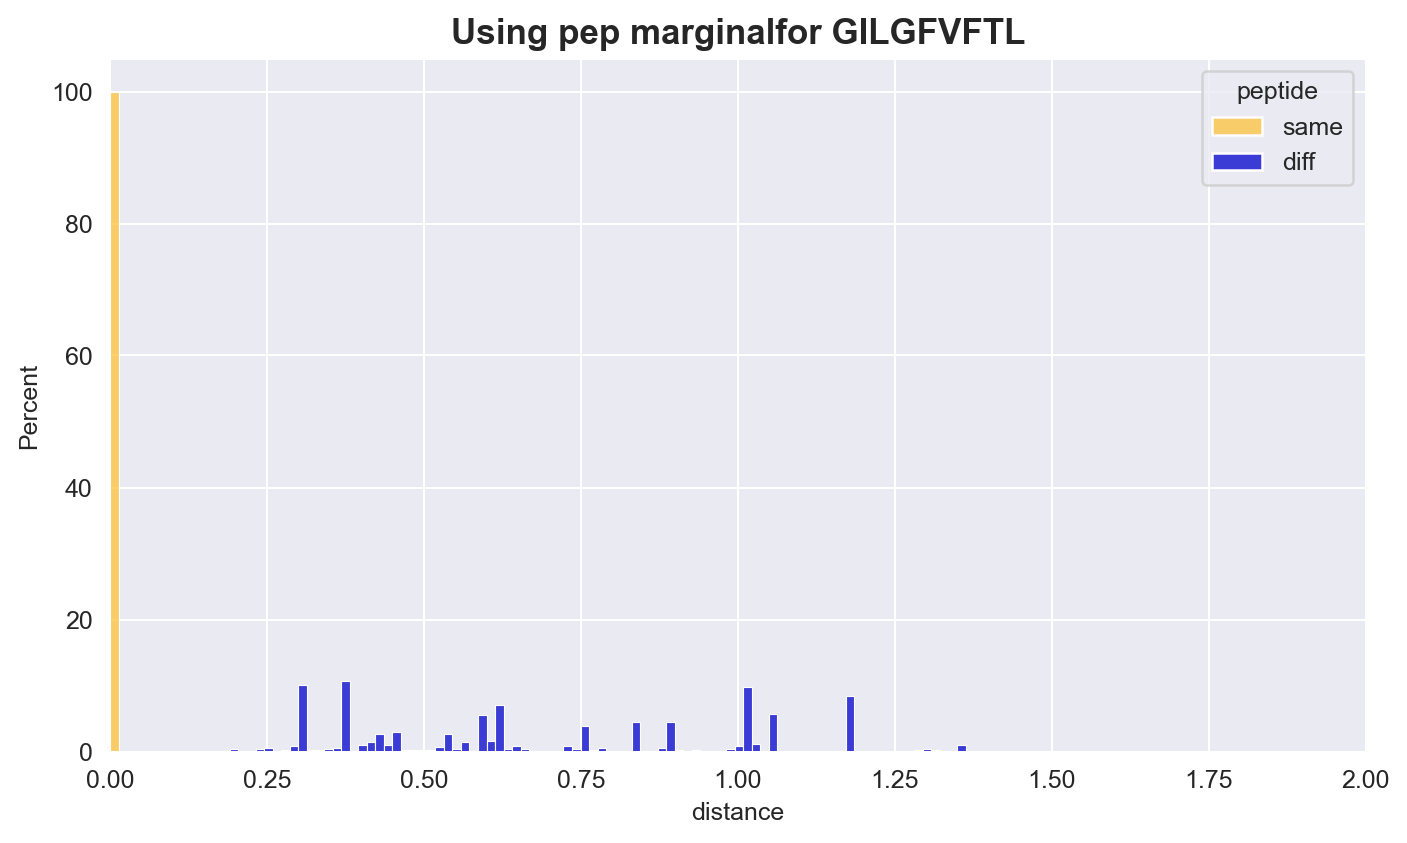

In [105]:
pipe_compare(gil_peps, not_peps, 'GILGFVFTL', title='Using pep marginalfor GILGFVFTL', xlim=[0, 2])

# nettcr

### results sorting

In [933]:
from sklearn.metrics import roc_auc_score
ntcr = pd.read_csv('../output/240328_MMVAE_CLFs/nettcr_cv_pred_df.csv').query('partition==0')
print(round(roc_auc_score(ntcr['binder'], ntcr['prediction']), 4))
print(round(roc_auc_score(ntcr['binder'], ntcr['prediction'], max_fpr=0.1), 4))

0.7926
0.6416


In [788]:
pd.set_option('display.max_colwidth', 200)
logs = pd.read_csv('../output/240402_clf_logs_sorting/ntr.csv')
logs.sort_values('AUC', ascending=False).head()

fn  \
146  f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
66   f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
72               f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
152              f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
14                                                                           kcv_f00_BEST_240326_1635_240326_2stage_CosTrp_AddAll_ExpData_240328_2000_DDDDDD   

        AUC  AUC_01      AP  
146  0.7650  0.6439  0.5039  
66   0.7650  0.6439  0.5039  
72   0.7630  0.6513  0.5106  
152  0.7630  0.6513  0.5106  
14   0.7628  0.6437  0.4995

In [799]:
from src.metrics import get_metrics
results = []
metrics = {'name':'NetTCR-Jonas'}
metrics.update(get_metrics(ntcr['binder'], ntcr['prediction'], reduced=False, round_digit=6, no_curves=True))
results.append(metrics)

import glob
for f in glob.glob('../output/240328_MMVAE_CLFs/*/*/*valid_pred*.csv'):
    preds = pd.read_csv(f)
    x = os.path.basename(f)
    x = x.replace(' saved.','')
    x = x.replace('KFold_0_', '')
    x = x.replace('valid_metrics_', '')
    x = x.replace('valid_metrics_kcv_', '')
    x = x.replace('240326_nettcr_paired_withswaps_', '')
    x = x.replace('.csv', '')
    if 'pepweight' in f.lower():
        print(f)
        x = 'PEPWEIGHTED_'+x
    m = {'name':x}
    m.update(get_metrics(preds['binder'], preds['pred_prob'], reduced=False, round_digit=6, no_curves=True))
    results.append(m)
    # print('\n\n', '####'*30, '\n', x, '\n', m, '\n', '####'*30, '\n')

import glob
for f in sorted(glob.glob('../output/240328_Retrained_SVAE_CLFs/*/*/*valid_pred*.csv')):
    preds = pd.read_csv(f)
    x = os.path.basename(f)
    x = x.replace(' saved.','')
    x = x.replace('KFold_0_', '')
    x = x.replace('valid_metrics_', '')
    x = x.replace('valid_metrics_kcv_', '')
    x = x.replace('240326_nettcr_paired_withswaps_', '')
    x = x.replace('.csv', '')
    
    if 'pepweight' in f.lower() :
        print(f)
        x = 'pepweight_'+x
    m = {'name':x}
    m.update(get_metrics(preds['binder'], preds['pred_prob'], reduced=False, round_digit=6, no_curves=True))
    results.append(m)
    # print('\n\n', '####'*30, '\n', x, '\n', m, '\n', '####'*30, '\n')

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [800]:
for f in sorted(glob.glob('../output/240404_BestLastReset_CLF_comparison/*/*valid_pred*.csv')):
    preds = pd.read_csv(f)
    x = os.path.basename(f)
    x = x.replace(' saved.','')
    x = x.replace('KFold_0_', '')
    x = x.replace('valid_metrics_', '')
    x = x.replace('valid_metrics_kcv_', '')
    x = x.replace('240326_nettcr_paired_withswaps_', '')
    x = x.replace('.csv', '')
    if 'pepweight' in f.lower() :
        print(f)
        x = 'pepweight_'+x
    m = {'name':x}
    m.update(get_metrics(preds['binder'], preds['pred_prob'], reduced=False, round_digit=6, no_curves=True))
    results.append(m)

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [801]:
resdf = pd.DataFrame(results).drop_duplicates(['name', 'auc'])

In [802]:
resdf


name  \
0                                                                                                                                                                       NetTCR-Jonas   
1                       valid_predictions_f00_BEST_3kEpochs_CC_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_2024_VoZuWy   
2                    valid_predictions_f00_LAST_3kEpochs_CC_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240328_1424_iUX7Lu   
3    valid_predictions_f00_LAST_2p5kEpochs_CC_PepBLSM_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0006_syos6U   
4                       valid_predictions_f00_LAST_3kEpochs_CC_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_2057_VoZuWy   
..                                                                                                                                                                               ...   
122                                                                   valid_predictions_kcv_f00_RESET_240404_1150_ExpData_TCRONLY_1stage_SMALL_128h_64l_NoTrp_240405_0017_smallTCRP1   
123                                                                valid_predictions_kcv_f00_RESET_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_240405_0017_2stTCRPLARGE   
124                                                                 valid_predictions_kcv_f00_RESET_240404_1150_ExpData_TCRONLY_2stage_SMALL_128h_64l_NoTrp_240405_0019_2stTCRPsmall   
125                                                                 valid_predictions_kcv_f00_RESET_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_240408_1529_SmCosTCRP1   
126                                                                       valid_predictions_f00_RESET_240405_1224_BSSVAE_CDR3only_LongIsh_nhtcr256_nhpep128_nl100_240408_1629_NXv68i   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
0    0.792402  0.623352     0.284368   0.508116  0.400553  0.835466  0.440562   
1    0.743904  0.636854     0.310023   0.786232  0.221316  0.859761  0.483763   
2    0.740253  0.637976     0.312155   0.831984  0.209587  0.860784  0.481303   
3    0.632551  0.566776     0.176875   0.531165  0.099949  0.834783  0.310511   
4    0.737346  0.631235     0.299346   0.814885  0.217746  0.860955  0.474492   
..        ...       ...          ...        ...       ...       ...       ...   
122  0.727962  0.619612     0.277263   0.748971  0.185620  0.853453  0.442541   
123  0.742276  0.632873     0.302459   0.788955  0.203978  0.857801  0.472307   
124  0.738324  0.619944     0.277894   0.754491  0.192759  0.854561  0.453590   
125  0.743825  0.628928     0.294963   0.755474  0.211117  0.856692  0.465759   
126  0.669922  0.583096     0.207881   0.806084  0.108108  0.846547  0.370370   

        prauc  
0    0.440480  
1    0.483649  
2    0.481189  
3    0.310265  
4    0.474339  
..        ...  
122  0.442363  
123  0.472154  
124  0.453453  
125  0.465606  
126  0.370222  

[127 rows x 9 columns]

In [807]:
resdf.sort_values('auc',ascending=False).head(10)

name  \
0                                                                                                                                                                            NetTCR-Jonas   
13              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
14                          valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
88                                                                                        valid_predictions_kcv_f00_BEST_240326_1639_240326_2stage_NoTrp_AddAll_ExpData_240404_1530_CCCCC   
45  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1947_iUX7Lu   
8               valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2047_IzcVOH   
66     PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0329_VoZuWy   
16                 valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0135_VoZuWy   
51  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2106_IzcVOH   
85                                    valid_predictions_f00_BEST_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240404_1530_IzcVOH   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
0   0.792402  0.623352     0.284368   0.508116  0.400553  0.835466  0.440562   
13  0.764966  0.643855     0.323325   0.789022  0.234574  0.861552  0.503906   
14  0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
88  0.761195  0.640585     0.317112   0.831984  0.209587  0.860784  0.495063   
45  0.760884  0.646081     0.327554   0.766497  0.231005  0.859676  0.499285   
8   0.759998  0.649643     0.334322   0.797678  0.245283  0.863427  0.509834   
66  0.759979  0.645128     0.325743   0.777202  0.229475  0.860188  0.501221   
16  0.759699  0.644732     0.324990   0.821012  0.215196  0.860955  0.501508   
51  0.759597  0.645572     0.326586   0.770000  0.235594  0.860443  0.502519   
85  0.759528  0.643691     0.323012   0.793220  0.238654  0.862319  0.499353   

       prauc  
0   0.440480  
13  0.503784  
14  0.510438  
88  0.495720  
45  0.499148  
8   0.509727  
66  0.501104  
16  0.501396  
51  0.502402  
85  0.499243

In [805]:
resdf.sort_values('auc_01', ascending=False).head(10)

name  \
14                                   valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
8                        valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2047_IzcVOH   
41                       PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2339_yOqyC6   
42   PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1831_hRmUHn   
31               valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1855_hRmUHn   
45           PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1947_iUX7Lu   
51           PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2106_IzcVOH   
66              PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0329_VoZuWy   
16                          valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0135_VoZuWy   
107                                                                                 valid_predictions_kcv_f00_LAST_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_240404_2354_SMALLTCRP1   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
14   0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
8    0.759998  0.649643     0.334322   0.797678  0.245283  0.863427  0.509834   
41   0.758449  0.648554     0.332253   0.800000  0.228455  0.861466  0.508843   
42   0.757646  0.647648     0.330530   0.796029  0.224885  0.860784  0.503014   
31   0.756438  0.647243     0.329761   0.827160  0.204997  0.859932  0.501357   
45   0.760884  0.646081     0.327554   0.766497  0.231005  0.859676  0.499285   
51   0.759597  0.645572     0.326586   0.770000  0.235594  0.860443  0.502519   
66   0.759979  0.645128     0.325743   0.777202  0.229475  0.860188  0.501221   
16   0.759699  0.644732     0.324990   0.821012  0.215196  0.860955  0.501508   
107  0.754549  0.644416     0.324390   0.800705  0.231515  0.861893  0.498928   

        prauc  
14   0.510438  
8    0.509727  
41   0.508741  
42   0.502901  
31   0.501216  
45   0.499148  
51   0.502402  
66   0.501104  
16   0.501396  
107  0.498816

In [806]:
resdf.sort_values('prauc', ascending=False).head(10)

name  \
14                                  valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
8                       valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2047_IzcVOH   
41                      PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2339_yOqyC6   
13                      valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
42  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1831_hRmUHn   
51          PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2106_IzcVOH   
16                         valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0135_VoZuWy   
31              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1855_hRmUHn   
66             PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0329_VoZuWy   
87                                    valid_predictions_f00_BEST_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240404_1530_hRmUHn   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
14  0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
8   0.759998  0.649643     0.334322   0.797678  0.245283  0.863427  0.509834   
41  0.758449  0.648554     0.332253   0.800000  0.228455  0.861466  0.508843   
13  0.764966  0.643855     0.323325   0.789022  0.234574  0.861552  0.503906   
42  0.757646  0.647648     0.330530   0.796029  0.224885  0.860784  0.503014   
51  0.759597  0.645572     0.326586   0.770000  0.235594  0.860443  0.502519   
16  0.759699  0.644732     0.324990   0.821012  0.215196  0.860955  0.501508   
31  0.756438  0.647243     0.329761   0.827160  0.204997  0.859932  0.501357   
66  0.759979  0.645128     0.325743   0.777202  0.229475  0.860188  0.501221   
87  0.757124  0.643421     0.322500   0.812500  0.218766  0.860955  0.499553   

       prauc  
14  0.510438  
8   0.509727  
41  0.508741  
13  0.503784  
42  0.502901  
51  0.502402  
16  0.501396  
31  0.501216  
66  0.501104  
87  0.499440

### roc curves for the best model of each kind (Old, Old2stage, BSS, BSSunpaired, JMVAE)

#### Finding best old model one

In [815]:
resdf.sort_values('auc',ascending=False).head()

name  \
0                                                                                                                                                                            NetTCR-Jonas   
13              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
14                          valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
88                                                                                        valid_predictions_kcv_f00_BEST_240326_1639_240326_2stage_NoTrp_AddAll_ExpData_240404_1530_CCCCC   
45  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1947_iUX7Lu   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
0   0.792402  0.623352     0.284368   0.508116  0.400553  0.835466  0.440562   
13  0.764966  0.643855     0.323325   0.789022  0.234574  0.861552  0.503906   
14  0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
88  0.761195  0.640585     0.317112   0.831984  0.209587  0.860784  0.495063   
45  0.760884  0.646081     0.327554   0.766497  0.231005  0.859676  0.499285   

       prauc  
0   0.440480  
13  0.503784  
14  0.510438  
88  0.495720  
45  0.499148

In [814]:
resdf.sort_values('auc_01', ascending=False).head()

name  \
14                                  valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
8                       valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2047_IzcVOH   
41                      PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2339_yOqyC6   
42  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1831_hRmUHn   
31              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1855_hRmUHn   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
14  0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
8   0.759998  0.649643     0.334322   0.797678  0.245283  0.863427  0.509834   
41  0.758449  0.648554     0.332253   0.800000  0.228455  0.861466  0.508843   
42  0.757646  0.647648     0.330530   0.796029  0.224885  0.860784  0.503014   
31  0.756438  0.647243     0.329761   0.827160  0.204997  0.859932  0.501357   

       prauc  
14  0.510438  
8   0.509727  
41  0.508741  
42  0.502901  
31  0.501216

In [808]:
resdf.query('name.str.endswith("AAA") or name.str.endswith("BBB") or name.str.endswith("CCC") or name.str.endswith("DDD")').sort_values('auc_01', ascending=False).head()

name  \
82           valid_predictions_kcv_f00_LAST_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_240328_1603_AAAAAA   
88            valid_predictions_kcv_f00_BEST_240326_1639_240326_2stage_NoTrp_AddAll_ExpData_240404_1530_CCCCC   
83  valid_predictions_kcv_f00_LAST_PEPBLSM_240402_1135_240326_1stage_CosTrp_AddAll_ExpData_240403_1422_BBBBBB   
89           valid_predictions_kcv_f00_BEST_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_240404_1530_AAAAAA   
79  valid_predictions_kcv_f00_BEST_PEPBLSM_240402_1135_240326_1stage_CosTrp_AddAll_ExpData_240403_1343_BBBBBB   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
82  0.748566  0.641304     0.318478   0.780347  0.206527  0.857630  0.488551   
88  0.761195  0.640585     0.317112   0.831984  0.209587  0.860784  0.495063   
83  0.754172  0.640484     0.316921   0.797398  0.218766  0.860102  0.491128   
89  0.746228  0.638482     0.313115   0.816456  0.197348  0.858397  0.480755   
79  0.748248  0.636671     0.309676   0.772887  0.223865  0.859250  0.483947   

       prauc  
82  0.488432  
88  0.495720  
83  0.490999  
89  0.480625  
79  0.483829

In [940]:
resdf.query('name.str.contains("TCRONLY")').sort_values('auc', ascending=False).head()

name  \
107    valid_predictions_kcv_f00_LAST_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_240404_2354_SMALLTCRP1   
95   valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_240404_2331_2stTCRPLARGE   
96    valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_2stage_SMALL_128h_64l_NoTrp_240404_2331_2stTCRPsmall   
97    valid_predictions_kcv_f00_BEST_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_240408_1450_SmCosTCRP1   
93     valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_240404_2332_SMALLTCRP1   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
107  0.754549  0.644416     0.324390   0.800705  0.231515  0.861893  0.498928   
95   0.754270  0.639261     0.314596   0.837838  0.205507  0.860529  0.490364   
96   0.750716  0.635173     0.306828   0.816631  0.195309  0.858142  0.482627   
97   0.746446  0.638210     0.312600   0.840580  0.207037  0.860870  0.486075   
93   0.746074  0.638760     0.313644   0.789855  0.222336  0.860102  0.485161   

        prauc  
107  0.498816  
95   0.490999  
96   0.482514  
97   0.486205  
93   0.485040

In [812]:
resdf.query('name.str.contains("TCRONLY")').sort_values('auc_01', ascending=False).head()

name  \
107    valid_predictions_kcv_f00_LAST_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_240404_2354_SMALLTCRP1   
108     valid_predictions_kcv_f00_LAST_240404_1150_ExpData_TCRONLY_1stage_SMALL_128h_64l_NoTrp_240404_2354_smallTCRP1   
95   valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_240404_2331_2stTCRPLARGE   
94      valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_1stage_SMALL_128h_64l_NoTrp_240404_2332_smallTCRP1   
93     valid_predictions_kcv_f00_BEST_240404_1150_ExpData_TCRONLY_1stage_LARGE_256h_100l_NoTrp_240404_2332_SMALLTCRP1   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
107  0.754549  0.644416     0.324390   0.800705  0.231515  0.861893  0.498928   
108  0.745482  0.640093     0.316176   0.786096  0.224885  0.860188  0.490139   
95   0.754270  0.639261     0.314596   0.837838  0.205507  0.860529  0.490364   
94   0.741244  0.638964     0.314031   0.819961  0.213666  0.860699  0.484430   
93   0.746074  0.638760     0.313644   0.789855  0.222336  0.860102  0.485161   

        prauc  
107  0.498816  
108  0.490024  
95   0.490999  
94   0.484555  
93   0.485040

In [818]:
resdf.query('name.str.contains("CDR3")').sort_values('auc_01', ascending=False).head()

name  \
98    valid_predictions_f00_BEST_240405_1224_BSSVAE_CDR3only_LongIsh_nhtcr256_nhpep128_nl100_240408_1550_NXv68i   
126  valid_predictions_f00_RESET_240405_1224_BSSVAE_CDR3only_LongIsh_nhtcr256_nhpep128_nl100_240408_1629_NXv68i   
112   valid_predictions_f00_LAST_240405_1224_BSSVAE_CDR3only_LongIsh_nhtcr256_nhpep128_nl100_240408_1610_NXv68i   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
98   0.688698  0.594240     0.229056   0.707895  0.137175  0.846292  0.392848   
126  0.669922  0.583096     0.207881   0.806084  0.108108  0.846547  0.370370   
112  0.668471  0.581417     0.204692   0.744526  0.104029  0.844246  0.359492   

        prauc  
98   0.392699  
126  0.370222  
112  0.359302

In [810]:
resdf.query('name.str.contains("SmC")').sort_values('auc_01', ascending=False).head()

name  \
97    valid_predictions_kcv_f00_BEST_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_240408_1450_SmCosTCRP1   
111   valid_predictions_kcv_f00_LAST_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_240408_1509_SmCosTCRP1   
125  valid_predictions_kcv_f00_RESET_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_240408_1529_SmCosTCRP1   

          auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
97   0.746446  0.638210     0.312600   0.840580  0.207037  0.860870  0.486075   
111  0.742420  0.632901     0.302512   0.808989  0.183580  0.856266  0.472361   
125  0.743825  0.628928     0.294963   0.755474  0.211117  0.856692  0.465759   

        prauc  
97   0.486205  
111  0.472966  
125  0.465606

In [154]:
old = ' not ' + '(name.str.endswith("AAA") or name.str.endswith("BBB") or name.str.endswith("CCC") or name.str.endswith("DDD"))'
resdf.query(f'name.str.contains("BSS") and name.str.contains("UNP") and {old}').sort_values('auc_01', ascending=False).head()

name  \
63          PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0117_syos6U   
24                        valid_predictions_f00_BEST_3kEpochs_CC_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_1810_syos6U   
55  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0055_syos6U   
26              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2336_syos6U   
3               valid_predictions_f00_LAST_2p5kEpochs_CC_PepBLSM_240321_1735_BSSVAE_UNPAIRED_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0006_syos6U   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
63  0.670042  0.587422     0.216102   0.654762  0.168281  0.846121  0.378276   
24  0.668329  0.587351     0.215966   0.643701  0.166752  0.845269  0.376487   
55  0.661967  0.580080     0.202151   0.691558  0.108618  0.842882  0.349574   
26  0.658485  0.577724     0.197676   0.712329  0.106068  0.843393  0.353543   
3   0.632551  0.566776     0.176875   0.531165  0.099949  0.834783  0.310511   

       prauc  
63  0.378139  
24  0.376348  
55  0.349300  
26  0.353384  
3   0.310265

In [155]:
old = ' not ' + '(name.str.endswith("AAA") or name.str.endswith("BBB") or name.str.endswith("CCC") or name.str.endswith("DDD"))'
resdf.query(f'name.str.contains("BSS") and not name.str.contains("UNP") and {old}').sort_values('auc_01', ascending=False).head()

name  \
14                                  valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2240_yOqyC6   
8                       valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_BSSVAE_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_2047_IzcVOH   
41                      PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2339_yOqyC6   
42  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1831_hRmUHn   
31              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1503_BSSVAE_ADDKLDN_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1855_hRmUHn   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
14  0.763026  0.651277     0.337427   0.825758  0.222336  0.862148  0.510570   
8   0.759998  0.649643     0.334322   0.797678  0.245283  0.863427  0.509834   
41  0.758449  0.648554     0.332253   0.800000  0.228455  0.861466  0.508843   
42  0.757646  0.647648     0.330530   0.796029  0.224885  0.860784  0.503014   
31  0.756438  0.647243     0.329761   0.827160  0.204997  0.859932  0.501357   

       prauc  
14  0.510438  
8   0.509727  
41  0.508741  
42  0.502901  
31  0.501216

In [817]:
old = ' not ' + '(name.str.endswith("AAA") or name.str.endswith("BBB") or name.str.endswith("CCC") or name.str.endswith("DDD"))'
resdf.query(f'name.str.contains("JMV") and not name.str.contains("UNP") and {old}').sort_values('auc_01', ascending=False).head()

name  \
45  PEPWEIGHTED_valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1947_iUX7Lu   
13              valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_240327_1951_iUX7Lu   
29                  valid_predictions_f00_LAST_2p5kEpochs_CC_PepBLSM_240321_1427_JMVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_0106_ANzj8c   
34                            valid_predictions_f00_LAST_3kEpochs_CC_240321_1427_JMVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240328_1951_ANzj8c   
17                           valid_predictions_f00_LAST_2p5kEpochs_CC_PepBLSM_240323_1757_RESUME_ADDKLDN_JMVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_240327_2211_zR6ccN   

         auc    auc_01  auc_01_real  precision    recall  accuracy        AP  \
45  0.760884  0.646081     0.327554   0.766497  0.231005  0.859676  0.499285   
13  0.764966  0.643855     0.323325   0.789022  0.234574  0.861552  0.503906   
29  0.753564  0.643574     0.322791   0.769882  0.232024  0.860017  0.495636   
34  0.747511  0.642133     0.320053   0.846667  0.194289  0.859420  0.489008   
17  0.739182  0.641550     0.318945   0.827853  0.218256  0.861722  0.485517   

       prauc  
45  0.499148  
13  0.503784  
29  0.495507  
34  0.488887  
17  0.485395

### plotting curves?

In [954]:
%ls ../output/240402_clf_logs_sorting/results_sorting/

BEST_1st_TCRONLY_LaTCRcos/          BEST_NEW_TCRONLY_LaTCRno/
BEST_BSSVAE_PEPBLSM_Long25k_yOqyC6/ BEST_OLD_2stage_CosTrp_DDDDDD/
BEST_BSSVAEup_LONG_ezI4Q3/          LAST_OLD_1stage_CosTrp_BBBBBB/
BEST_JMVAE_PEPBLSM_Long25k_iUX7Lu/  XGBoostBLOSUM_XGBLSM/


In [952]:
from src.metrics import get_metrics
fs = sorted(glob.glob('../output/240402_clf_logs_sorting/results_sorting/*/*pred*.csv'))
preds = {k.replace('../output/240402_clf_logs_sorting/results_sorting/','').split('/')[0]:get_metrics(pd.read_csv(k).query('partition==0')['binder'], 
                                                                                                      pd.read_csv(k).query('partition==0')['pred_prob'], 
                                                                                                      no_curves=False, reduced=False,
                                                                                                      round_digit=6)\
                                                                                                      for k in fs}
preds['nettcr'] = get_metrics(ntcr.query('partition==0')['binder'], ntcr.query('partition==0')['prediction'],no_curves=False, reduced=False,
                                                                                                      round_digit=4)

Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing
Couldn't round roc_curve of type (<class 'tuple'>)! continuing
Couldn't round pr_curve of type (<class 'tuple'>)! continuing


In [953]:
len(preds)

9

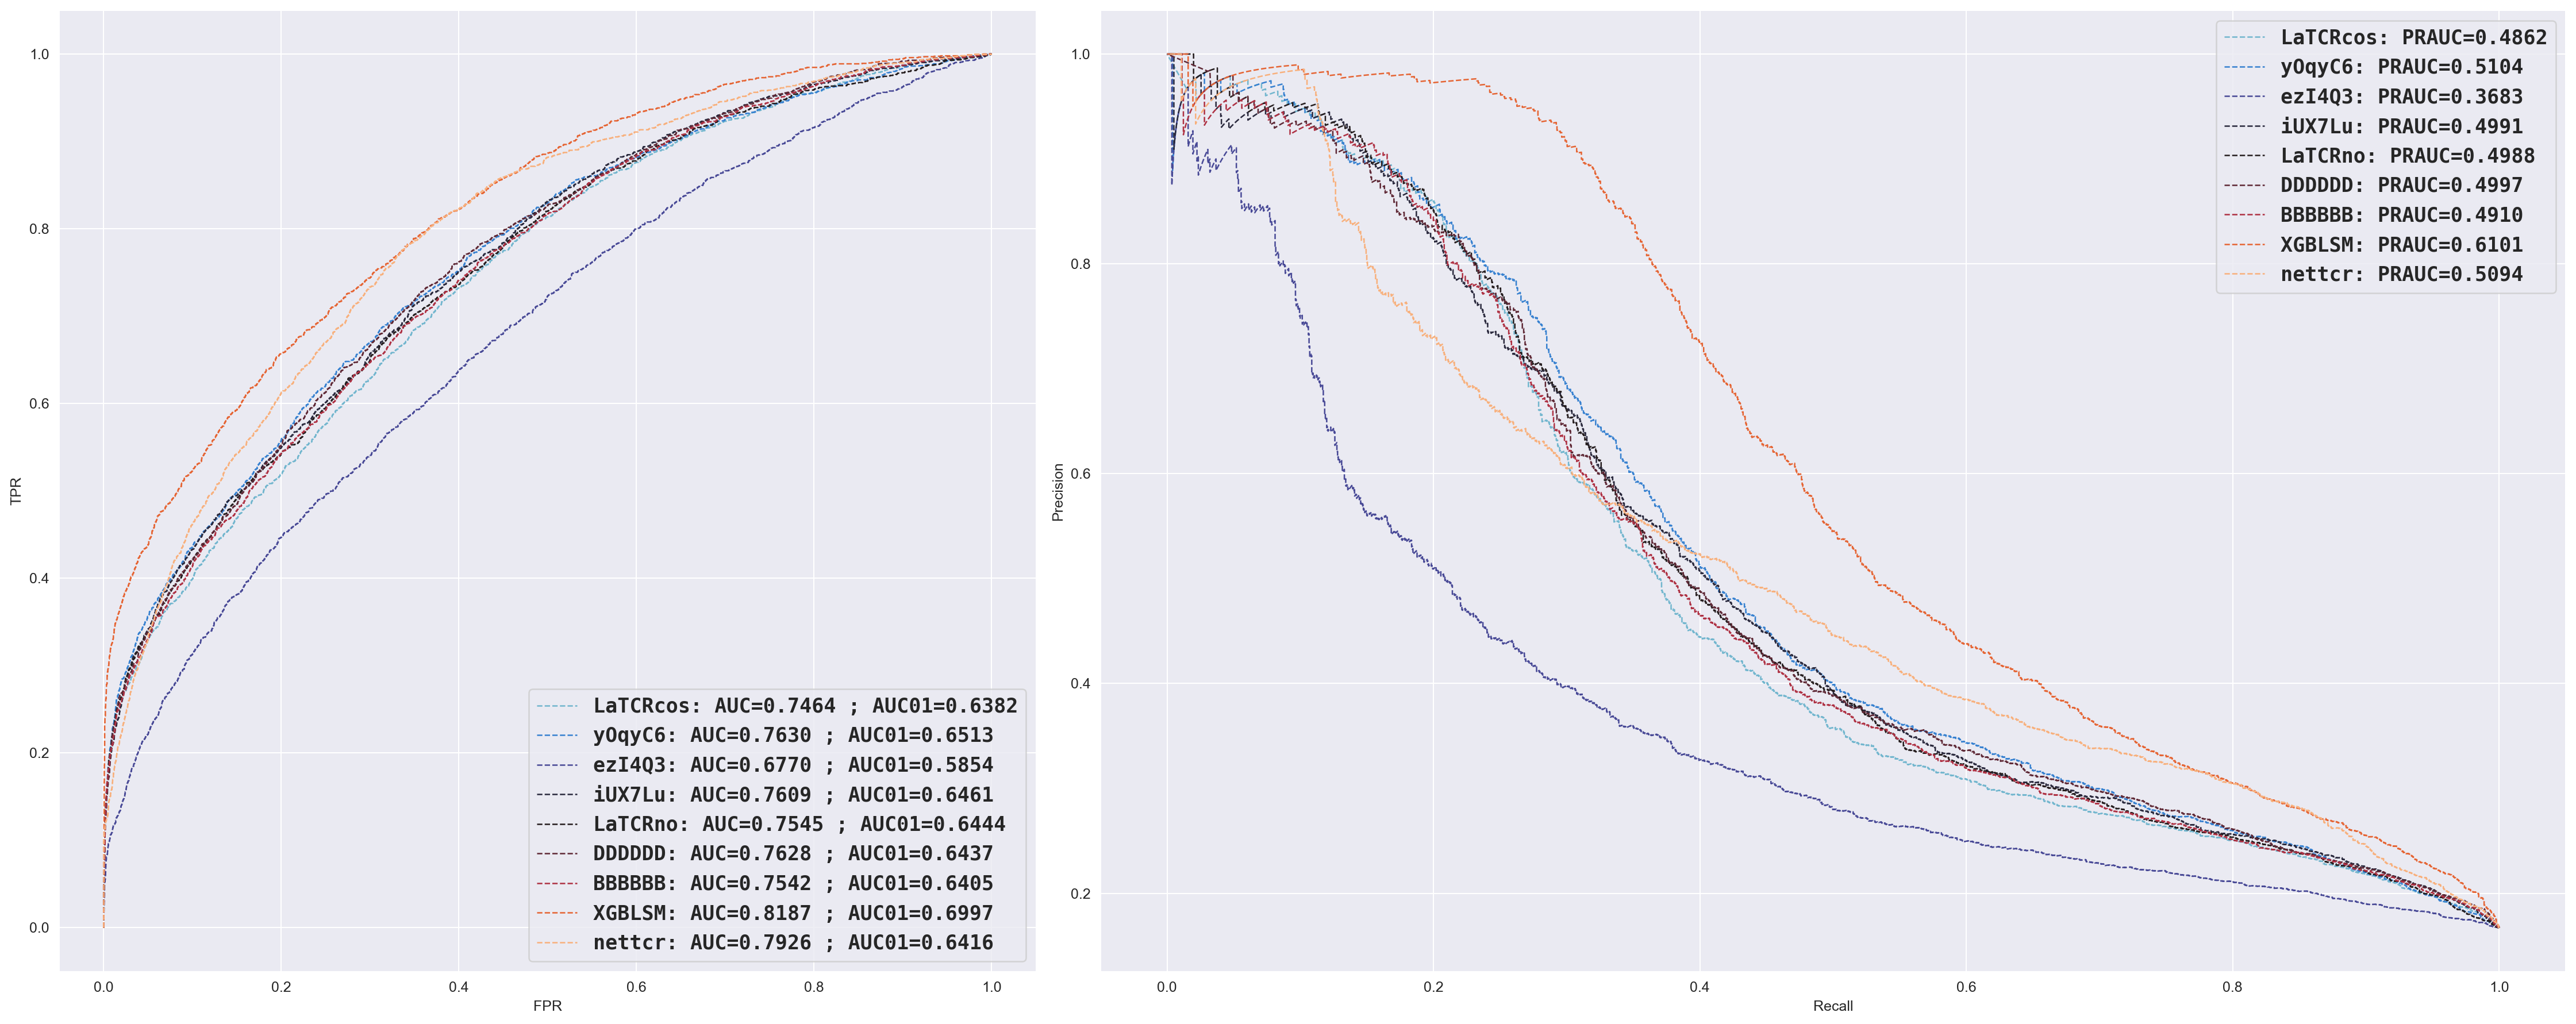

In [951]:
sns.set_palette(get_palette('icefire', len(preds)))
# f,a = plt.subplots(1,1, figsize=(20,10))
# Define the width ratios for the subplots
width_ratios = [2, 3]

# Create subplots with 1 row and 2 columns, using width_ratios for sizing
fig, ax = plt.subplots(1, 2, figsize=(25, 10), gridspec_kw={'width_ratios': width_ratios})
ax = ax.ravel()
for k,v in preds.items():
    roc = v['roc_curve']
    pr = v['pr_curve']
    auc=v['auc']
    auc01=v['auc_01']
    prauc=v['prauc']
    ax[0].plot(roc[0], roc[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: AUC={auc:.4f} ; AUC01={auc01:.4f}', ls='--', lw=1)
    ax[1].plot(pr[0], pr[1], label=f'{k.replace("PEPBLSM","").split("_")[-1]}: PRAUC={prauc:.4f}', ls='--', lw=1)
l1 = ax[0].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})
ax[0].set_xlabel('FPR')
ax[0].set_ylabel('TPR')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')

l2 = ax[1].legend(prop={'weight':'semibold','size':14, 'family':'monospace'})


fig.tight_layout()

### check per-peptide AUC 

In [469]:
preds = pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/BEST_BSSVAE_PEPBLSM_Long25k_yOqyC6/valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240327_2240_yOqyC6.csv')
preds.sample(5)

peptide      A1        A2              A3     B1      B2  \
11399  AVFDRKSDAK  SSVSVY  YLSGSTLV  AVIRSAQGGSEKLV  SGHAT  FQNNGV   
1274    FEDLRVLSF  DSAIYN   IQSSQRE     AVSGGGADGLT  SGHDY  FNNNVP   
781     HTMLCMCCK  DSSSTY   IFSNMDM     AEIAGGYNKLI  SGHKS  YYEKEE   
10043    RAKFKQLL  DSAIYN   IQSSQRE     AVSGGGADGLT  SGHDY  FNNNVP   
5680    SPRWYFYYL  VSNAYN      GSKP       AVEDGARLM  MDHEN  SYDVKM   

                  B3       allele  partition  binder           origin  \
11399  ASSWGGGSHYGYT  HLA-A*11:01          0       0  peptide_swapped   
1274     ASGRLSYNEQF  HLA-B*37:01          0       0  peptide_swapped   
781    ASSLASWGNEKLF  HLA-A*11:01          0       0  peptide_swapped   
10043    ASGRLSYNEQF  HLA-B*08:01          0       1              10x   
5680    ASSSGQDFYGYT  HLA-B*07:02          0       0  peptide_swapped   

      original_peptide   raw_index reference source_organism input_type  \
11399        IVTDFSVIK  ITRAP_1460  37133356             NaN    tcr_pep   
1274          RAKFKQLL  ITRAP_1501  37133356             NaN    tcr_pep   
781          RPRGEVRFL  VDJdb_4807  20139278           HSV-2    tcr_pep   
10043         RAKFKQLL  ITRAP_1501  37133356             NaN    tcr_pep   
5680         KLGGALQAK  ITRAP_4194  37133356             NaN    tcr_pep   

       pred_logit  pred_prob  fold  
11399   -1.630755   0.163727     0  
1274    -1.498626   0.182631     0  
781     -6.377197   0.001697     0  
10043    0.445811   0.609643     0  
5680    -2.480558   0.077232     0

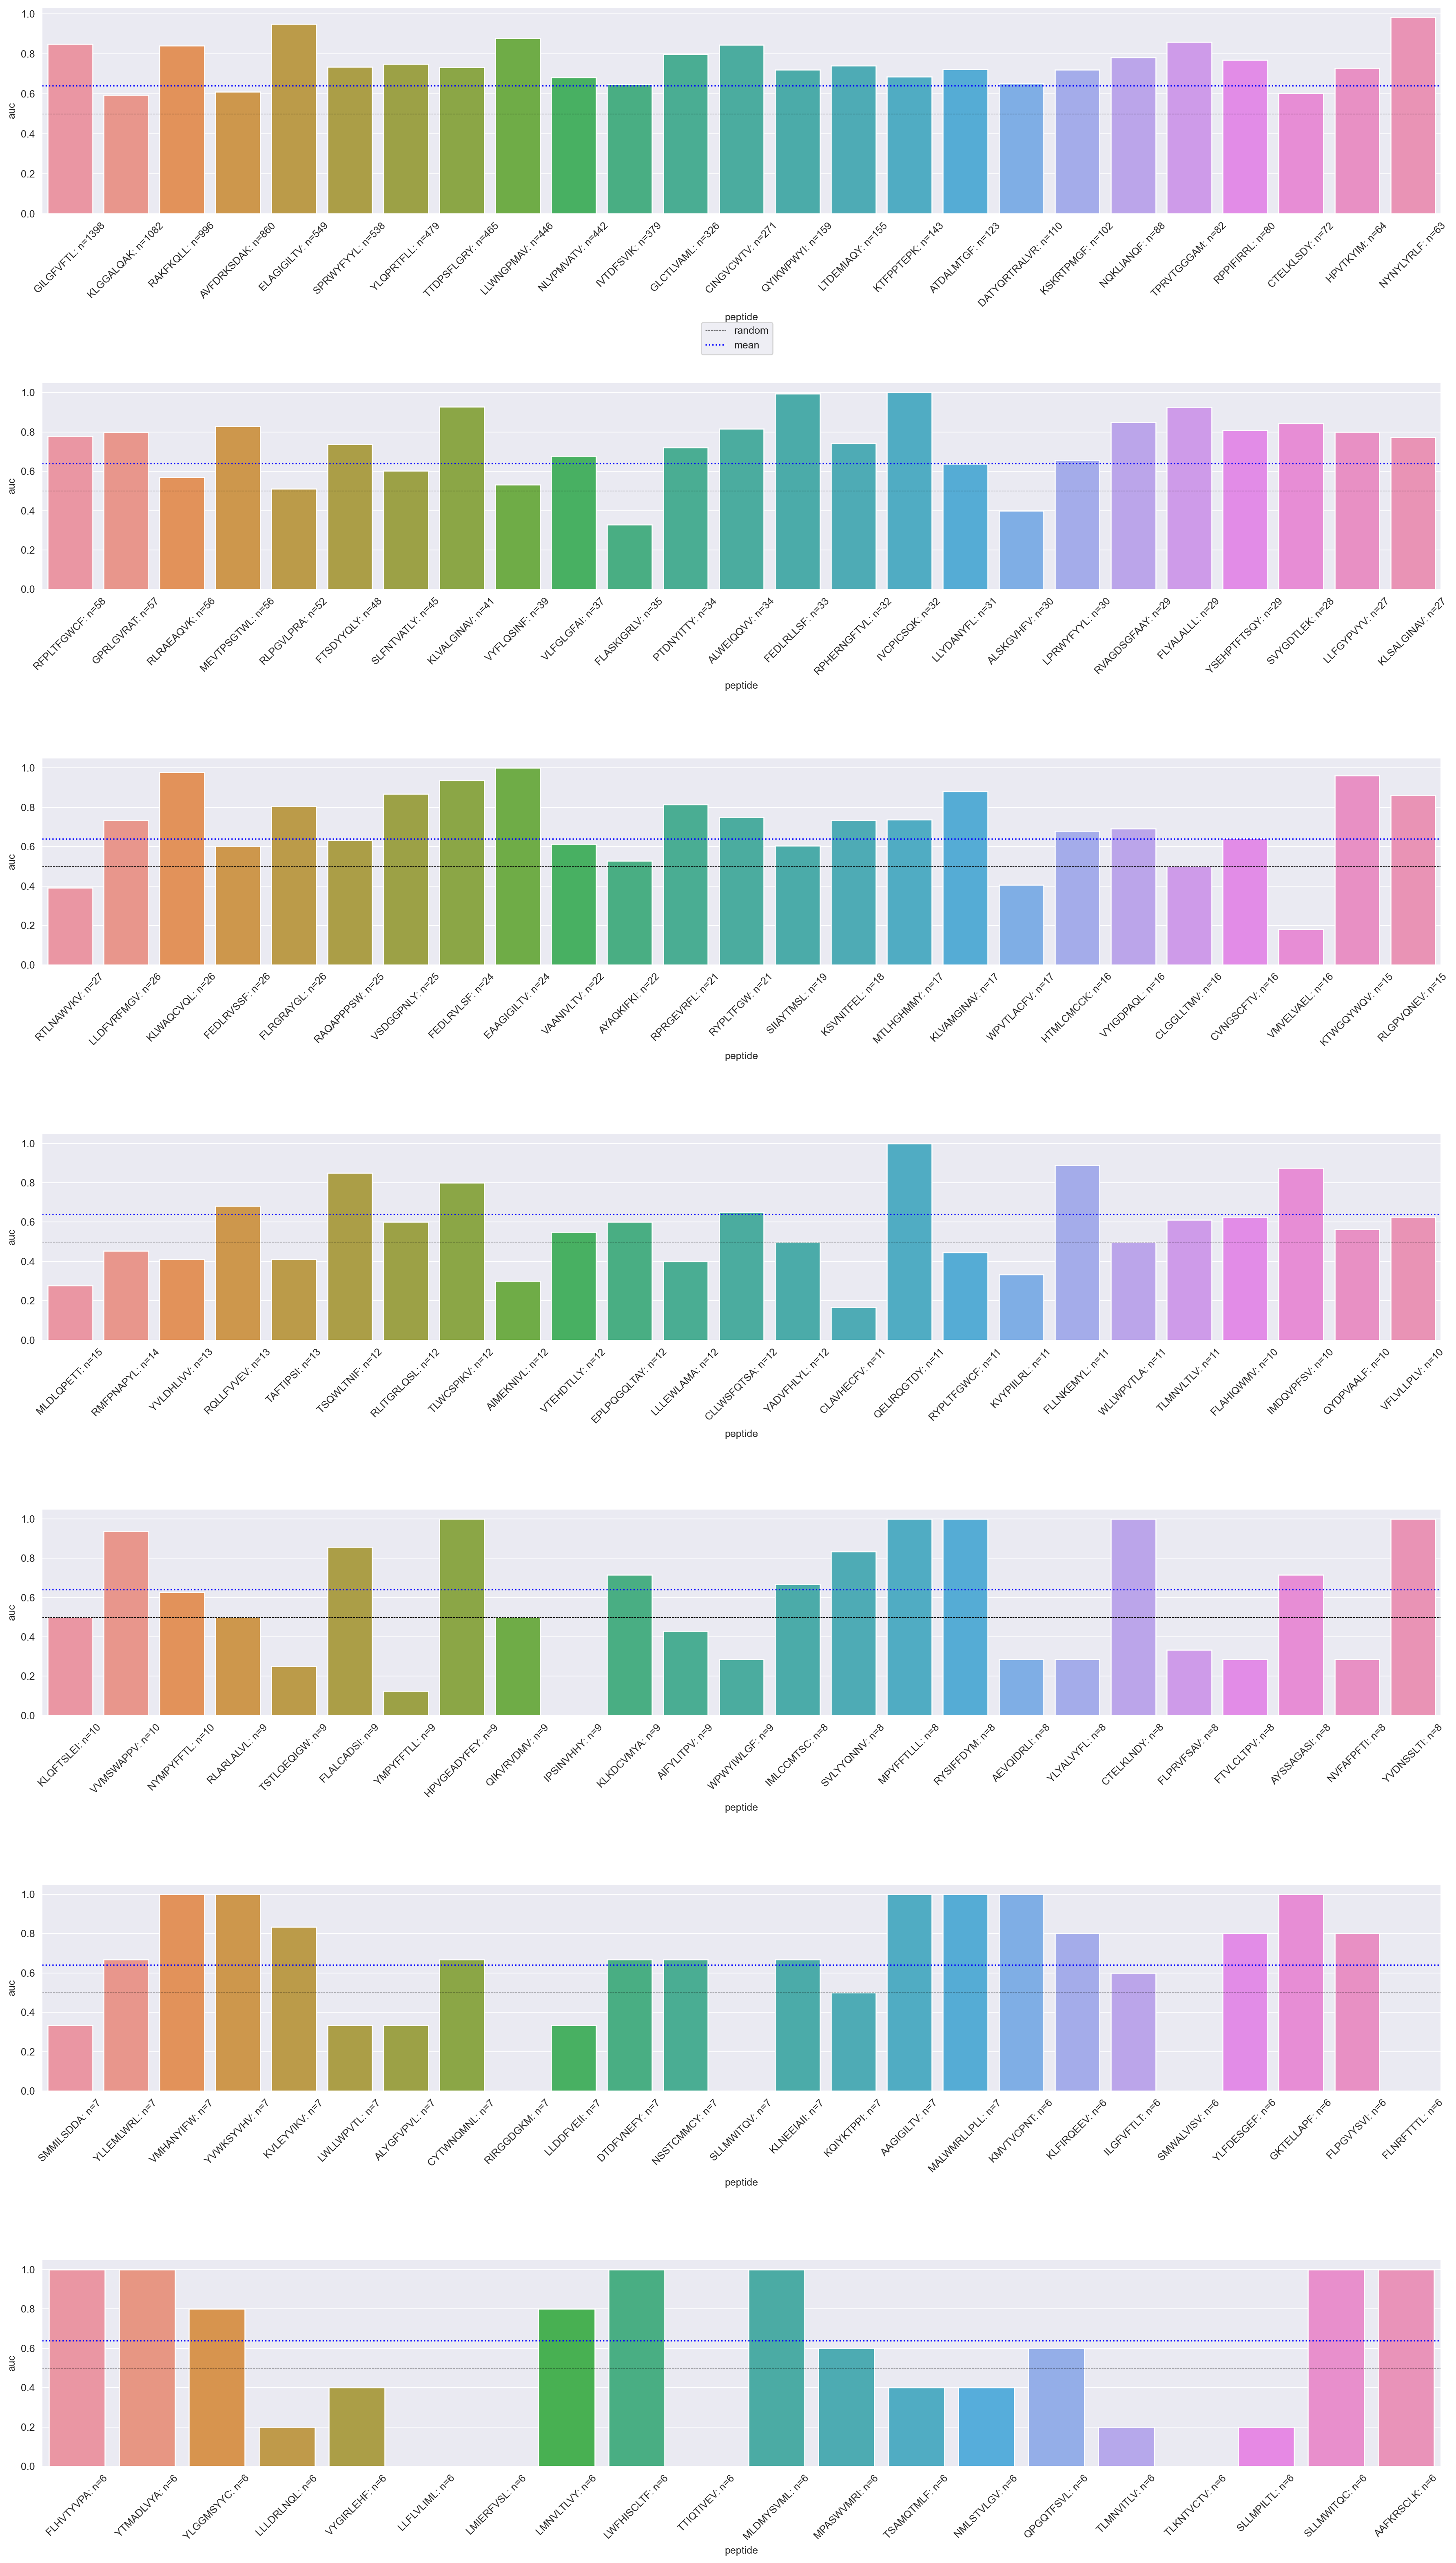

In [531]:
label_col='binder'
pred_col='pred_prob'
n_bars=25

n_peps = len(preds.peptide.unique())
pep_order = preds.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index
results = []
for p in pep_order:
    query = preds.query('peptide==@p')
    metrics = {'peptide':p, 'n_pos':len(query)}
    metrics.update(get_metrics(query[label_col], query[pred_col]))
    results.append(metrics)
results = pd.DataFrame(results)
mean_auc = results.auc.mean()
random = 0.5
sns.set_palette('Set1',n_colors=1)
n_plots = math.ceil(n_peps / n_bars)
f,a = plt.subplots(n_plots, 1, figsize=(20,5*n_plots))
ax=a.ravel()
batch_idx = batchify(results.index, n_bars)
for i,b in enumerate(batch_idx):
    subset = results.loc[b]
    sns.barplot(subset, x='peptide', y='auc', ax=a[i])
    xticklabels = [f'{a}: n={b}' for a,b in subset[['peptide', 'n_pos']].values]
    a[i].set_xticklabels(xticklabels, rotation=45)
    a[i].axhline(random, label='random', ls='--', lw=0.5, c='k')
    a[i].axhline(mean_auc, label='mean', ls=':', lw=1.25, c='b')
a[0].legend(bbox_to_anchor=(.526,-.5))
f.tight_layout()

In [601]:
def batchify(indices, batch_size):
    """
    Split a list into batches with the last batch accounting for the total size of the list.

    Parameters:
    lst (list): The list to split.
    batch_size (int): The size of each batch.

    Returns:
    list: A list of batches.
    """
    batches = [indices[i:i + batch_size] for i in range(0, len(indices), batch_size)]
    return batches

def get_per_pep_metrics(preds, label_col='binder', pred_col='pred_prob'):
    pep_order = preds.groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index
    results = []
    for p in pep_order:
        query = preds.query('peptide==@p')
        metrics = {'peptide':p, 'n_pos':len(query)}
        metrics.update(get_metrics(query[label_col], query[pred_col]))
        results.append(metrics)
    results = pd.DataFrame(results)
    return results
    
def plot_single_per_pep(preds, label_col='binder', pred_col='pred_prob', n_bars=25):
    results = get_per_pep_metrics(preds, label_col, pred_col)
    n_peps = len(preds.peptide.unique())
    mean_auc = results.auc.mean()
    random = 0.5
    sns.set_palette('Set1',n_colors=1)
    n_plots = math.ceil(n_peps / n_bars)
    f,a = plt.subplots(n_plots, 1, figsize=(20,5*n_plots))
    ax=a.ravel()
    batch_idx = batchify(results.index, n_bars)
    for i,b in enumerate(batch_idx):
        subset = results.loc[b]
        sns.barplot(subset, x='peptide', y='auc', ax=a[i], palette=sns.color_palette('deep', 1), alpha=0.8)
        xticklabels = [f'{a}: n={b}' for a,b in subset[['peptide', 'n_pos']].values]
        a[i].set_xticklabels(xticklabels, rotation=45)
        a[i].axhline(random, label='random', ls='--', lw=0.5, c='k')
        a[i].axhline(mean_auc, label='mean', ls=':', lw=1.25, c=(0.5, 0.5, 0))
    a[0].legend(bbox_to_anchor=(.526,-.51))
    f.tight_layout()

def compare_per_pep_auc(preds_list, names_list, label_col, pred_col, n_bars):
    results = {k:get_per_pep_metrics(v).assign(model=k) for k,v in zip(names_list, preds_list)}
    # Mean aucs for axhline
    means = {k:v.auc.mean() for k,v in results.items()}
    random = 0.5
    # plotting stuff
    sns.set_palette(get_palette('Set1', len(results)))
    n_peps = len(preds_list[0].peptide.unique())
    mean_colors = get_palette('Set1', len(results))
    n_plots = math.ceil(n_peps / n_bars)

    len_y = 5*n_plots
    len_x = 1.2 * n_bars
    f,a = plt.subplots(n_plots, 1, figsize=(len_x, len_y))
    ax=a.ravel()
    cat_results = pd.concat(results.values())
    # batching peptide orders
    pep_order = preds_list[0].groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).index
    batch_idx = batchify(pep_order, n_bars)
    model = [k for k in results.keys()][0]
    # looping over axes
    for i,b in enumerate(batch_idx):
        # Query subset of peps
        subset = cat_results.query('peptide in @b')
        # barplot using model as hue
        sns.barplot(subset, x='peptide', y='auc', ax=a[i], hue='model', alpha=0.8)
        # Formatting
        xticklabels = [f'{a}:\nn={b}' for a,b in subset.query('model==@model')[['peptide', 'n_pos']].values]
        a[i].set_xticklabels(xticklabels, rotation=0)
        a[i].axhline(random, label='random', ls=':', lw=0.75, c='k')
        # Adding mean axhline
        for i2, (k,v) in enumerate(means.items()):
            a[i].axhline(v, label=f'{k}: mean AUC', ls='--', lw=1, c= mean_colors[i2])
        a[i].legend('', frameon=False)
    a[0].legend(bbox_to_anchor=(1.125,-.51))
    f.savefig('./test.png', dpi=200, bbox_inches='tight')
    # f.tight_layout(pad=0.8)

# plot_single_per_pep(preds)

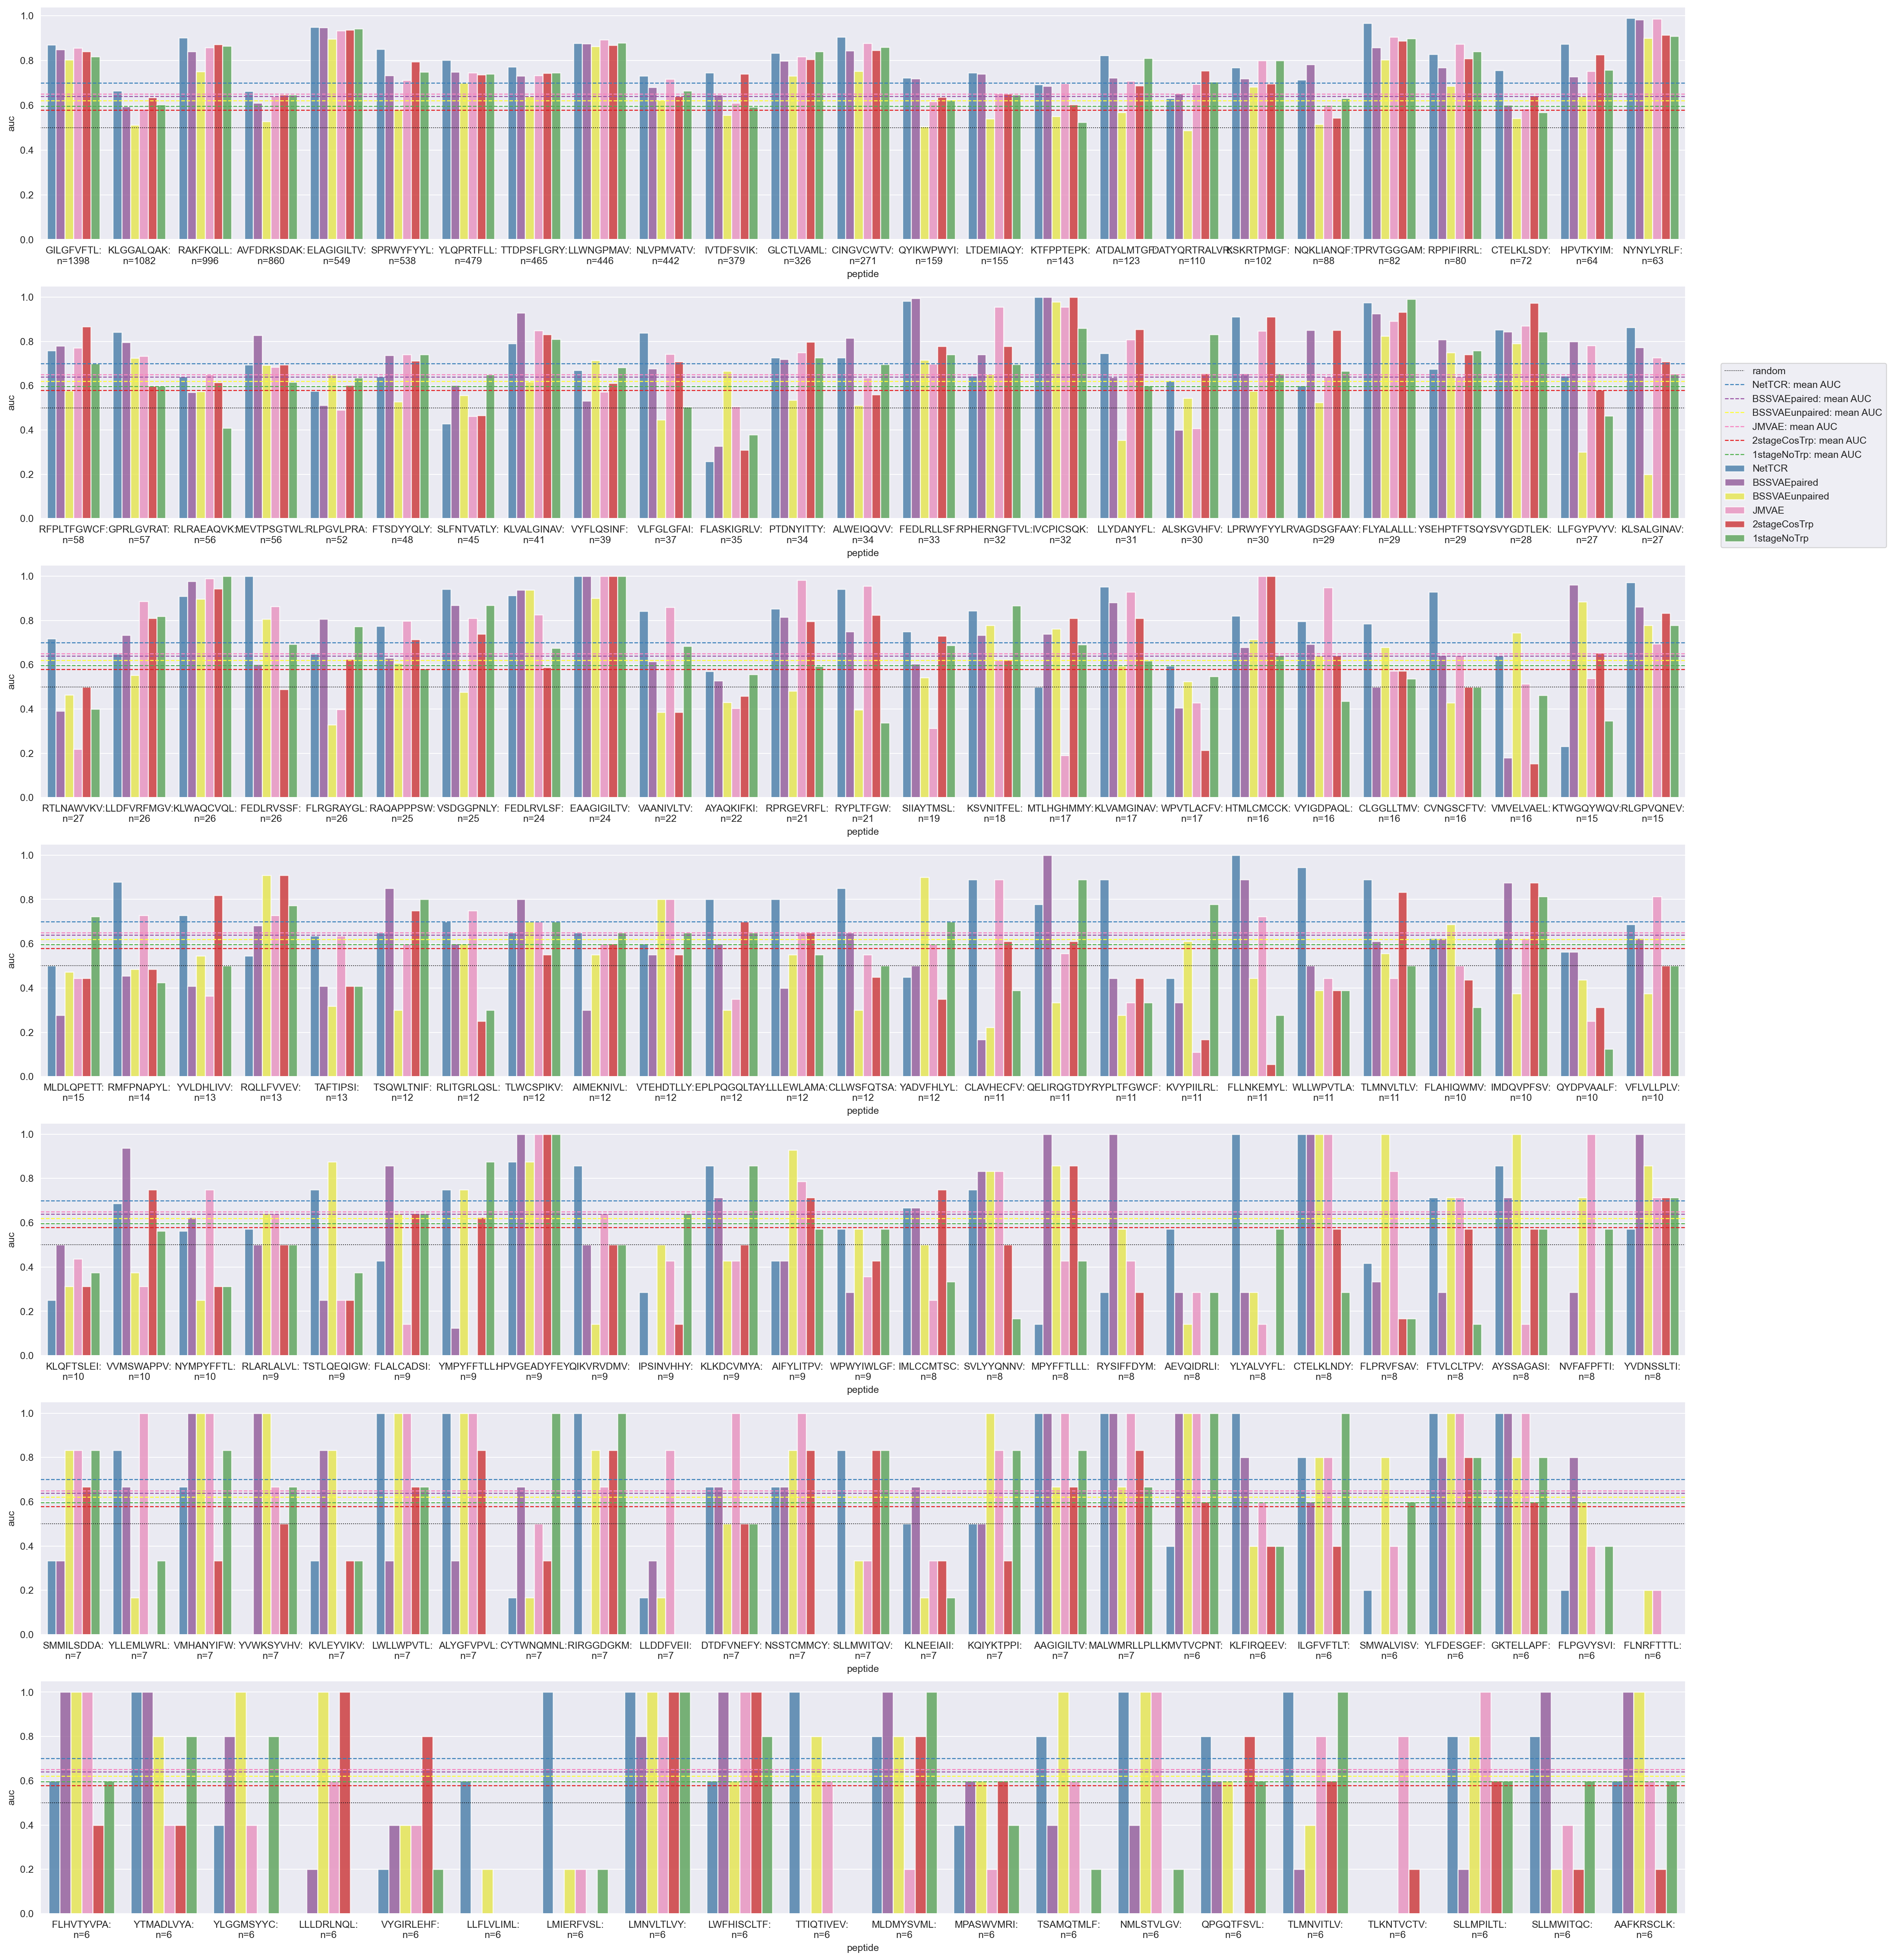

In [602]:
preds_list = [ntcr.query('partition==0').rename(columns={'prediction': 'pred_prob'}),
              pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/BEST_BSSVAE_PEPBLSM_Long25k_yOqyC6/valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240327_2240_yOqyC6.csv'),
              pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/BEST_BSSVAEup_LONG_ezI4Q3/valid_predictions_f00_BEST_3kEpochs_CC_PepBLSM_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1150_ezI4Q3.csv'),
              pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/BEST_JMVAE_PEPBLSM_Long25k_iUX7Lu/valid_predictions_f00_BEST_2p5kEpochs_CC_PepBLSM_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240327_1947_iUX7Lu.csv'),
              pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/BEST_OLD_2stage_CosTrp_DDDDDD/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_BEST_240326_1635_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240328_2000_DDDDDD.csv'),
              pd.read_csv('../output/240402_clf_logs_sorting/results_sorting/LAST_OLD_1stage_NoTrp_AAAAAA/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_LAST_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240328_1603_AAAAAA.csv')]
names_list = ['NetTCR', 'BSSVAEpaired', 'BSSVAEunpaired', 'JMVAE', '2stageCosTrp', '1stageNoTrp']
compare_per_pep_auc(preds_list, names_list, label_col, pred_col, 25)

# TCRBASE

## start

In [264]:
# For all the expanded peptide dataset : Compare old VAE (retrained on exp) models to the new MMVAE models
# For all the peptides in common with old dataset : Compare old VAE models (not retrained) to the new MMVAE models
# folders : 
#    OldVAE OldData: 240130_tcrbase_pepswap
#    OldVAE newData: 240403_oldExpVAE_TCRBASE
#    MMVAE newData: 240403_MMVAE_TCRBASE
old_df = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')
new_df = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')
oldpeps = sorted(old_df.peptide.unique())
newpeps = sorted(new_df.peptide.unique())

In [272]:
old_df.loc[[163]]

Unnamed: 0     A1       A2           A3     B1      B2            B3  \
163         163  TSINN  IRSNERE  ATDVGDTDKLI  MDHEN  SYDVKM  ASSSSDRGNEQF   

       peptide       allele           origin  binder  partition  \
163  ATDALMTGF  HLA-A*01:01  peptide_swapped       0          1   

    original_peptide  original_index  
163        KLGGALQAK            5022

In [280]:
for p in newpeps:
    query = new_df.query('peptide==@p and partition==0')[['A1','A2','A3','B1','B2','B3', 'original_peptide']]
    db = new_df.query('original_peptide==@p and partition!=0')[['A1','A2','A3','B1','B2','B3', 'original_peptide']]
    query.to_csv(f'../data/tcrbase_expanded_p0_swapped/{p}_query_p0.tsv', sep='\t', header=False)
    db.to_csv(f'../data/tcrbase_expanded_p0_swapped/{p}_db_p0.tsv', sep='\t', header=False)

In [672]:
def read_tcrbase_results(peptide, original_df, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
_, _ = read_tcrbase_results('ELAGIGILTV', new_df)

ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}


In [673]:
tcrbase_fulltcr_results = pd.DataFrame([read_tcrbase_results(p, new_df, 
                                                             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_expanded_p0_swapped/')[0] \
                                        for p in newpeps])
tcrbase_cdr3_results = pd.DataFrame([read_tcrbase_results(p, new_df, 
                                                          '../output/240405_SelectedVAEs_TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/')[0] \
                                     for p in newpeps])
    

AAFKRSCLK 0.2
{'peptide': 'AAFKRSCLK', 'method': 'tcrbase', 'n_pos': 11, 'auc': 0.2, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.2}
AAGIGILTV 1.0
{'peptide': 'AAGIGILTV', 'method': 'tcrbase', 'n_pos': 6, 'auc': 1.0, 'auc_01': 1.0, 'auc_01_real': 1.0, 'precision': 0.14286, 'recall': 1.0, 'accuracy': 0.14286, 'AP': 1.0}
AEVQIDRLI 0.1429
{'peptide': 'AEVQIDRLI', 'method': 'tcrbase', 'n_pos': 13, 'auc': 0.14286, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.125, 'recall': 1.0, 'accuracy': 0.125, 'AP': 0.14286}
AIFYLITPV 0.0
{'peptide': 'AIFYLITPV', 'method': 'tcrbase', 'n_pos': 12, 'auc': 0.0, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.22222, 'recall': 1.0, 'accuracy': 0.22222, 'AP': 0.17361}
AIMEKNIVL 0.75
{'peptide': 'AIMEKNIVL', 'method': 'tcrbase', 'n_pos': 10, 'auc': 0.75, 'auc_01': 0.73684, 'auc_01_real': 0.5, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.64286}
ALSKGVHFV 0.576
{'pepti

In [674]:
tcrbase_fulltcr_results.to_csv('../output/240405_SelectedVAEs_TCRBASE/tcrbase_fulltcr_results.csv')
tcrbase_cdr3_results.to_csv('../output/240405_SelectedVAEs_TCRBASE/tcrbase_cdr3_results.csv')

In [682]:
tcrbase_fulltcr_results.sort_values('n_pos',ascending=False)

peptide   method  n_pos      auc   auc_01  auc_01_real  precision  \
54    KLGGALQAK  tcrbase   1130  0.61030  0.55241      0.14958    0.16728   
40    GILGFVFTL  tcrbase   1095  0.80299  0.71910      0.46628    0.16667   
104    RAKFKQLL  tcrbase    945  0.88051  0.80623      0.63184    0.16667   
9    AVFDRKSDAK  tcrbase    752  0.48551  0.50745      0.06416    0.16628   
142  TTDPSFLGRY  tcrbase    535  0.68187  0.61969      0.27741    0.16774   
..          ...      ...    ...      ...      ...          ...        ...   
153   VYGIRLEHF  tcrbase      2  0.40000  0.47368      0.00000    0.16667   
33    FLNRFTTTL  tcrbase      2  0.80000  0.47368      0.00000    0.16667   
47    ILGFVFTLT  tcrbase      2  0.80000  0.47368      0.00000    0.16667   
129   SMWALVISV  tcrbase      2  1.00000  1.00000      1.00000    0.16667   
62    KMVTVCPNT  tcrbase      2  1.00000  1.00000      1.00000    0.16667   

     recall  accuracy       AP  
54      1.0   0.16728  0.29468  
40      1.0   0.16667  0.57919  
104     1.0   0.16667  0.76444  
9       1.0   0.16628  0.18505  
142     1.0   0.16774  0.44064  
..      ...       ...      ...  
153     1.0   0.16667  0.25000  
33      1.0   0.16667  0.50000  
47      1.0   0.16667  0.50000  
129     1.0   0.16667  1.00000  
62      1.0   0.16667  1.00000  

[170 rows x 10 columns]

In [679]:
tcrbase_cdr3_results.sort_values('n_pos',ascending=False)

peptide   method  n_pos      auc   auc_01  auc_01_real  precision  \
54    KLGGALQAK  tcrbase   1130  0.57394  0.54190      0.12961    0.16728   
40    GILGFVFTL  tcrbase   1095  0.74746  0.68567      0.40277    0.16667   
104    RAKFKQLL  tcrbase    945  0.86179  0.78016      0.58231    0.16667   
9    AVFDRKSDAK  tcrbase    752  0.49443  0.50721      0.06371    0.16628   
142  TTDPSFLGRY  tcrbase    535  0.59273  0.55602      0.15643    0.16774   
..          ...      ...    ...      ...      ...          ...        ...   
153   VYGIRLEHF  tcrbase      2  0.20000  0.47368      0.00000    0.16667   
33    FLNRFTTTL  tcrbase      2  0.80000  0.47368      0.00000    0.16667   
47    ILGFVFTLT  tcrbase      2  0.80000  0.47368      0.00000    0.16667   
129   SMWALVISV  tcrbase      2  0.60000  0.47368      0.00000    0.16667   
62    KMVTVCPNT  tcrbase      2  1.00000  1.00000      1.00000    0.16667   

     recall  accuracy       AP  
54      1.0   0.16728  0.24869  
40      1.0   0.16667  0.50236  
104     1.0   0.16667  0.71408  
9       1.0   0.16628  0.18310  
142     1.0   0.16774  0.31756  
..      ...       ...      ...  
153     1.0   0.16667  0.20000  
33      1.0   0.16667  0.50000  
47      1.0   0.16667  0.50000  
129     1.0   0.16667  0.33333  
62      1.0   0.16667  1.00000  

[170 rows x 10 columns]

In [685]:
tcrbase_fulltcr_results.query('n_pos>10').auc.mean(), tcrbase_cdr3_results.query('n_pos>10').auc.mean()

(0.6377700877192983, 0.6137547368421054)

In [324]:
tcrbase_results.sort_values('auc',ascending=False).auc.mean()

0.5999243529411764

In [327]:
pd.read_csv(glob.glob('../output/240403_MMVAE_TCRBASE/tcrbase_240321_1427_BSSVAE_addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1119_VoZuWy/*ELAGIGILTV*.csv')[0])

Unnamed: 0  min_dist  \
0       DRGSQSIYSNGDAVGGGGADGLTLGHNAYNFKEQASSQAQLNTEAF  0.022875   
1    YGGTVNYFSGDPLVAVPNTNAGKSTSGHNTYYREEEASTLRGTGVETQY  0.151205   
2        DRGSQSIYSNGDAVDARLMMNHNYSVGAGIASSPLSRQGGTGELF  0.084667   
3         DRGSQSIYSNGDAWKSNQFYLGHNAYNFKEQASSQELLSSGELF  0.002661   
4        DRGSQSIYSNGDAGGDDKIIDFQATTSNEGSKASASRTGLGQPQH  0.050156   
..                                                 ...       ...   
544  TTSDRLLSNGAVAVAMEYGNKLVDFQATTSNEGSKASATYPRQGYYEQY  0.191584   
545     SVFSSVVTGGEVAGAQDNAGNMLTLNHDASQIVNDASSIRAAYEQY  0.115585   
546        TSGFNGNVLDGLAVRRAGNDMRSGDLSYYNGEEASSGTNSPLH  0.048796   
547      NSASDYIRSNMDKAAPRGGQNFVLNHDASQIVNDASSIRSSDEQF  0.130058   
548    YGATPYYFSGDTLVAVGDNFNKFYMDHENSYDVKMASSLSSATGELF  0.308065   

                                         most_similar  label  
0      DRGSQSIYSNGDAVGGGGADGLTLNHDASQIVNDASSLTGLNTEAF      1  
1    ATGYPSATKADDKALRNTGGFKTIMNHEYSMNVEVASRKDWQNTGELF      1  
2        DRGSQSIYSNGDAVNDQFYSGHNTYYREEEASSPGQLLMNTEAF      1  
3        DRGSQSIYSNGDAVNNARLMLGHNAYNFKEQASSHGGSNTGELF      1  
4         DRGSQSIYSNGDAARNYQLIMNHEYSVGEGTASSTGTGGDGYT      1  
..                                                ...    ...  
544  ATGYPSATKADDKALRNTGGFKTIMNHEYSMNVEVASRKDWQNTGELF      0  
545   DSAIYNIQSSQREDRGRGTSYDKVIMNHEYSVGEGTASTLGEGSEAF      0  
546       DRGSQSIYSNGDAVSGGADGLTSGHDYFNNNVPASSLGGNEQF      0  
547      DRGSQSIYSNGDAVNKDFNKFYMNHEYSVGEGTASSAGGSNEQF      0  
548    TTLSNLVKSGEVAIASGGYQKVTSGHTAFQGNSAASSRRMNNNEQF      0  

[549 rows x 4 columns]

In [686]:
def read_tcrvae_results(peptide, original_df, dir):
    csv_file = glob.glob(f'{dir}*{peptide}*.csv')[0]
    df = pd.read_csv(csv_file)
    df['binder']=df['label']
    df['score'] = 1- df['min_dist']
    metrics = {'peptide':peptide, 'method':'_'.join(os.path.basename(csv_file).split('_')[5:]), 
               'n_pos':len(original_df.query('original_peptide==@peptide and partition==0 and binder==0'))}
    metrics.update(get_metrics(df['label'], df['score']))
    return metrics, df

In [820]:
ntr = []
for f in glob.glob('../output/240403_MMVAE_TCRBASE/*/'):
    for p in newpeps:
        ntr.append(read_tcrvae_results(p, new_df, f)[0])

old = []
for f in glob.glob('../output/240403_oldExpVAE_TCRBASE/*/'):
    for p in newpeps:
        old.append(read_tcrvae_results(p, new_df, f)[0])

In [821]:
import pandas as pd
import numpy as np
old = pd.DataFrame(old)
ntr = pd.DataFrame(ntr)
tcrbase_results['method'] = 'TCRBase'
cat = pd.concat([tcrbase_results, old, ntr])
cat['weight'] = cat['peptide'].apply(lambda x: len(new_df.query('peptide==@x')) / len(new_df))

# Define a function to calculate the multiple operations
def calculate_metrics(x):
    normal_avg_auc = x['auc'].mean()
    weighted_avg_auc = np.average(x['auc'], weights=x['weight'])
    normal_avg_auc_01 = x['auc_01'].mean()
    weighted_avg_auc_01 = np.average(x['auc_01'], weights=x['weight'])
    return pd.Series({
        'normal_avg_auc': normal_avg_auc,
        'weighted_avg_auc': weighted_avg_auc,
        'normal_avg_auc_01': normal_avg_auc_01,
        'weighted_avg_auc_01': weighted_avg_auc_01
    })

# Group by the 'group' column and apply the custom calculation function
result = cat.groupby('method').apply(calculate_metrics).reset_index()

result.sort_values('normal_avg_auc',ascending=False)


method  \
6                                                                 _NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA.csv   
1                       _BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6.csv   
9               _addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_IzcVOH.csv   
8                  _addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1119_VoZuWy.csv   
0                                                                                                                      TCRBase   
12  _addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_hRmUHn.csv   
2                                                                _CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD.csv   
5                                                                  _NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1519_CCCCC.csv   
10             _addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu.csv   
13                                  _allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3.csv   
11     _addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1118_syos6U.csv   
3                                                                _CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1515_BBBBBB.csv   
7                  _addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1118_ANzj8c.csv   
4                        _JMVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_zR6ccN.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  
6         0.638832          0.714888           0.632249             0.658201  
1         0.603153          0.663069           0.598095             0.617709  
9         0.601331          0.659534           0.600154             0.619507  
8         0.600569          0.662330           0.598828             0.617376  
0         0.599924          0.711555           0.640614             0.676051  
12        0.598799          0.662231           0.593117             0.617151  
2         0.597390          0.714918           0.605866             0.667064  
5         0.597180          0.707614           0.622514             0.664995  
10        0.589642          0.659179           0.581071             0.627684  
13        0.586124          0.653888           0.587949             0.630446  
11        0.582171          0.651234           0.579670             0.627033  
3         0.581582          0.677269           0.617081             0.645797  
7         0.580411          0.657543           0.577328             0.626138  
4         0.577606          0.657673           0.577119             0.627417

In [822]:
result.sort_values('weighted_avg_auc_01', ascending=False)

method  \
0                                                                                                                      TCRBase   
2                                                                _CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD.csv   
5                                                                  _NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1519_CCCCC.csv   
6                                                                 _NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA.csv   
3                                                                _CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1515_BBBBBB.csv   
13                                  _allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3.csv   
10             _addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu.csv   
4                        _JMVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_zR6ccN.csv   
11     _addlencTrue_addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1118_syos6U.csv   
7                  _addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1118_ANzj8c.csv   
9               _addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_IzcVOH.csv   
1                       _BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6.csv   
8                  _addldecTrue_bnTrue_2p5kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1119_VoZuWy.csv   
12  _addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_hRmUHn.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  
0         0.599924          0.711555           0.640614             0.676051  
2         0.597390          0.714918           0.605866             0.667064  
5         0.597180          0.707614           0.622514             0.664995  
6         0.638832          0.714888           0.632249             0.658201  
3         0.581582          0.677269           0.617081             0.645797  
13        0.586124          0.653888           0.587949             0.630446  
10        0.589642          0.659179           0.581071             0.627684  
4         0.577606          0.657673           0.577119             0.627417  
11        0.582171          0.651234           0.579670             0.627033  
7         0.580411          0.657543           0.577328             0.626138  
9         0.601331          0.659534           0.600154             0.619507  
1         0.603153          0.663069           0.598095             0.617709  
8         0.600569          0.662330           0.598828             0.617376  
12        0.598799          0.662231           0.593117             0.617151

In [737]:
def make_3_plots(peptide, original_df, dir_old, dir_new,
                 name_old=None, name_new=None, bins =100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, '../output/TCRBASE/tcrbase_expanded_p0_swapped/')
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    
    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'TCRBase\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()

### GIL

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


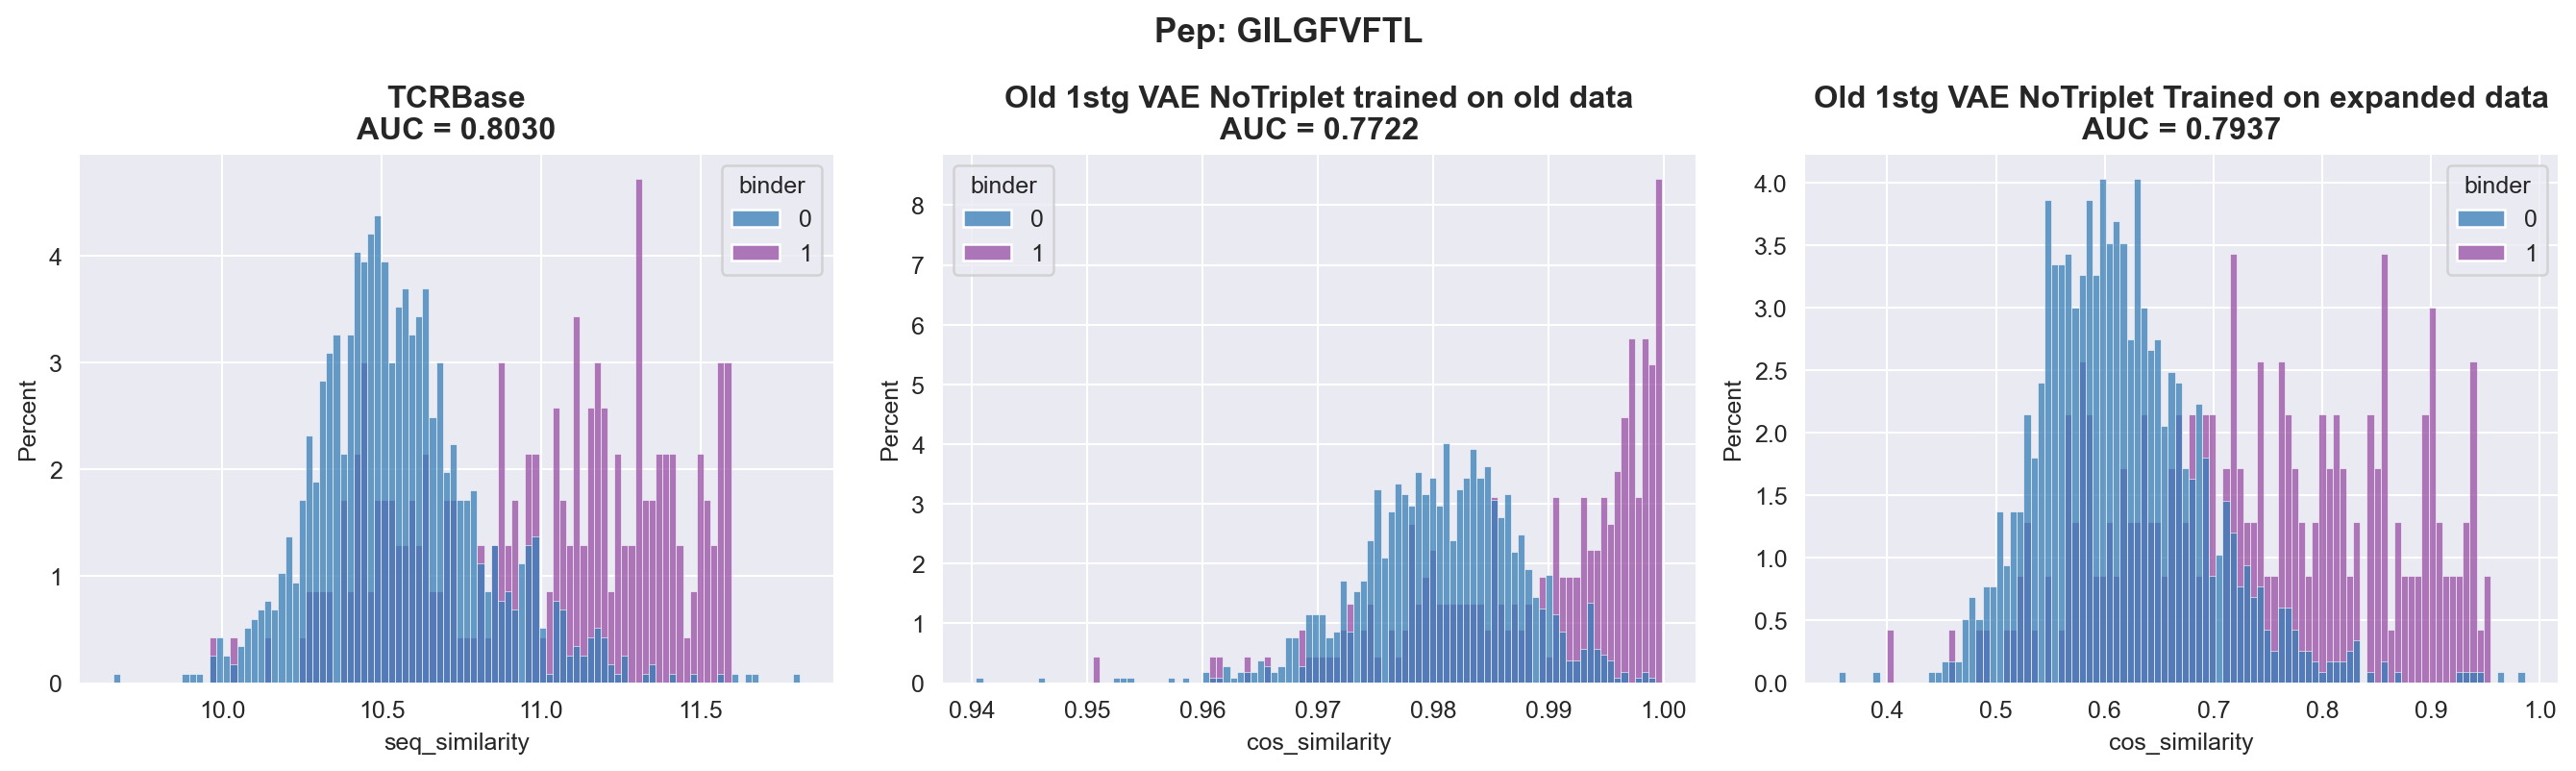

In [448]:
make_3_plots('GILGFVFTL', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


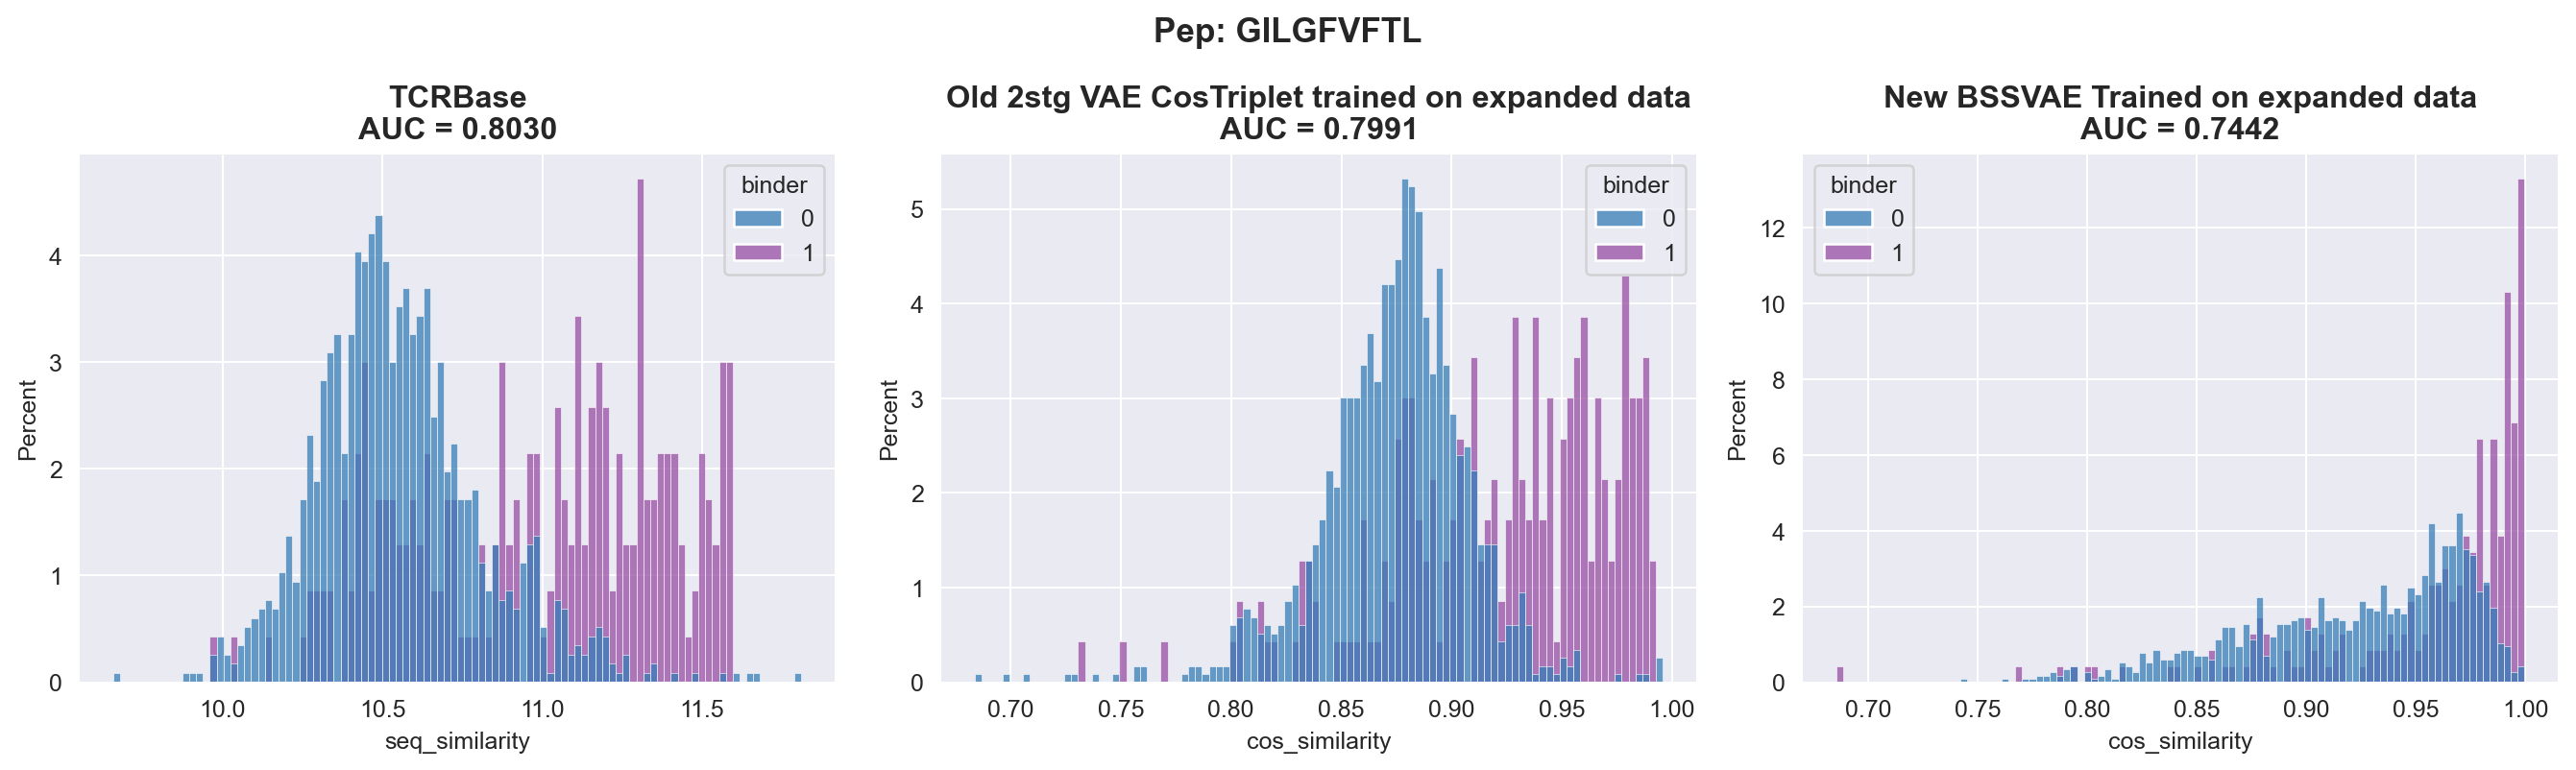

In [449]:
make_3_plots('GILGFVFTL', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on expanded data')

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}
GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}
GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


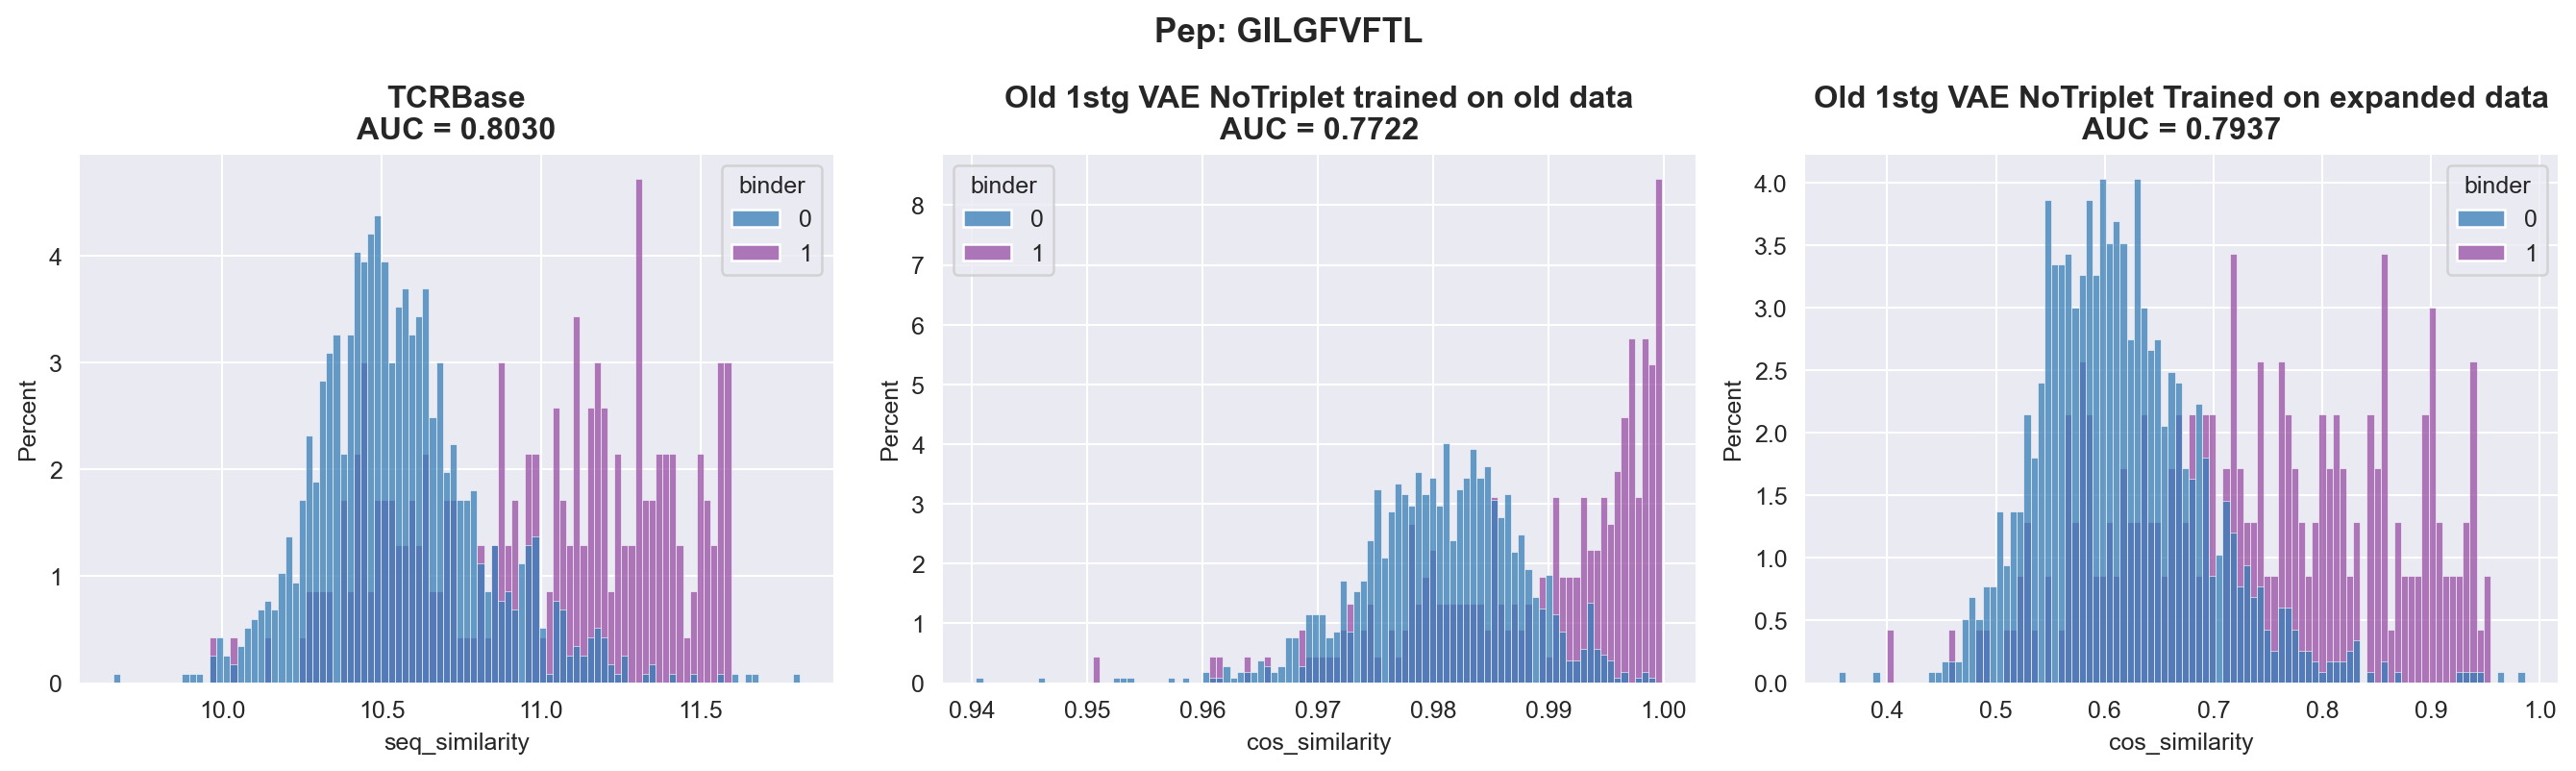

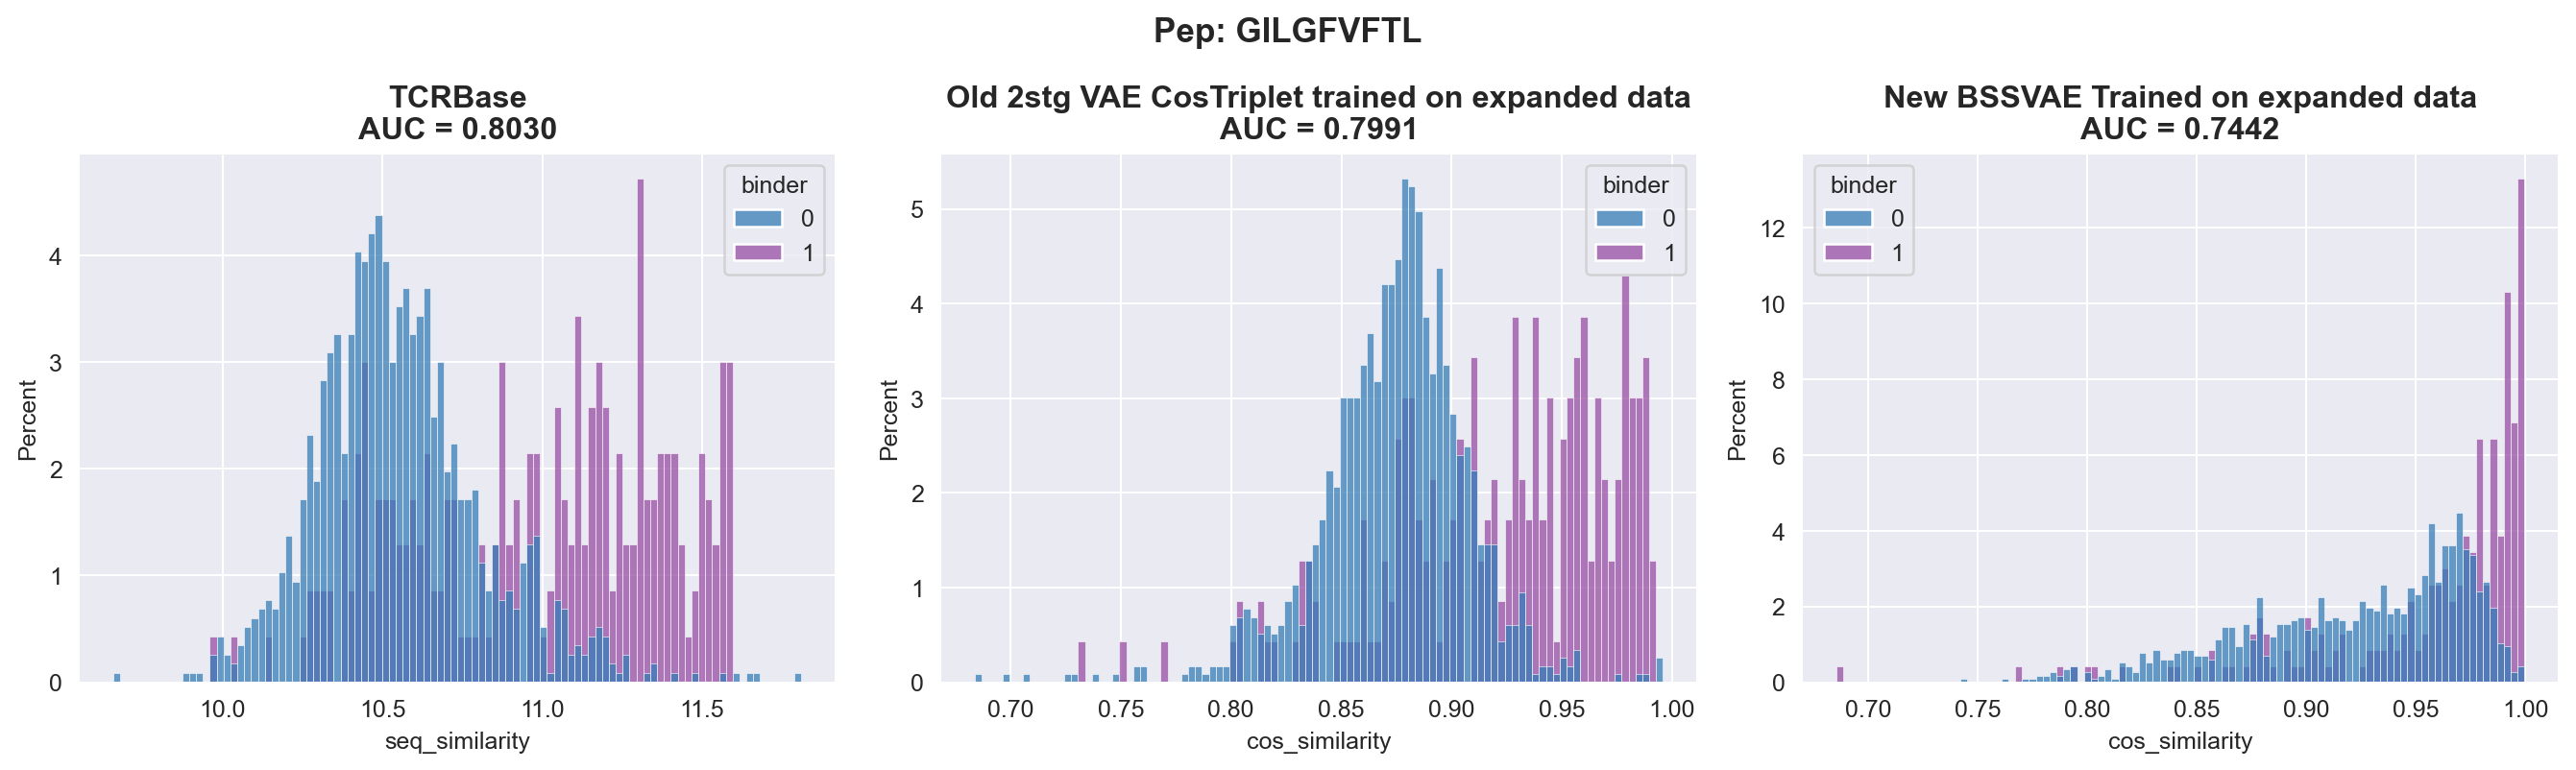

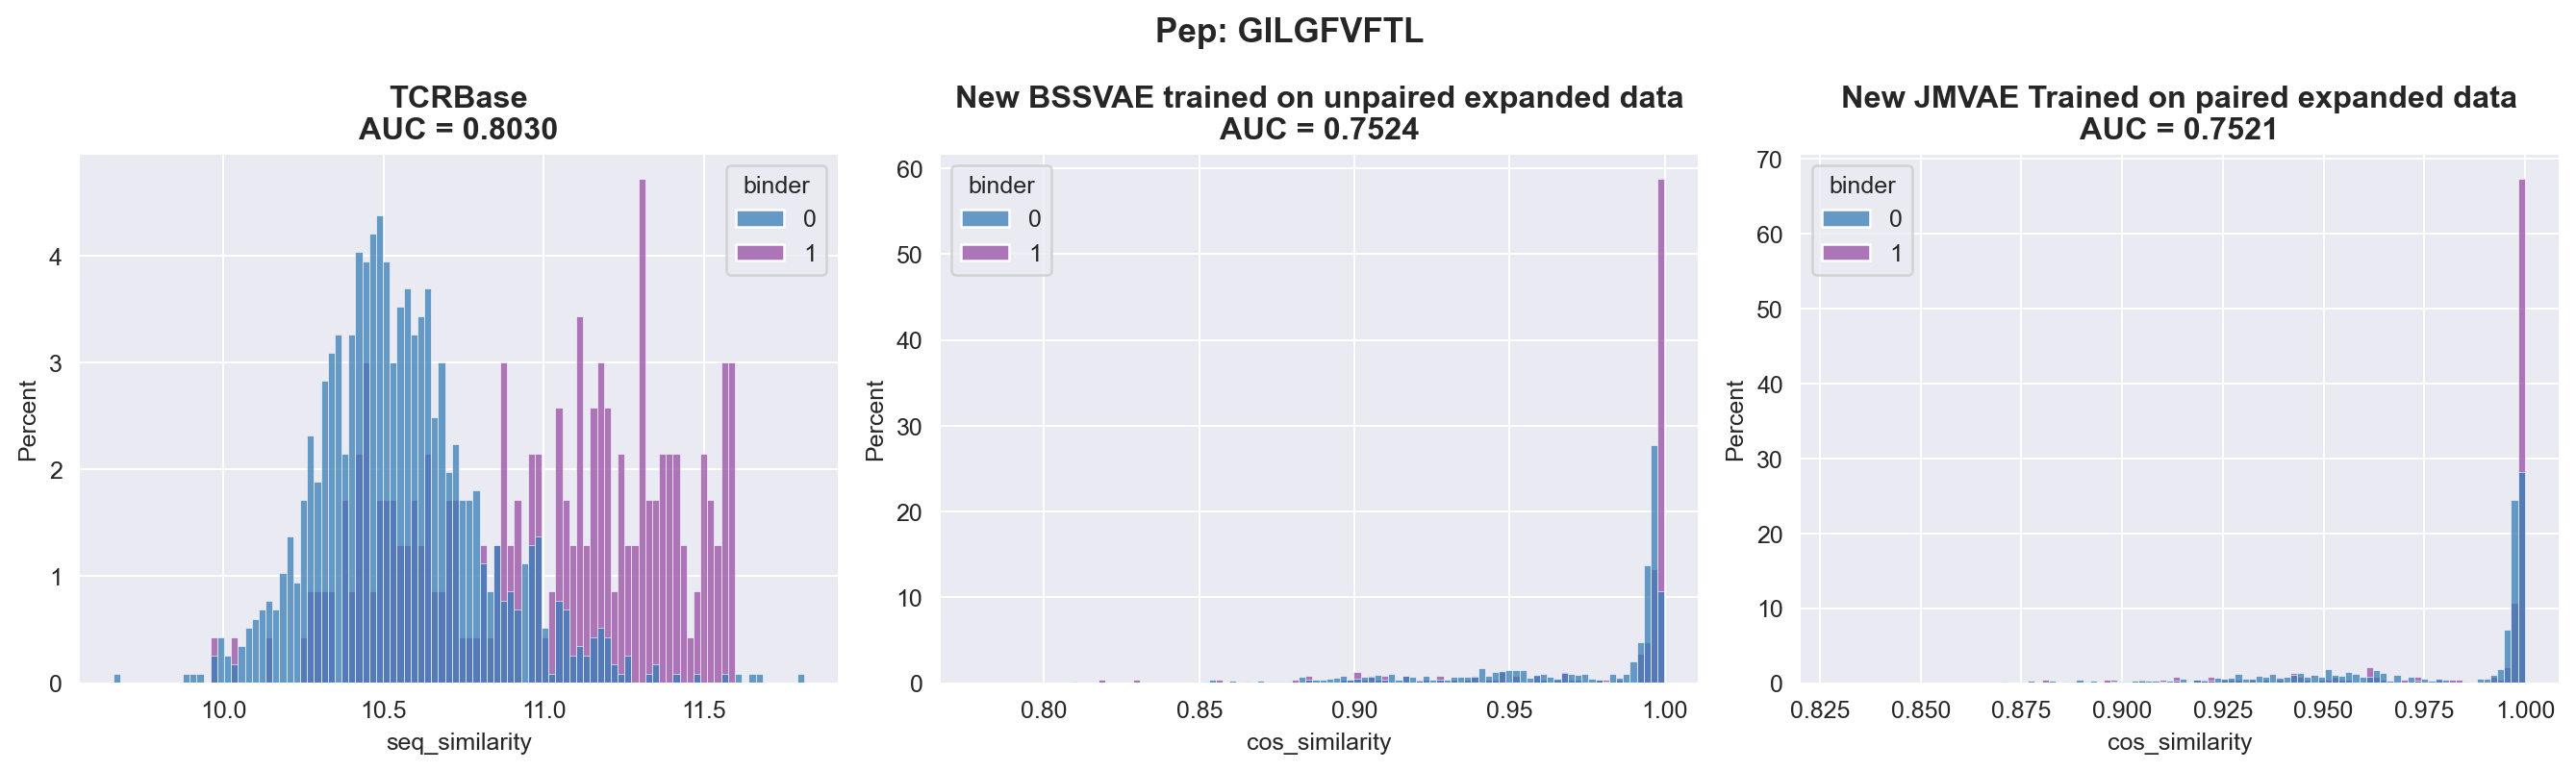

In [462]:
make_3_plots('GILGFVFTL', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')
make_3_plots('GILGFVFTL', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on expanded data')
make_3_plots('GILGFVFTL', new_df, 
             '../output/240403_MMVAE_TCRBASE/tcrbase_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu/',
             'New BSSVAE trained on unpaired expanded data',
             'New JMVAE Trained on paired expanded data')

### ELA

ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}


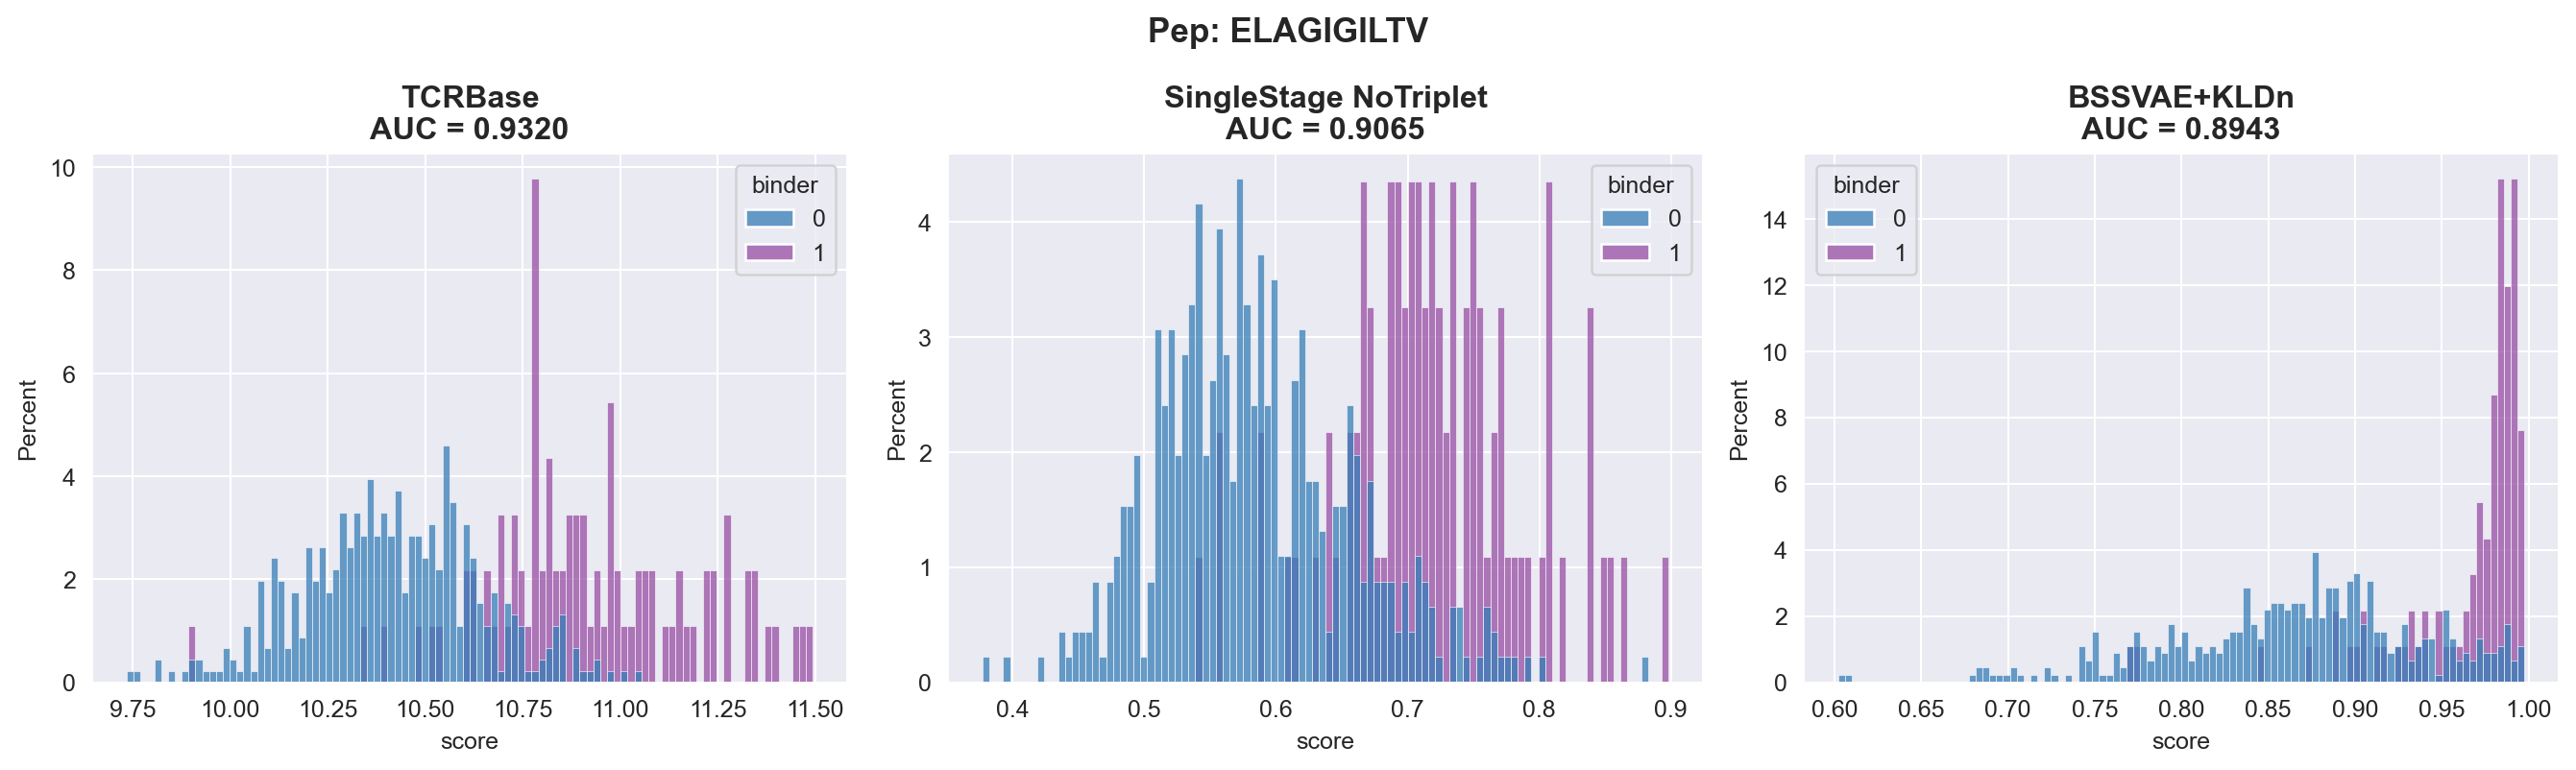

In [439]:
make_3_plots('ELAGIGILTV', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'SingleStage NoTriplet', 'BSSVAE+KLDn')

ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}


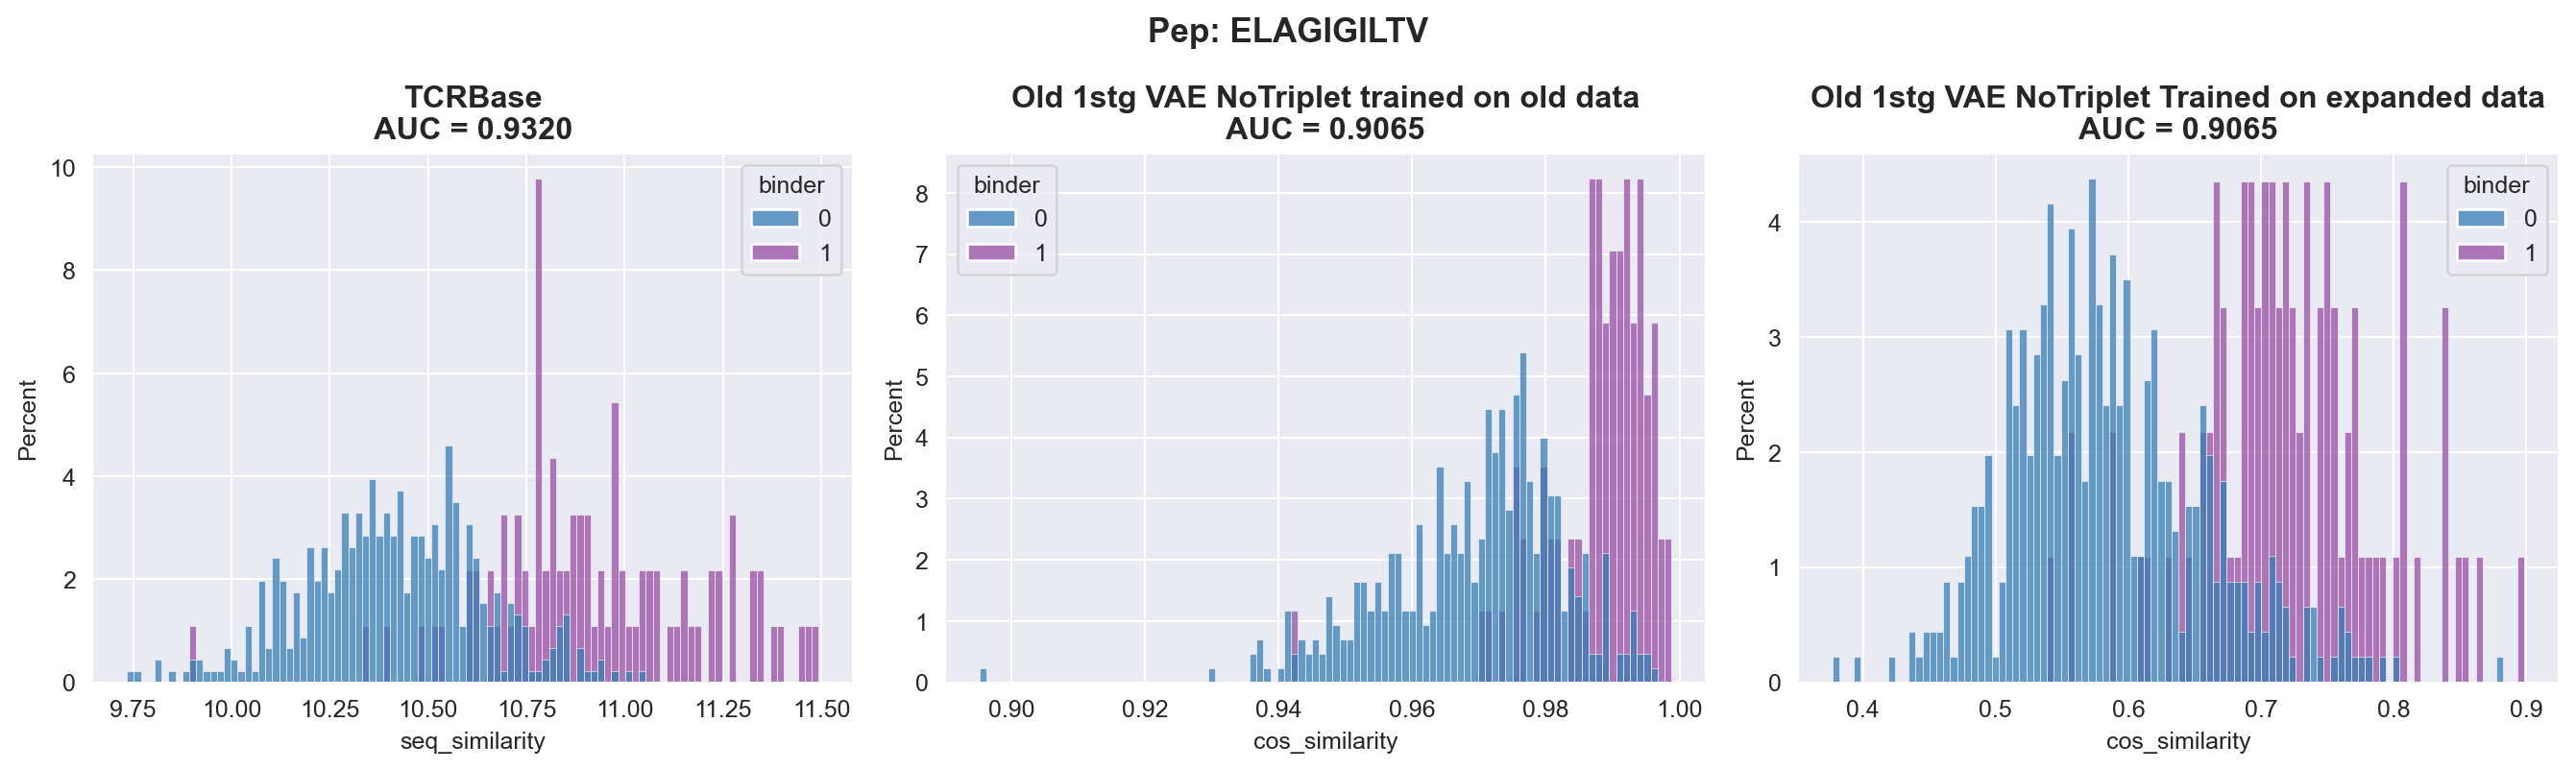

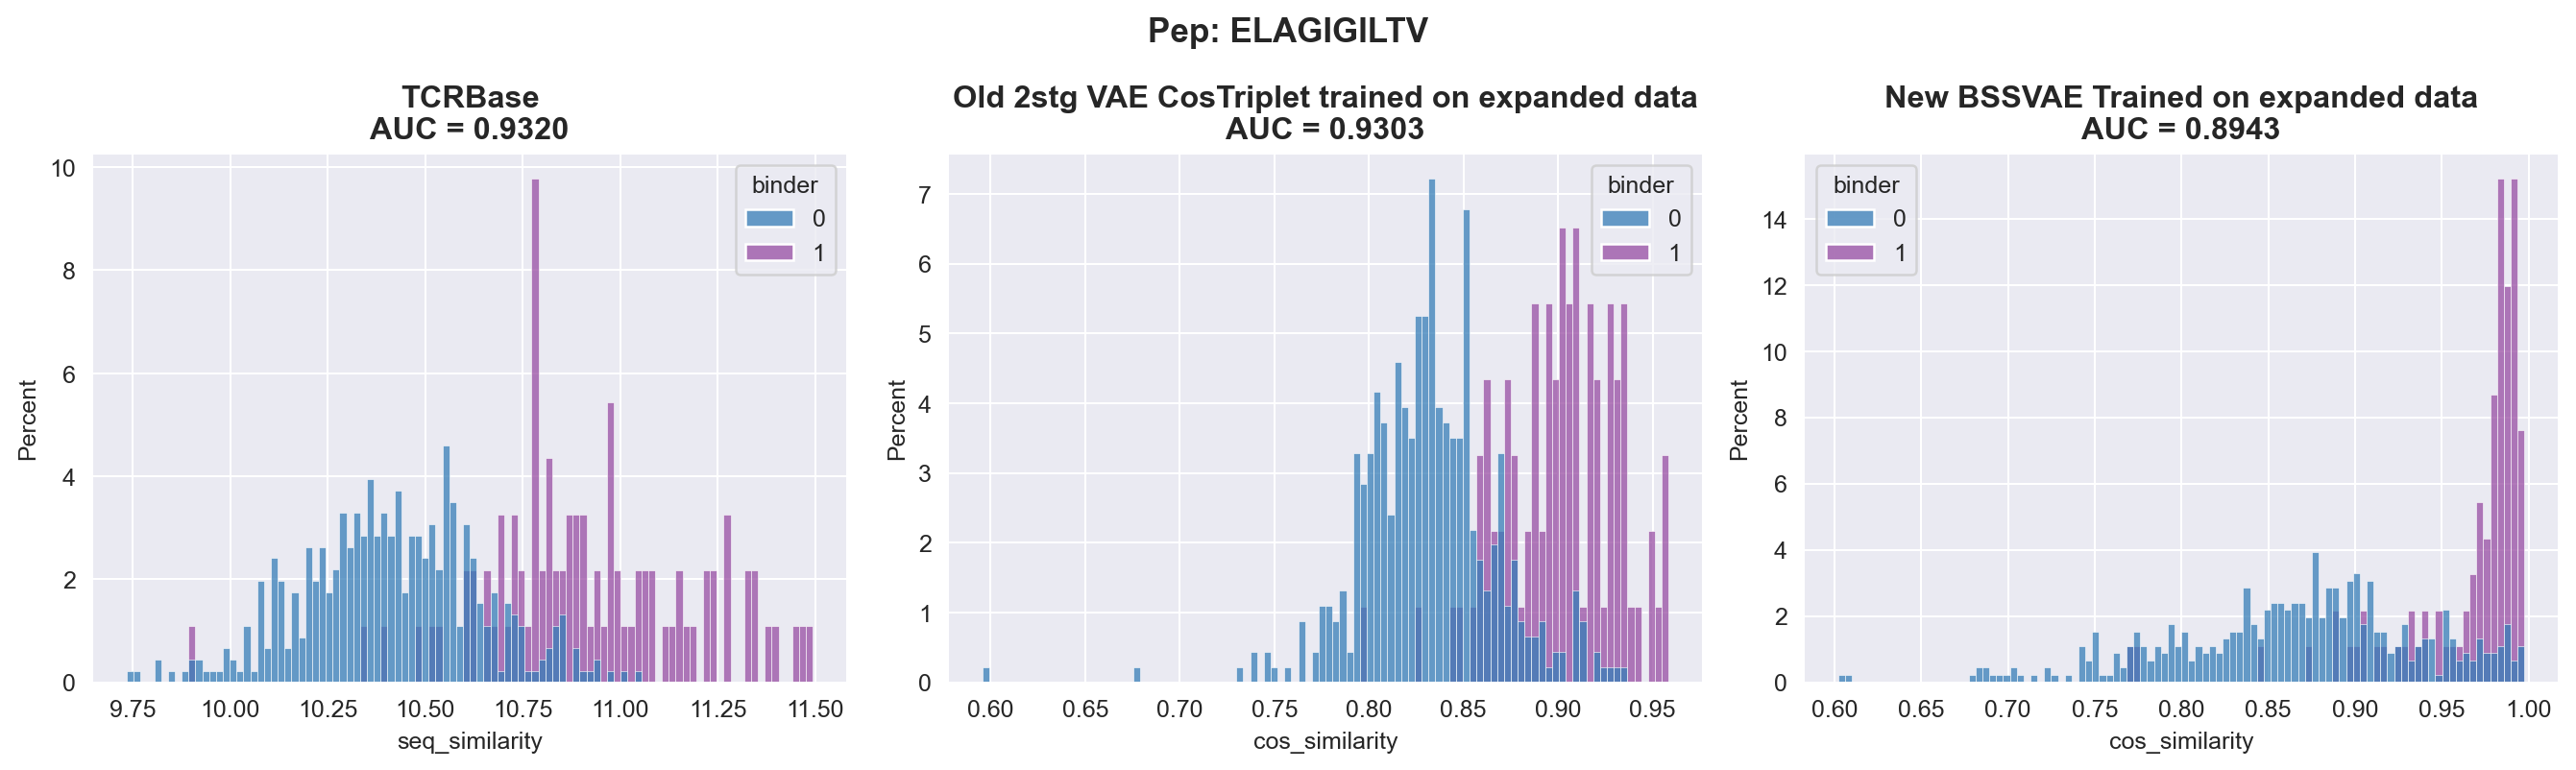

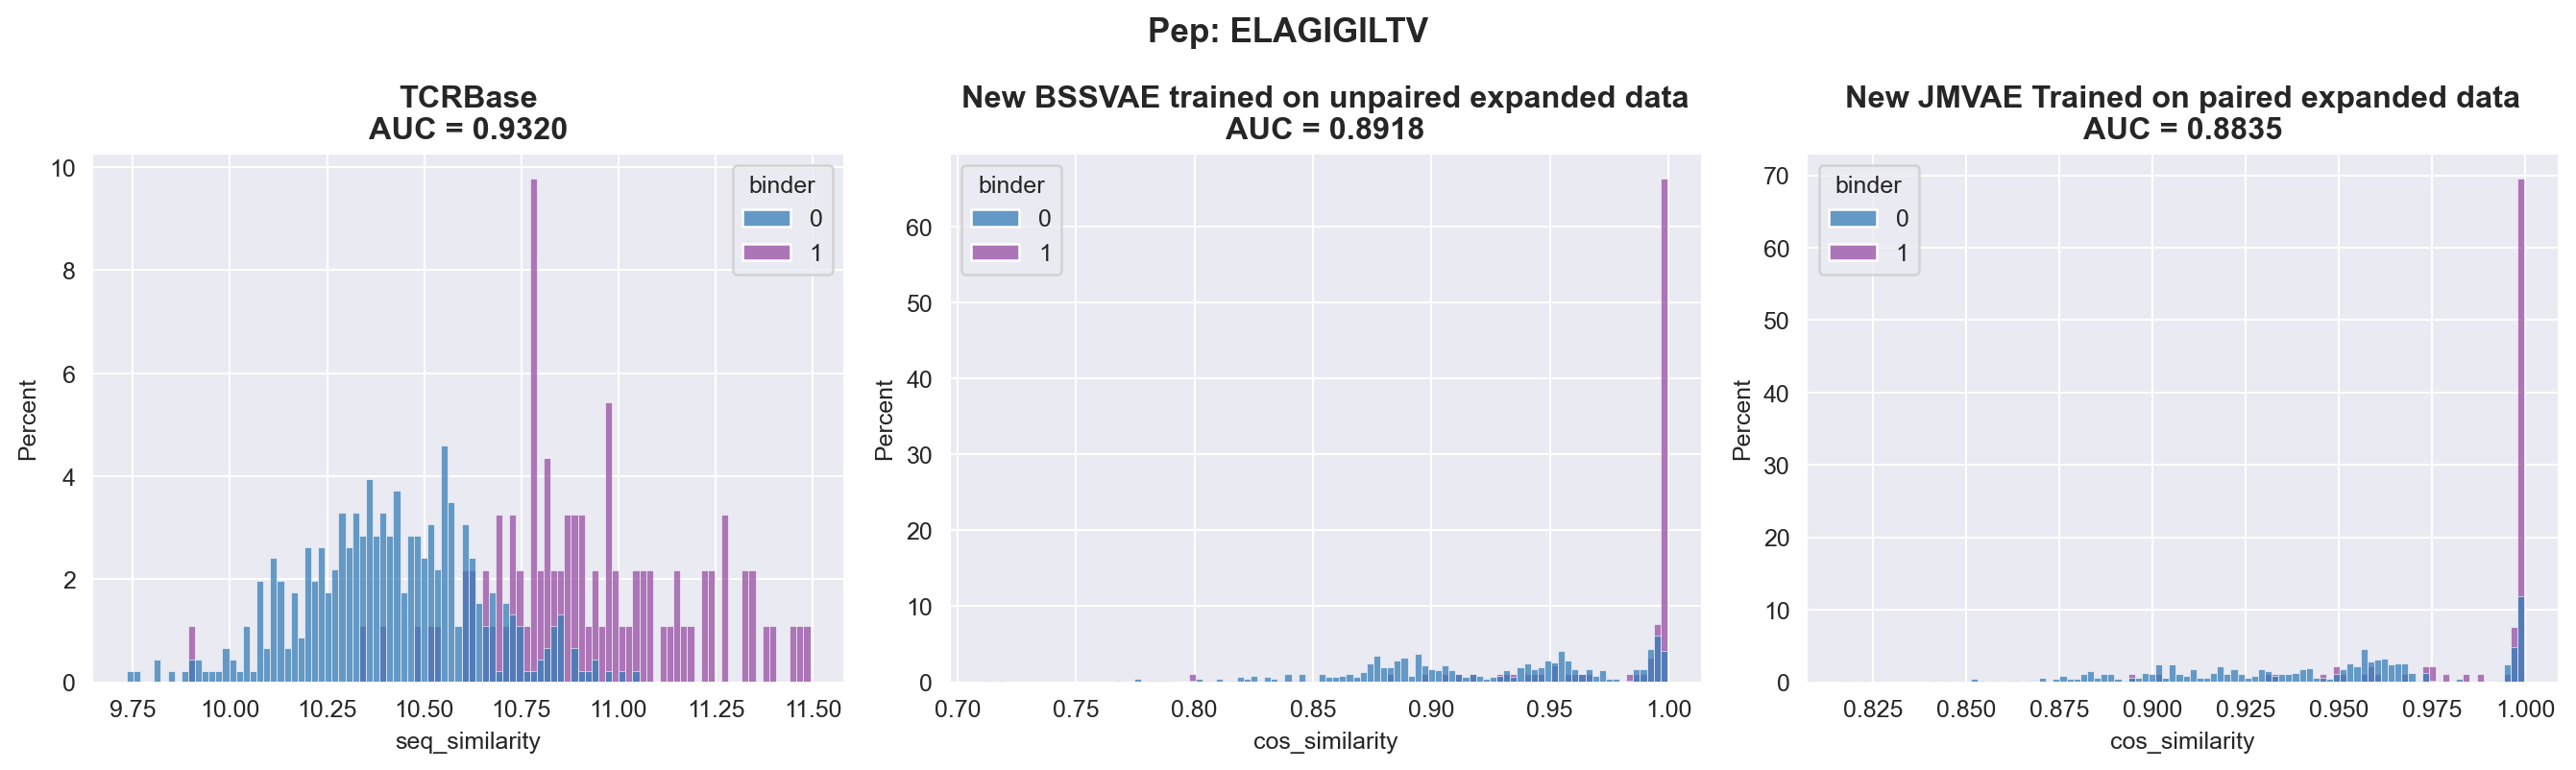

In [461]:
make_3_plots('ELAGIGILTV', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')
make_3_plots('ELAGIGILTV', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on expanded data')
make_3_plots('ELAGIGILTV', new_df, 
             '../output/240403_MMVAE_TCRBASE/tcrbase_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu/',
             'New BSSVAE trained on unpaired expanded data',
             'New JMVAE Trained on paired expanded data')

### nlvp

NLVPMVATV 0.69
{'peptide': 'NLVPMVATV', 'method': 'tcrbase', 'n_pos': 421, 'auc': 0.69003, 'auc_01': 0.65184, 'auc_01_real': 0.3385, 'precision': 0.16742, 'recall': 1.0, 'accuracy': 0.16742, 'AP': 0.49353}
NLVPMVATV 0.69
{'peptide': 'NLVPMVATV', 'method': 'tcrbase', 'n_pos': 421, 'auc': 0.69003, 'auc_01': 0.65184, 'auc_01_real': 0.3385, 'precision': 0.16742, 'recall': 1.0, 'accuracy': 0.16742, 'AP': 0.49353}
NLVPMVATV 0.69
{'peptide': 'NLVPMVATV', 'method': 'tcrbase', 'n_pos': 421, 'auc': 0.69003, 'auc_01': 0.65184, 'auc_01_real': 0.3385, 'precision': 0.16742, 'recall': 1.0, 'accuracy': 0.16742, 'AP': 0.49353}


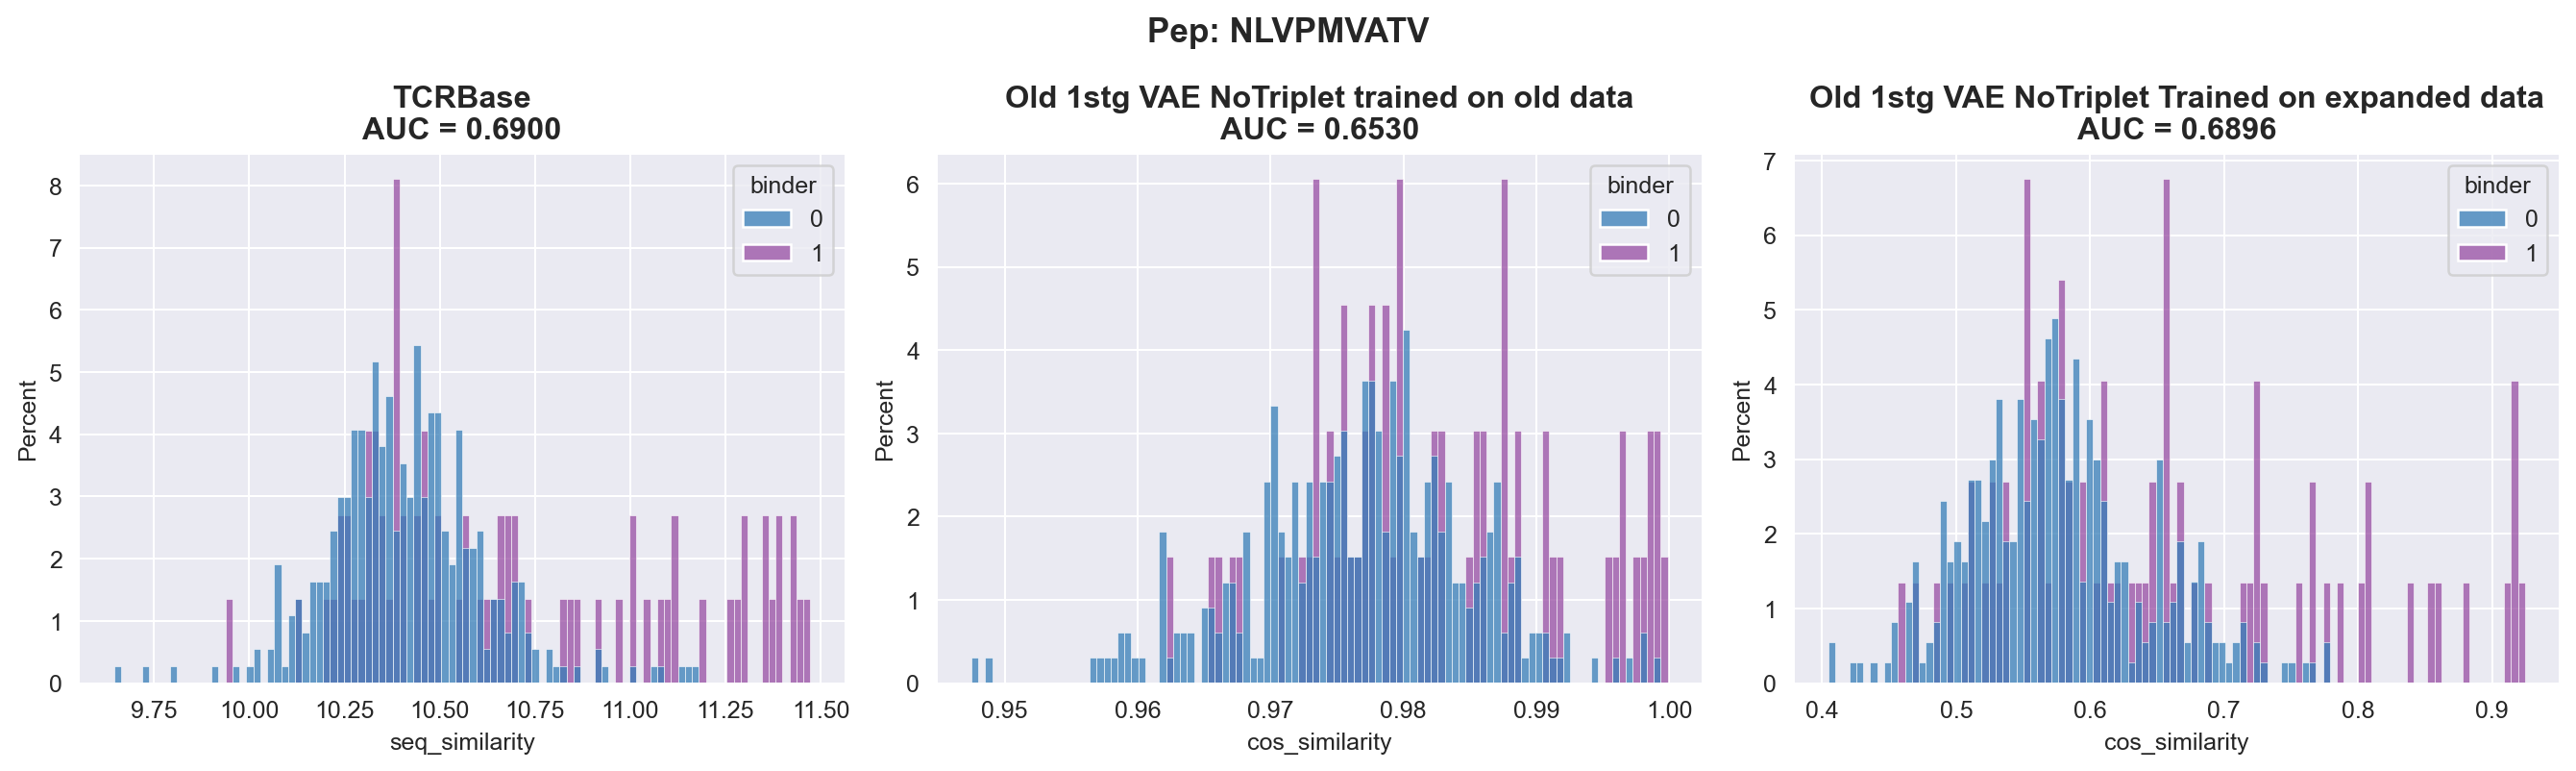

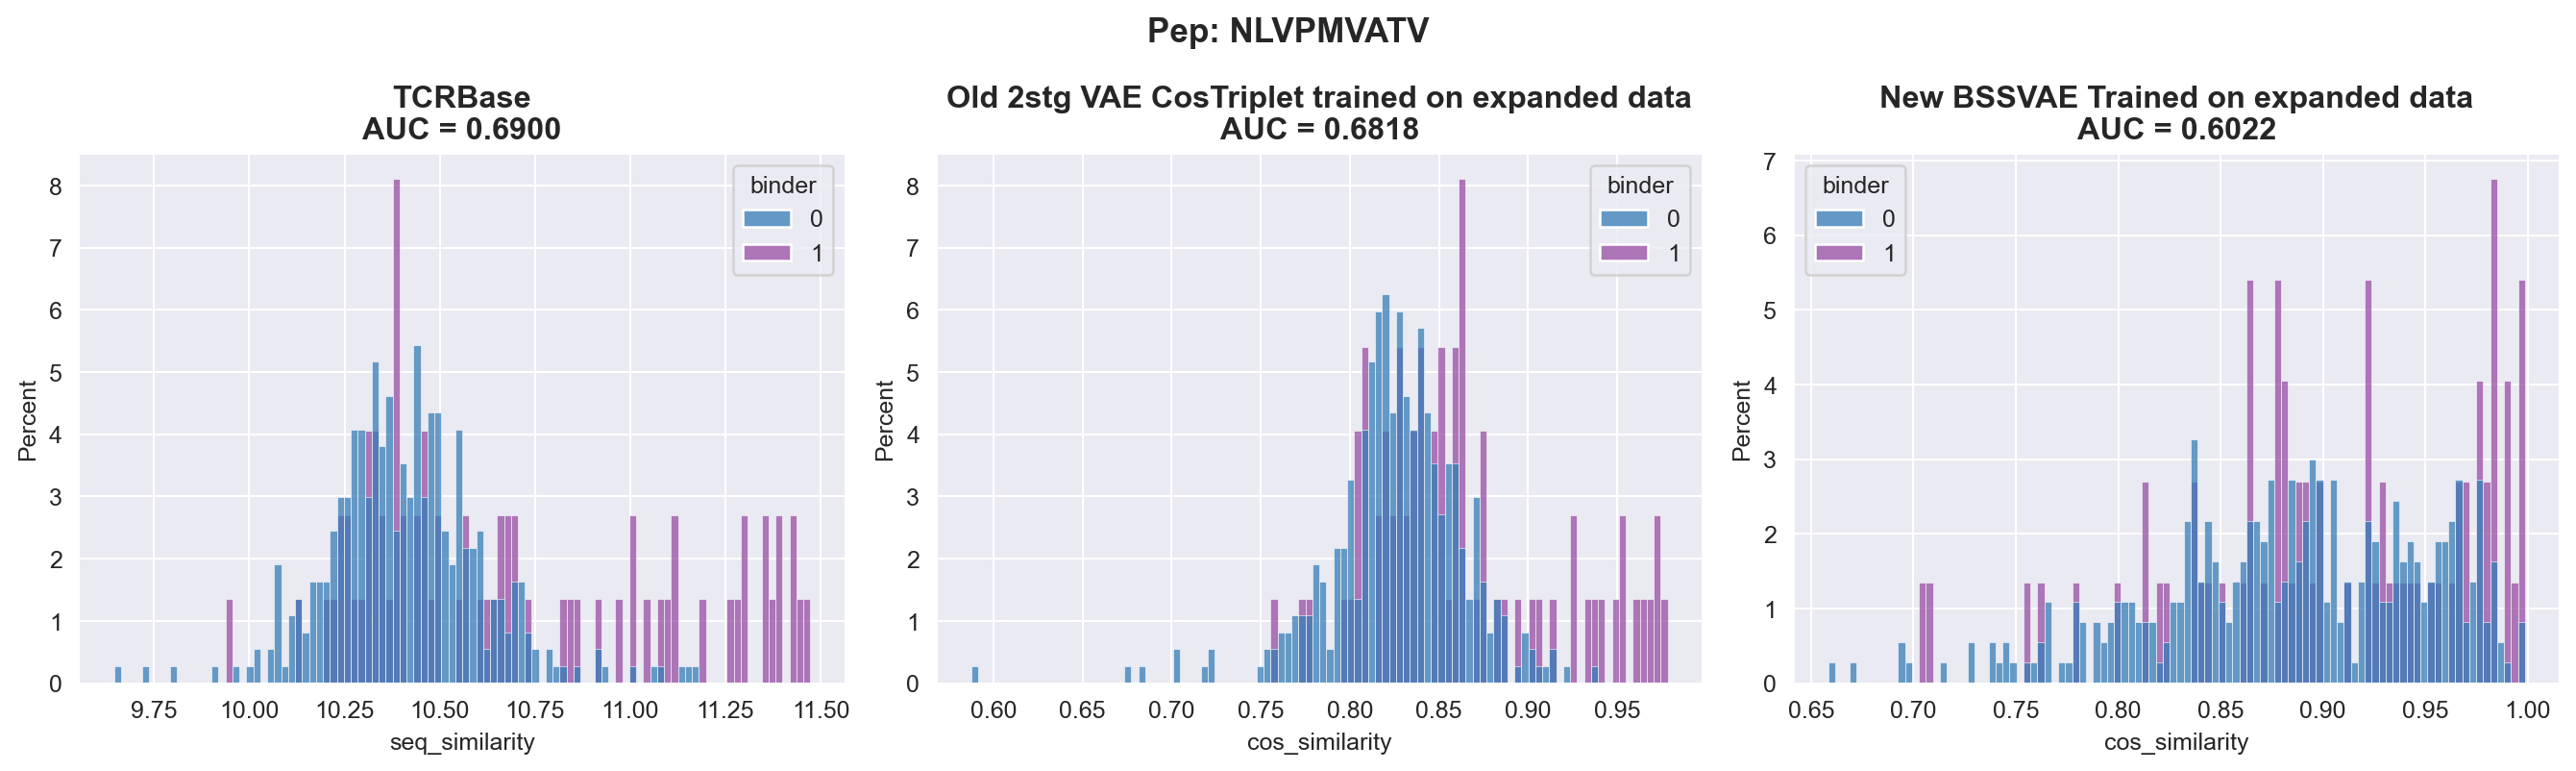

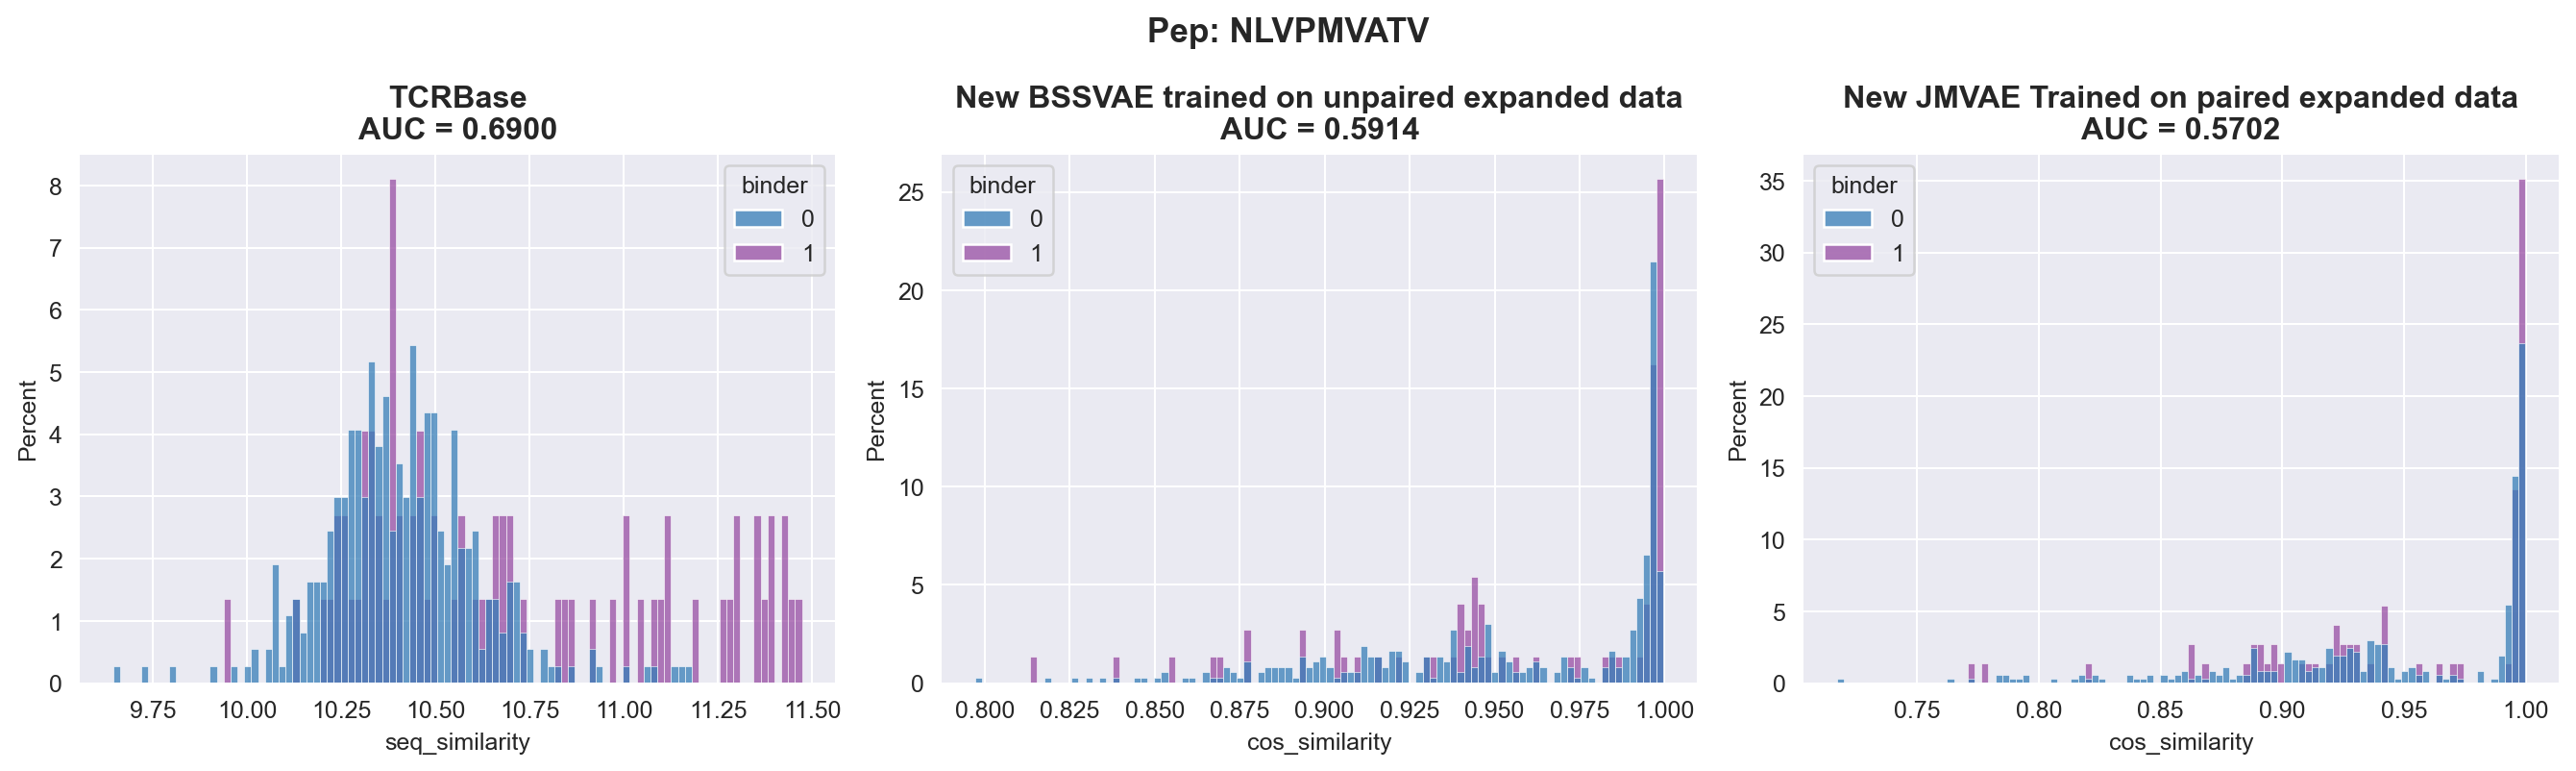

In [460]:
make_3_plots('NLVPMVATV', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')
make_3_plots('NLVPMVATV', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on expanded data')
make_3_plots('NLVPMVATV', new_df, 
             '../output/240403_MMVAE_TCRBASE/tcrbase_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu/',
             'New BSSVAE trained on unpaired expanded data',
             'New JMVAE Trained on paired expanded data')

### rakqfl

RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}


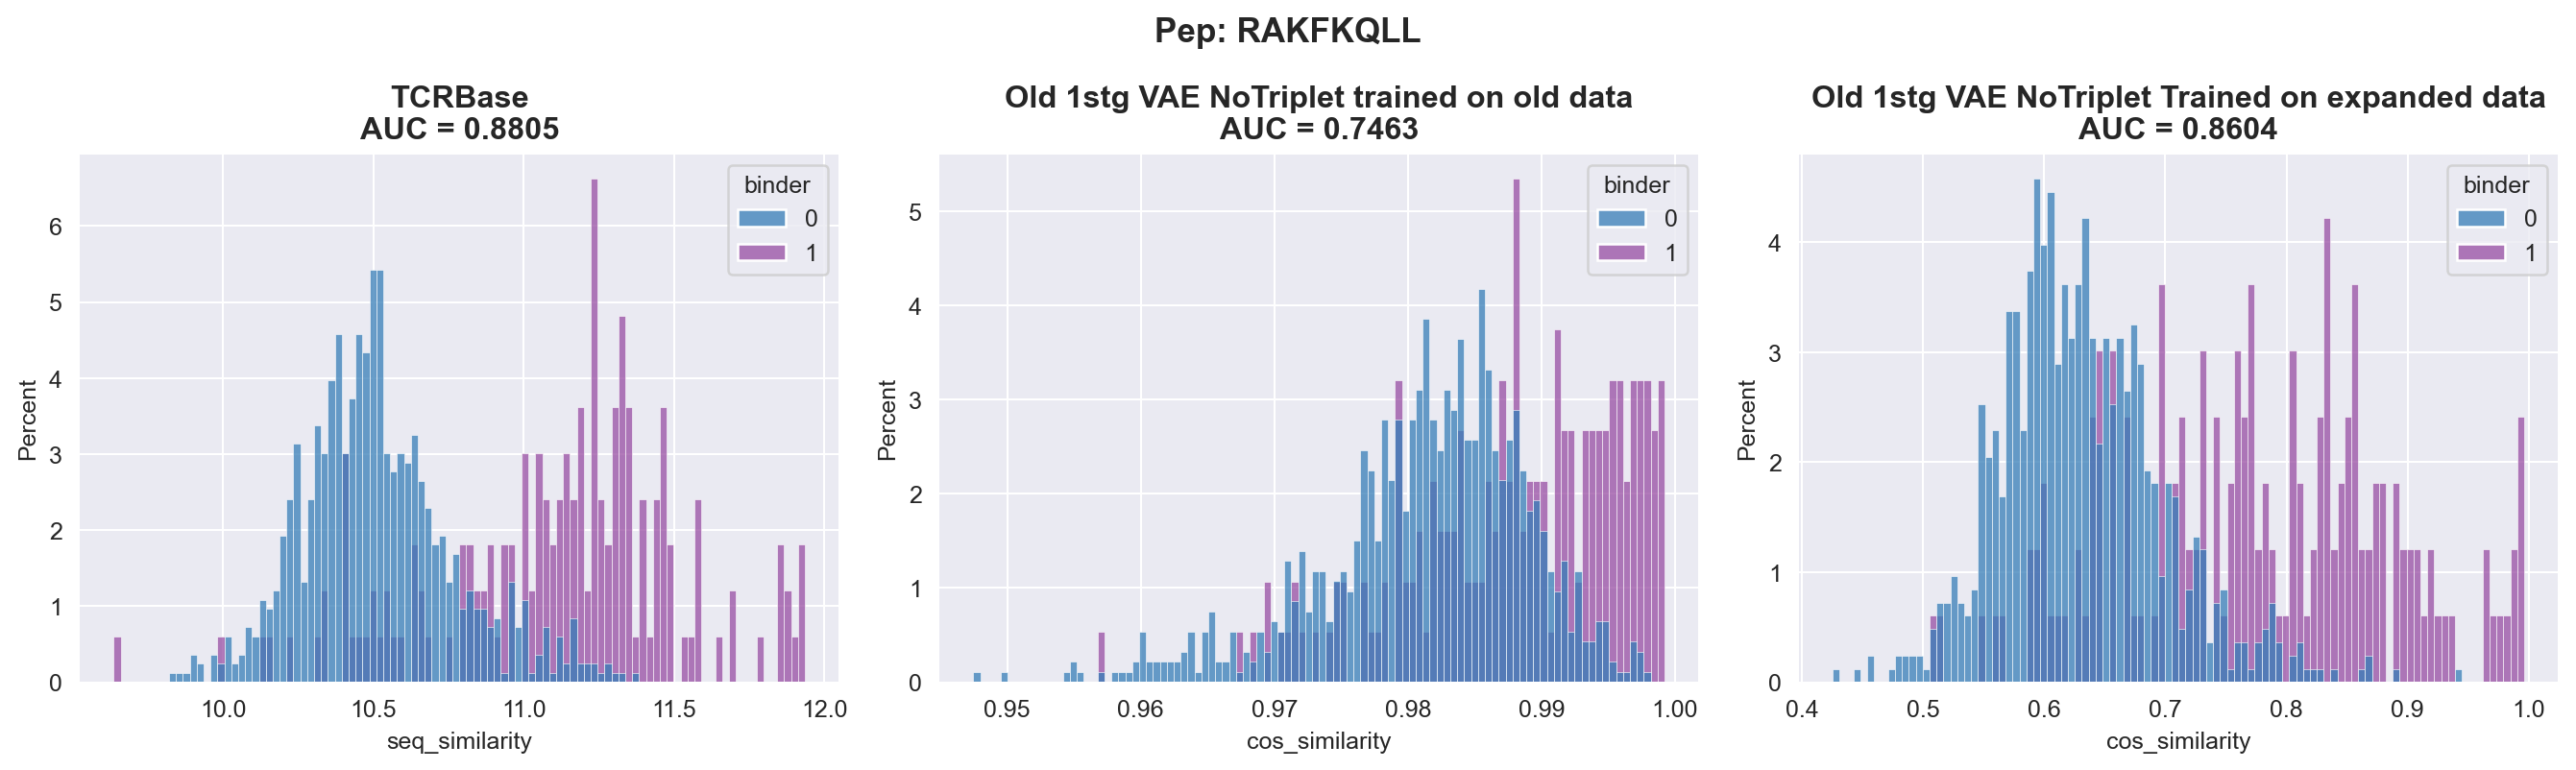

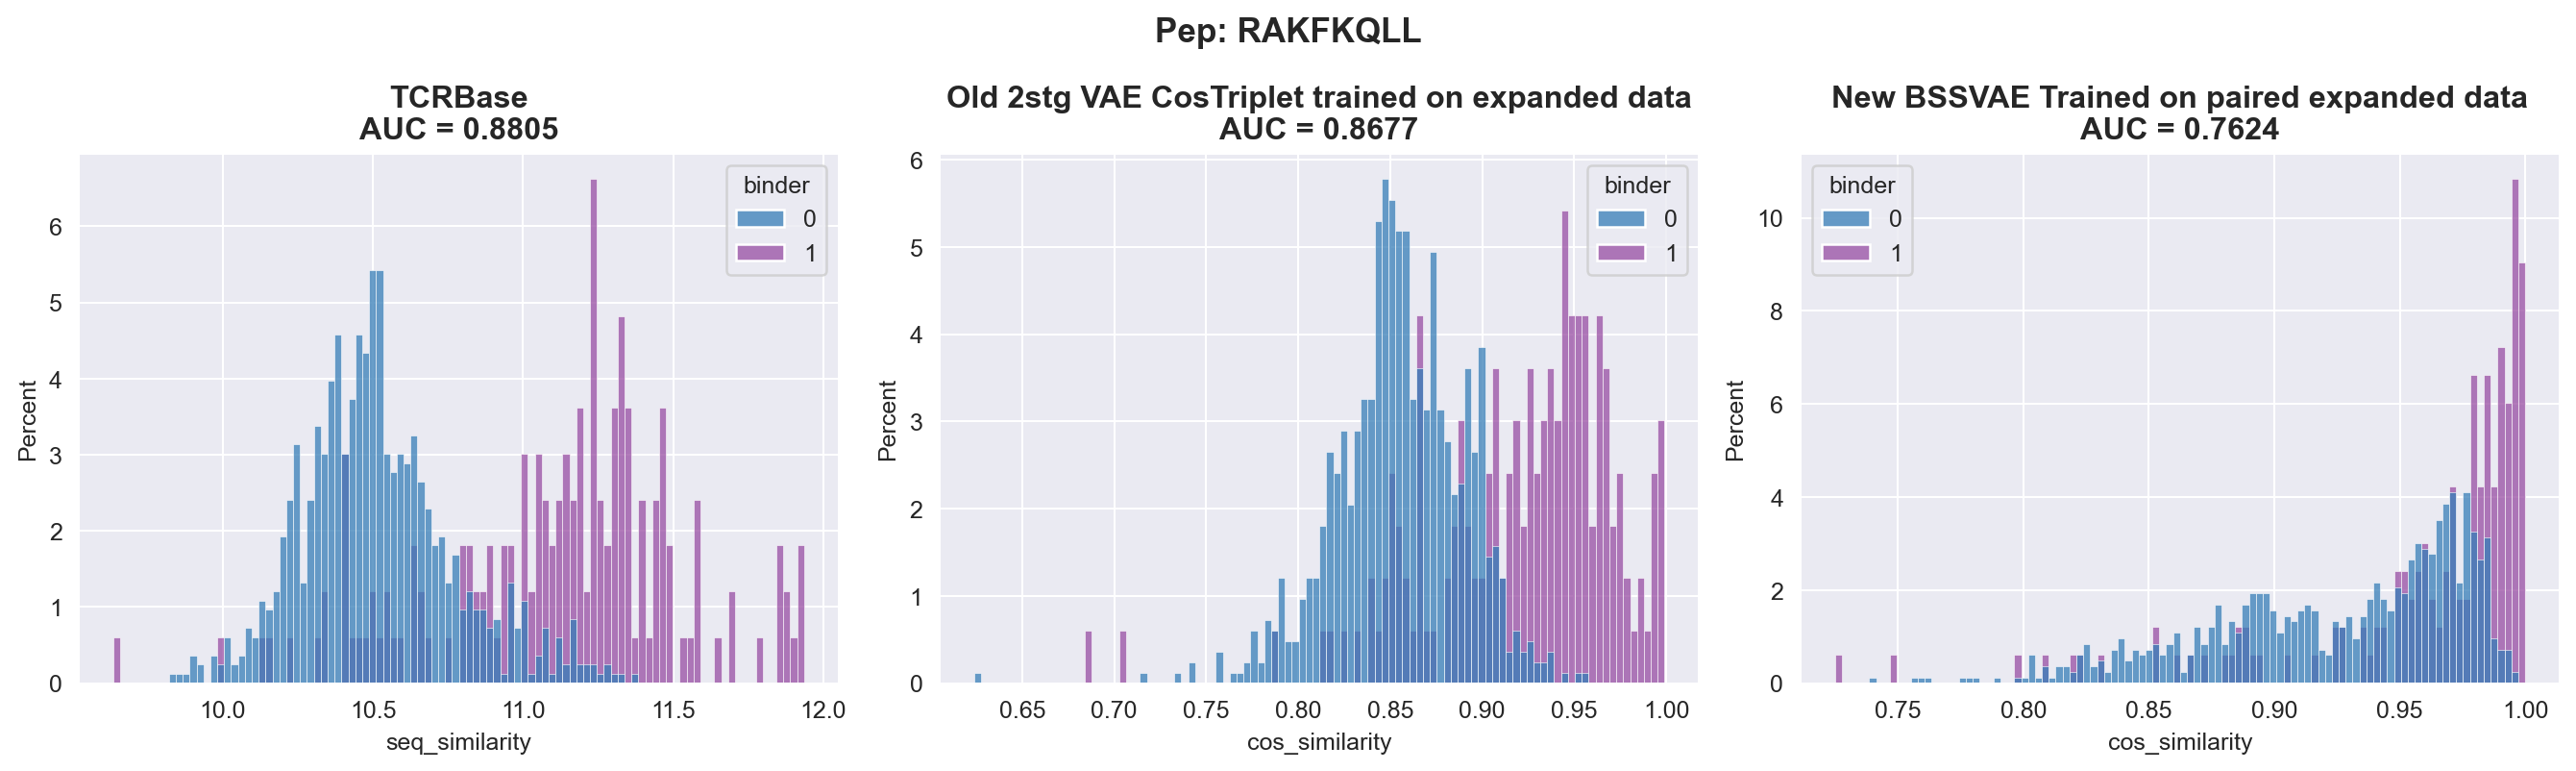

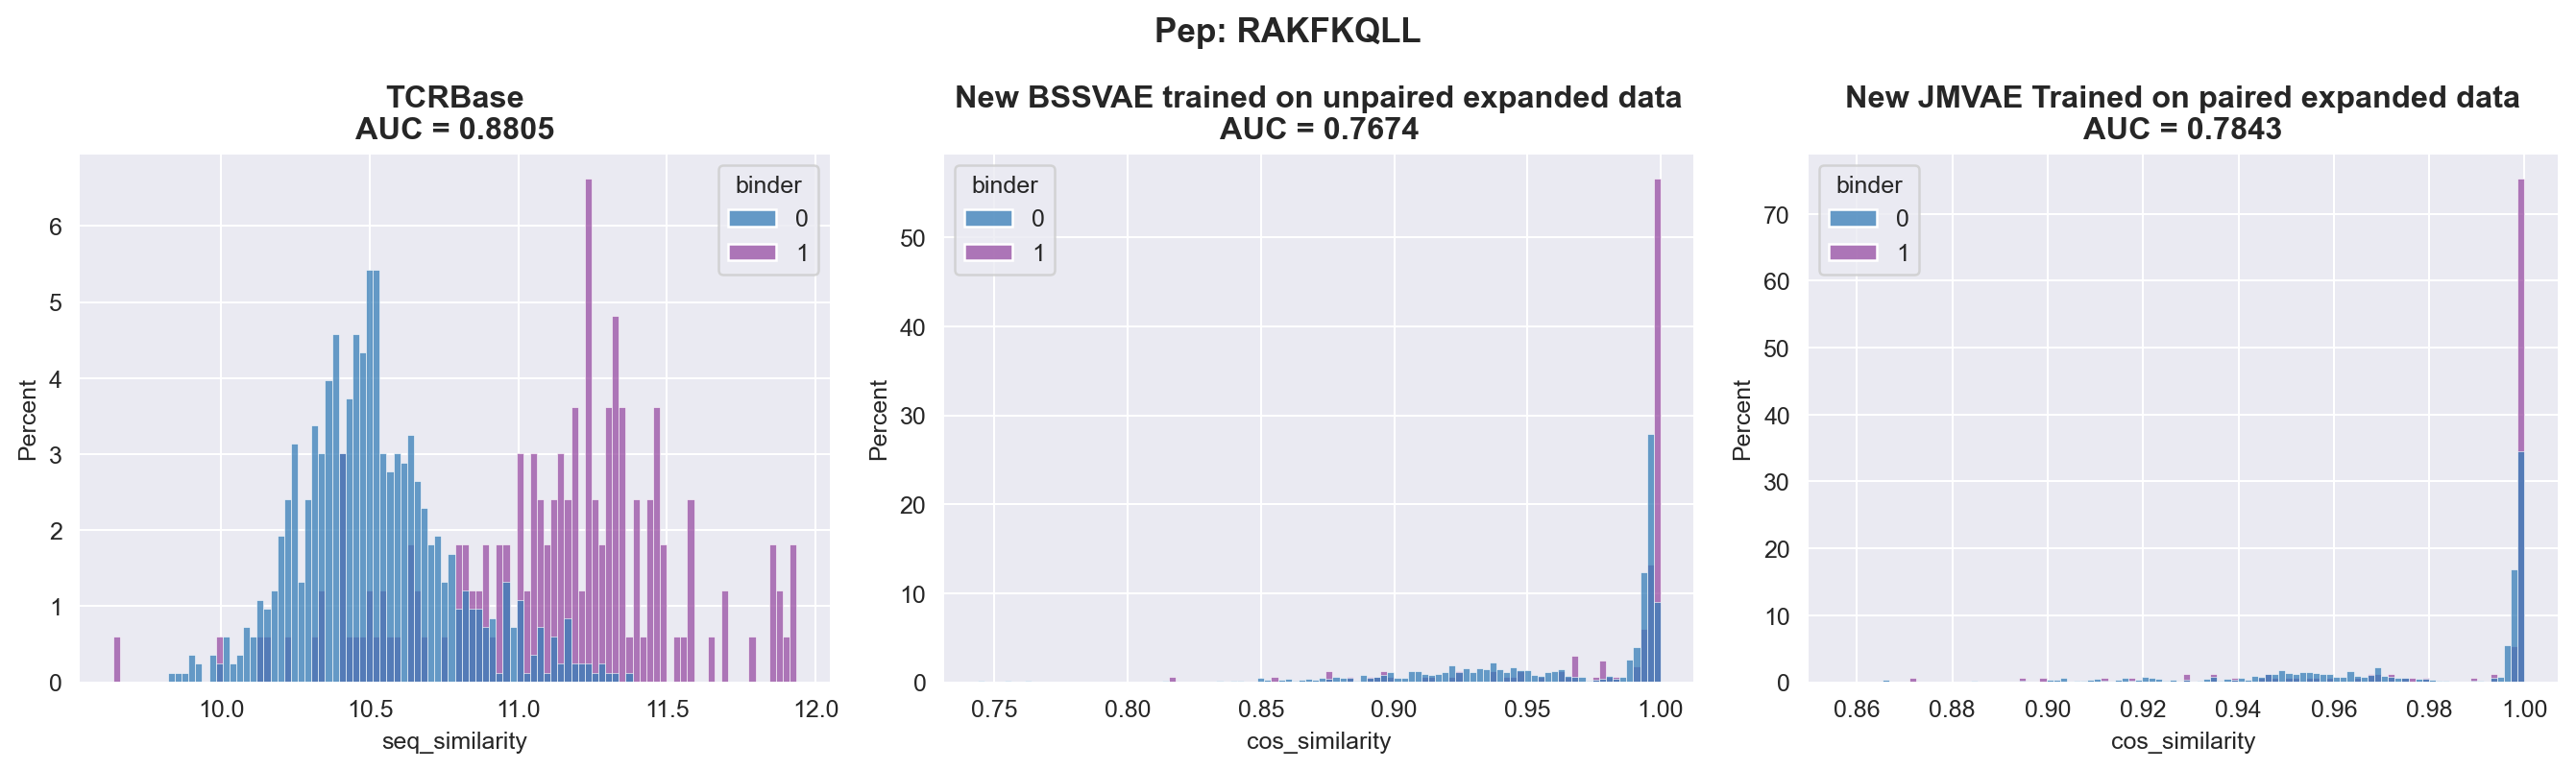

In [463]:
make_3_plots('RAKFKQLL', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')
make_3_plots('RAKFKQLL', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on paired expanded data')
make_3_plots('RAKFKQLL', new_df, 
             '../output/240403_MMVAE_TCRBASE/tcrbase_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu/',
             'New BSSVAE trained on unpaired expanded data',
             'New JMVAE Trained on paired expanded data')

### YLQP

In [466]:
pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv

array(['paired'], dtype=object)

YLQPRTFLL 0.7077
{'peptide': 'YLQPRTFLL', 'method': 'tcrbase', 'n_pos': 460, 'auc': 0.70768, 'auc_01': 0.65268, 'auc_01_real': 0.3401, 'precision': 0.16701, 'recall': 1.0, 'accuracy': 0.16701, 'AP': 0.51549}
YLQPRTFLL 0.7077
{'peptide': 'YLQPRTFLL', 'method': 'tcrbase', 'n_pos': 460, 'auc': 0.70768, 'auc_01': 0.65268, 'auc_01_real': 0.3401, 'precision': 0.16701, 'recall': 1.0, 'accuracy': 0.16701, 'AP': 0.51549}
YLQPRTFLL 0.7077
{'peptide': 'YLQPRTFLL', 'method': 'tcrbase', 'n_pos': 460, 'auc': 0.70768, 'auc_01': 0.65268, 'auc_01_real': 0.3401, 'precision': 0.16701, 'recall': 1.0, 'accuracy': 0.16701, 'AP': 0.51549}


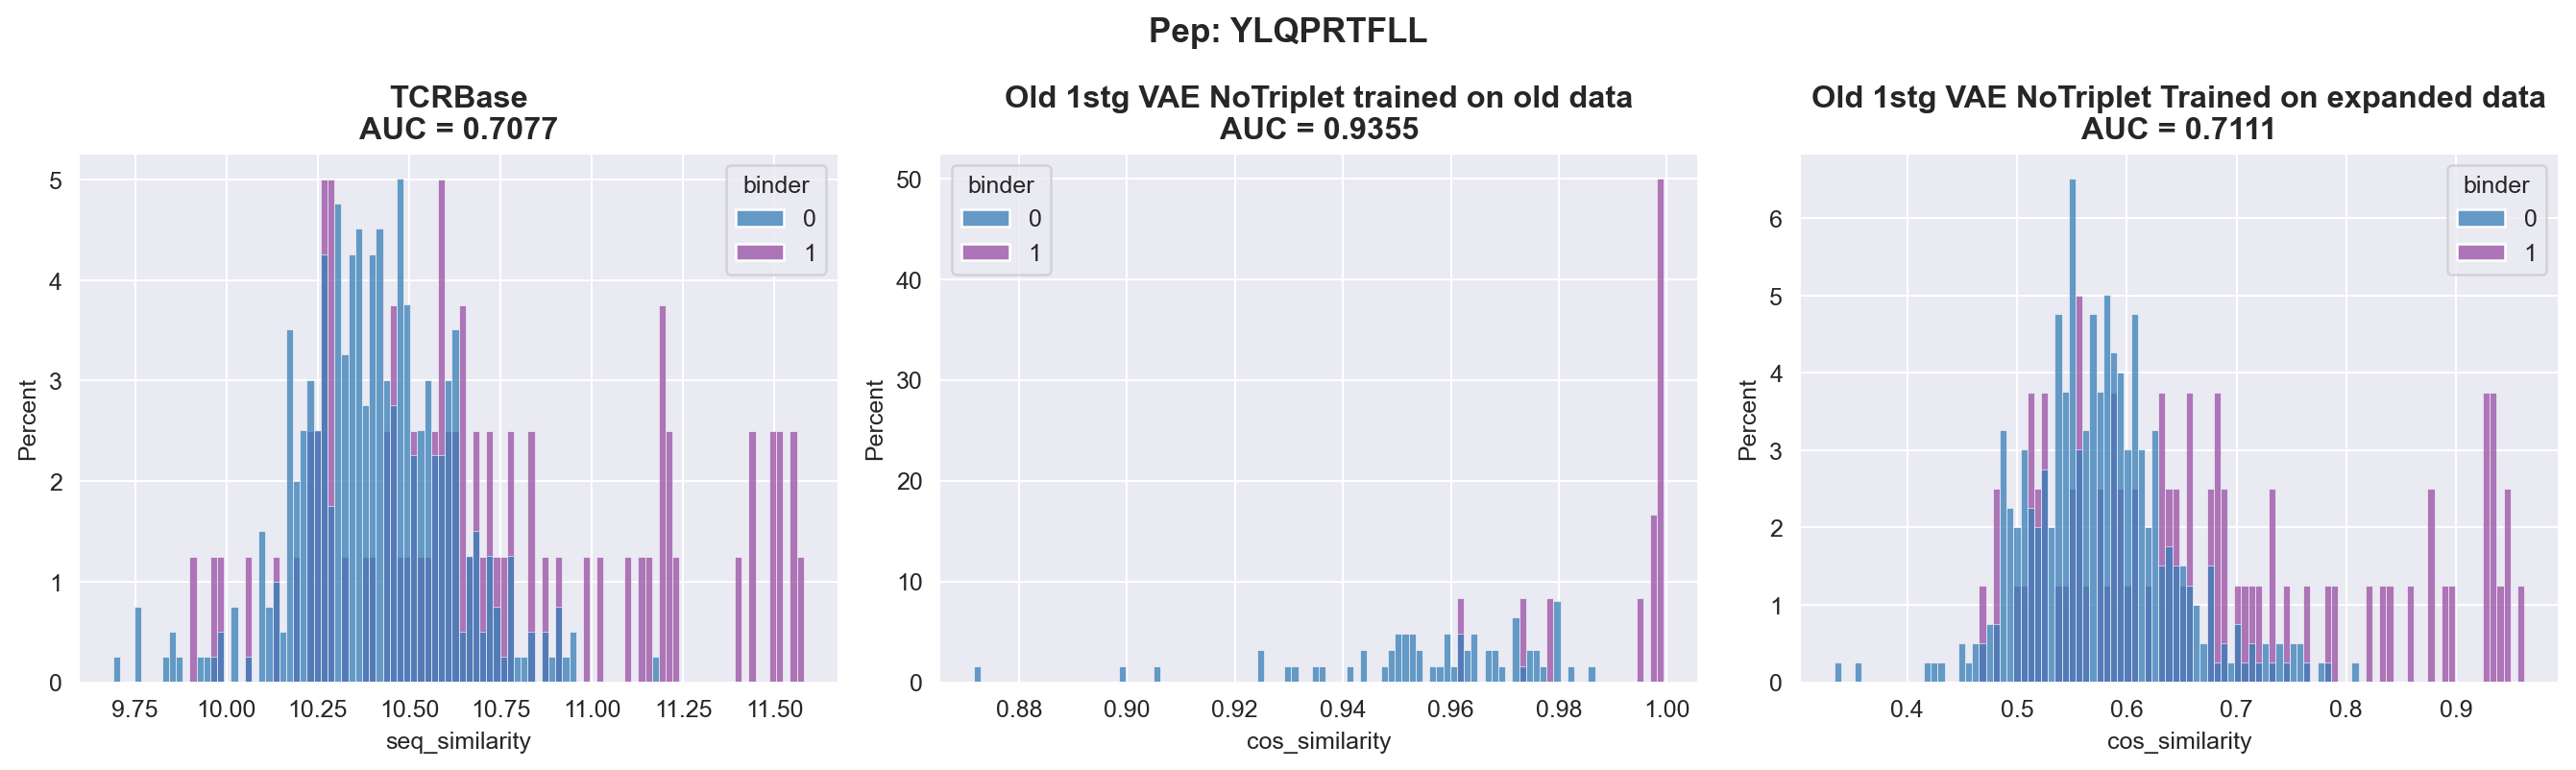

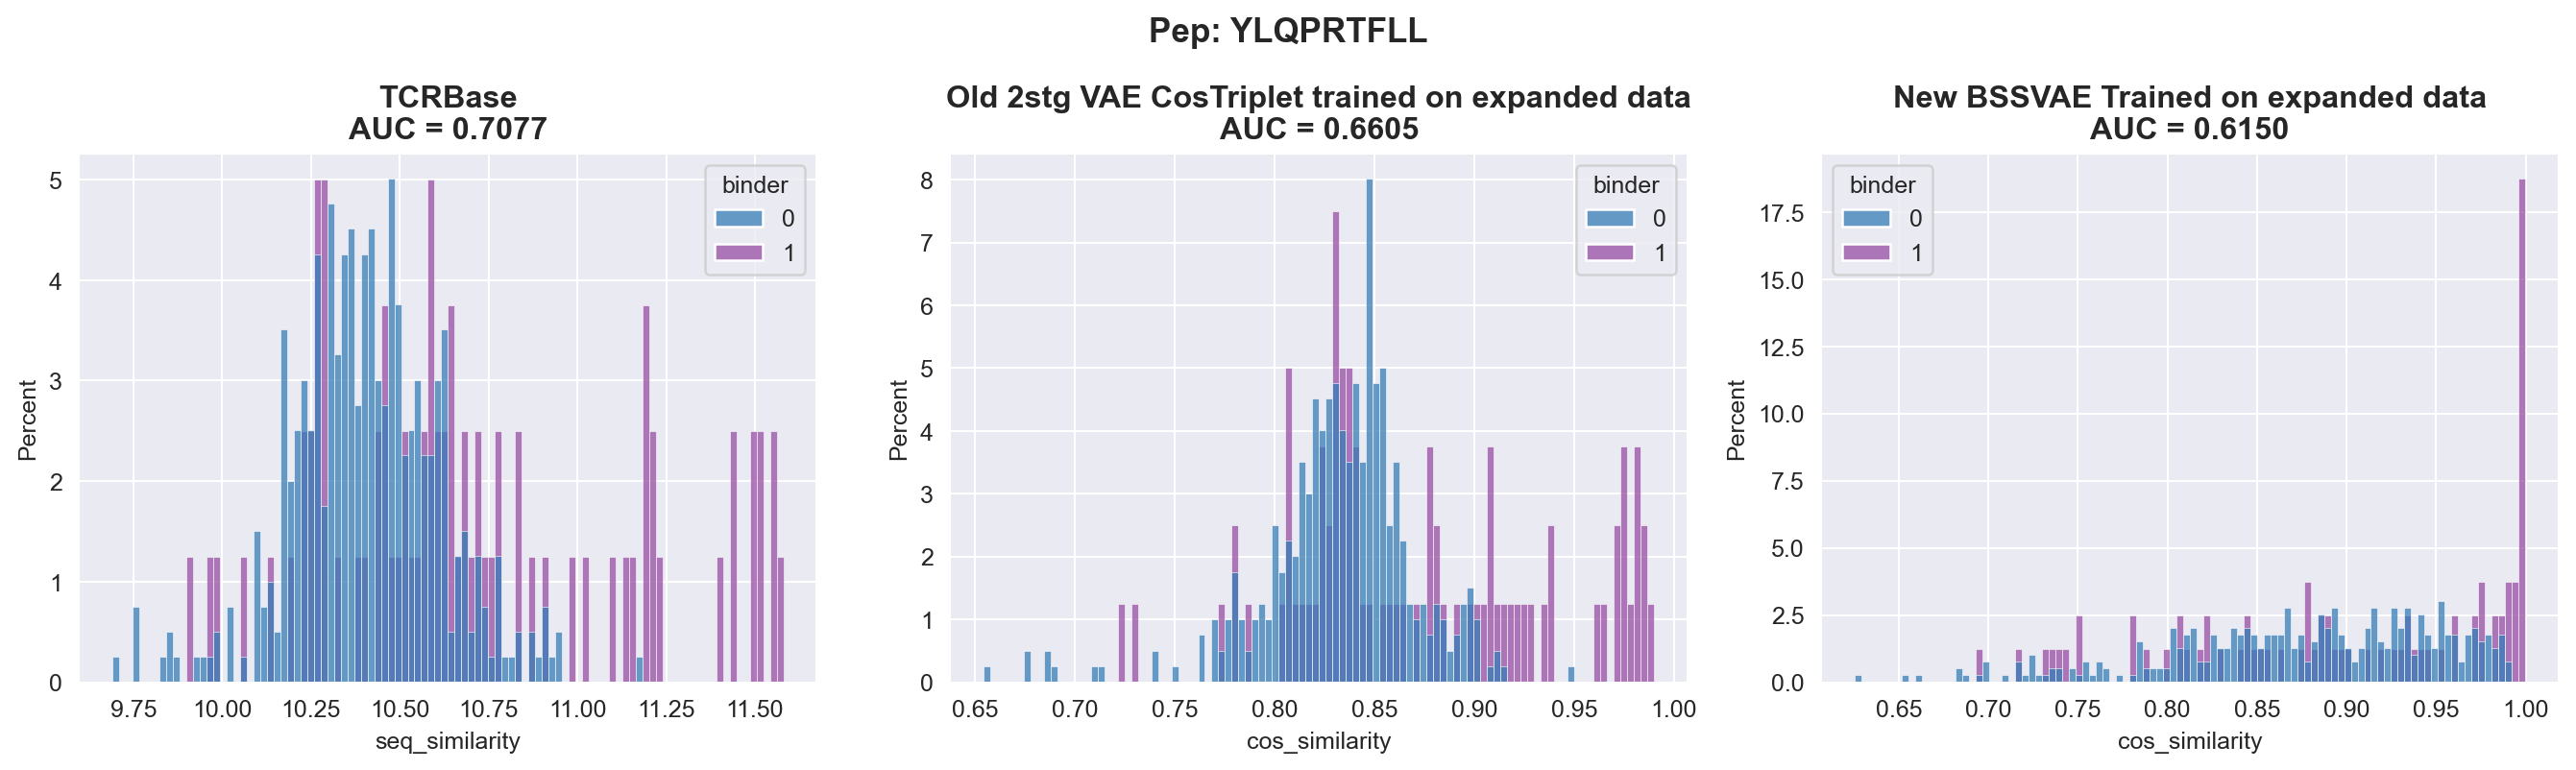

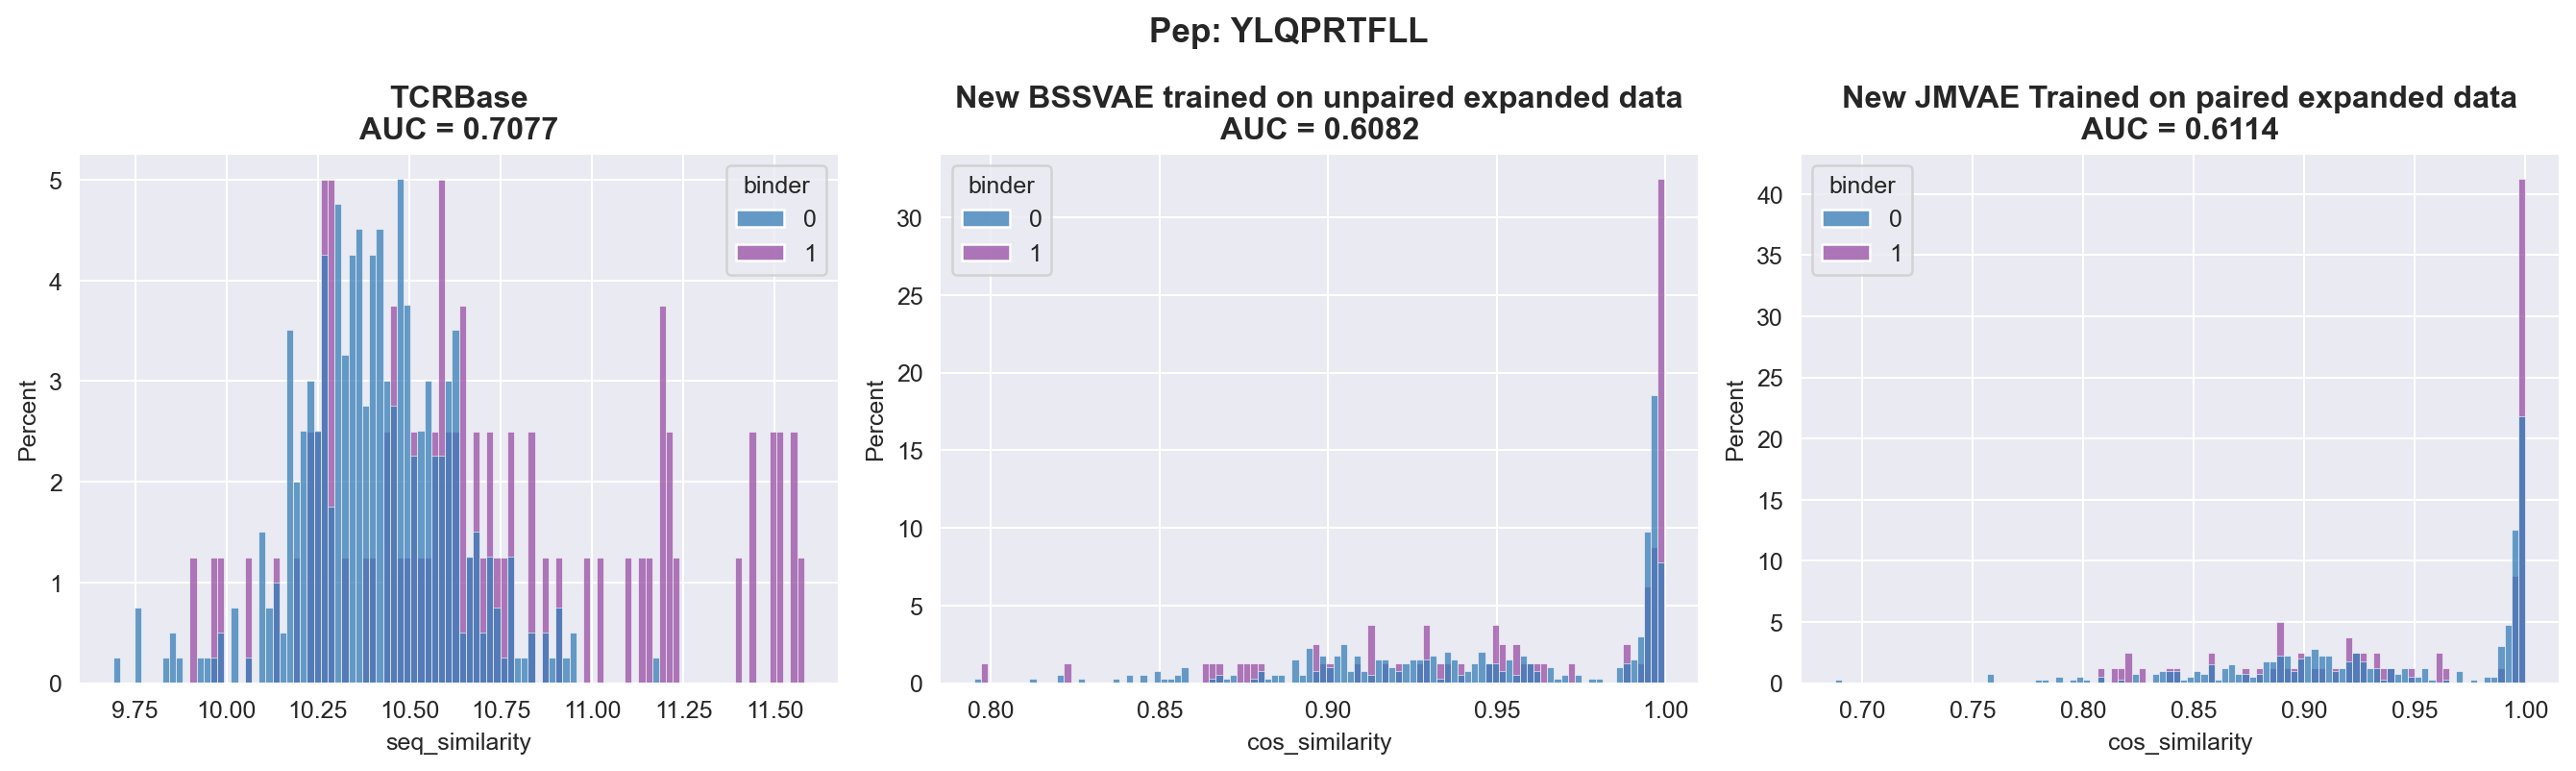

In [464]:
make_3_plots('YLQPRTFLL', new_df, 
             '../output/240131_TCRBase_SwapVsPos/I_SwapNeg_TwoStage_AddPep_NoTriplet/tcrbase_240126_PepSwapped_2stageFull_NoTrp_PosEncode_AddPep_1k25WU_3kEp_LowMarg_fold_1_KFold_1_240126_1430_KFold_1_240131_1024_PEPEP/',
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1522_AAAAAA/',
             'Old 1stg VAE NoTriplet trained on old data',
             'Old 1stg VAE NoTriplet Trained on expanded data')
make_3_plots('YLQPRTFLL', new_df, 
             '../output/240403_oldExpVAE_TCRBASE/tcrbase_240402_1135_240326_2stage_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240403_1512_DDDDDD/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240322_1416_RESUME_ADDKLDN_BSSVAE_allTrue_10kepochs_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1117_yOqyC6/',
             'Old 2stg VAE CosTriplet trained on expanded data',
             'New BSSVAE Trained on expanded data')

make_3_plots('YLQPRTFLL', new_df, 
             '../output/240403_MMVAE_TCRBASE/tcrbase_240403_0003_BSSVAE_UNPAIRED_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1115_ezI4Q3/',
             '../output/240403_MMVAE_TCRBASE/tcrbase_240325_1327_JMVAE_addlencTrue_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240403_1116_iUX7Lu/',
             'New BSSVAE trained on unpaired expanded data',
             'New JMVAE Trained on paired expanded data')

## Comparisons to other models (Best, last, reset)

In [824]:
def read_tcrbase_results(peptide, original_df, dir='../output/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results
    
def read_tcrvae_results(peptide, original_df, dir):
    csv_file = glob.glob(f'{dir}*{peptide}*.csv')[0]
    df = pd.read_csv(csv_file)
    df['binder']=df['label']
    df['score'] = 1- df['min_dist']
    basename = os.path.basename(csv_file)
    condition = '_'.join(basename.split('_')[2:])
    n = 5 if condition.startswith('tcrbase') else 6
    xd = condition.split('_')[0] if n==6 else ''
    metrics = {'peptide':peptide, 'method':xd+'_'+'_'.join(condition.split('_')[n:]), 
               'n_pos':len(original_df.query('original_peptide==@peptide and partition==0 and binder==0'))}
    metrics.update(get_metrics(df['label'], df['score']))
    return metrics, df
# Define a function to calculate the multiple operations
def calculate_metrics(x):
    normal_avg_auc = x['auc'].mean()
    weighted_avg_auc = np.average(x['auc'], weights=x['weight'])
    normal_avg_auc_01 = x['auc_01'].mean()
    weighted_avg_auc_01 = np.average(x['auc_01'], weights=x['weight'])
    return pd.Series({
        'normal_avg_auc': normal_avg_auc,
        'weighted_avg_auc': weighted_avg_auc,
        'normal_avg_auc_01': normal_avg_auc_01,
        'weighted_avg_auc_01': weighted_avg_auc_01
    })


In [825]:
import pandas as pd
import numpy as np
best = []
for f in glob.glob('../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/*/'):
    for p in newpeps:
        best.append(read_tcrvae_results(p, new_df, f)[0])
        
reset = []
for f in glob.glob('../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/RESET/*/'):
    for p in newpeps:
        reset.append(read_tcrvae_results(p, new_df, f)[0])

last = []
for f in glob.glob('../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/LAST//*/'):
    for p in newpeps:
        last.append(read_tcrvae_results(p, new_df, f)[0])

# old = []
# for f in glob.glob('../output/240403_oldExpVAE_TCRBASE/*/'):
#     for p in newpeps:
#         old.append(read_tcrvae_results(p, new_df, f)[0])
# old = pd.DataFrame(old)
# ntr = pd.DataFrame(ntr)
tcrbase_results['method'] = 'TCRBase'


In [826]:
cat = pd.concat([tcrbase_results, pd.DataFrame(best), pd.DataFrame(reset), pd.DataFrame(last)])
cat['weight'] = cat['peptide'].apply(lambda x: len(new_df.query('peptide==@x')) / len(new_df))

In [827]:
top25 = tcrbase_results.sort_values('n_pos',ascending=False).head(25).peptide.unique()
# Define a function to calculate the multiple operations
def calculate_metrics(x, top25=tcrbase_results.sort_values('n_pos',ascending=False).head(25).peptide.unique()):
    normal_avg_auc = x['auc'].mean()
    weighted_avg_auc = np.average(x['auc'], weights=x['weight'])
    normal_avg_auc_01 = x['auc_01'].mean()
    weighted_avg_auc_01 = np.average(x['auc_01'], weights=x['weight'])
    top_25 = x.query('peptide in @top25')
    top_25_normal_avg_auc = top_25['auc'].mean()
    top_25_weighted_avg_auc = np.average(top_25['auc'], weights=top_25['weight'])
    top_25_normal_avg_auc_01 = top_25['auc_01'].mean()
    top_25_weighted_avg_auc_01 = np.average(top_25['auc_01'], weights=top_25['weight'])
    return pd.Series({
        'normal_avg_auc': normal_avg_auc,
        'weighted_avg_auc': weighted_avg_auc,
        'normal_avg_auc_01': normal_avg_auc_01,
        'weighted_avg_auc_01': weighted_avg_auc_01,
        'top25_normal_avg_auc': top_25_normal_avg_auc,
        'top25_weighted_avg_auc': top_25_weighted_avg_auc,
        'top25_normal_avg_auc_01': top_25_normal_avg_auc_01,
        'top25_weighted_avg_auc_01': top_25_weighted_avg_auc_01,
        
    })

# Group by the 'group' column and apply the custom calculation function
result = cat.groupby('method').apply(calculate_metrics).reset_index()

result.sort_values('weighted_avg_auc', ascending=False)


method  \
20                                                   LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
16                                                    LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
0                                                     BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   
27                                                                  LAST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1421_CCCCC.csv   
23                                                                LAST_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1358_DDDDDD.csv   
4                                                    BEST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE.csv   
17                                                     LAST_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1349_LARGETCRP1.csv   
1                                                      BEST_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1345_LARGETCRP1.csv   
10                                                                 BEST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1408_AAAAAA.csv   
7                                                                 BEST_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1353_DDDDDD.csv   
26                                                                 LAST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1414_AAAAAA.csv   
48                                                                                                                          TCRBase   
22                                                    LAST_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1330_2stTCRPsmall.csv   
11                                                                  BEST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1416_CCCCC.csv   
6                                                     BEST_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1325_2stTCRPsmall.csv   
19                                                      LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
3                                                       BEST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1338_smallTCRP1.csv   
21                                                        LAST_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1325_2stCDRsm.csv   
28               LAST_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1428_IzcVOH.csv   
18                                                        LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1321_smCDR1ST.csv   
30   LAST_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1425_hRmUHn.csv   
2                                                         BEST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1319_smCDR1ST.csv   
8                                                                 BEST_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1401_BBBBBB.csv   
24                                                                LAST_CosTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1406_BBBBBB.csv   
31                                   LAST_allTrue_LONG_wd5e-5_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1352_ezI4Q3.csv   
29              LAST_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1426_iUX7Lu.csv   
14   BEST_addlencTrue_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1424_hRmUHn.csv   
13              BEST_addldecTrue_bnTrue_LONG_25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1425_iUX7Lu.csv   
12               BEST_addldecTrue_bnTrue_LONG25kepochs_wd1e-6_lwseq2_nhtcr256_nhpep128_nl100_KFold_0_KFold_0_240408_1427_IzcVOH.csv   
5                                                         BEST_2stage_SMALL

In [836]:
above10=new_df.query('origin!="peptide_swapped" and origin!="10x"').groupby('peptide').agg(count=('B3','count')).sort_values('count',ascending=False).query('count>10').index
new_df.query('origin!="peptide_swapped" and origin!="10x"').query('peptide in @above10')

peptide       A1        A2                  A3     B1      B2  \
3      TTDPSFLGRY   ATGYPS   ATKADDK          ALSGNTDKLI  MDHEN  SYDVKM   
16      RLPGVLPRA   SSVSVY  YLSGSTLV         AVSPYNNNDMR  SGHNS  FNNNVP   
42      VYFLQSINF   SSVSVY  YLSGSTLV       AVSTNTGANSKLT  SGHDT  YYEEEE   
102    KLSALGINAV  TSESDYY  QEAYKQQN        AWRGGGGADGLT  MNHEY  SVGEGT   
109     KSKRTPMGF   YGATPY  YFSGDTLV  AVGHELYSGGGDDGLTLT  SGHVS  FQNEAQ   
...           ...      ...       ...                 ...    ...     ...   
58518   LLWNGPMAV   NSASQS     VYSSG           VVFNFNKFY  KGHSH  LQKENI   
58528   SPRWYFYYL  NIATNDY     GYKTK       LVGDRGSTLGRLY  LGHNA  YNFKEQ   
58536   KTFPPTEPK   DSASNY   IRSNVGE           AADNNNDMR  LGHDT  YNNKEL   
58583   NLVPMVATV   NYSPAY   IRENEKE          ALVTGYSTLT  SGHNT  YYREEE   
58613   VAANIVLTV    TSINN   IRSNERE           AVTGANNLF  LNHDA  SQIVND   

                     B3                    allele  partition  binder origin  \
3         ASSLAGGIVDEQF               HLA-A*01:01          1       1  VDJdb   
16         ASRPLAAQETQY               HLA-A*02:01          4       1  VDJdb   
42         ASSFRGLNQPQH  HLA-A*02:01, HLA-A*24:02          3       1   IEDB   
102        ASSWDPTYNEQF               HLA-A*02:01          0       1  VDJdb   
109        ASSLVPPTDTQY               HLA-B*57:01          3       1  VDJdb   
...                 ...                       ...        ...     ...    ...   
58518    ASSPDGGHSTDTQY               HLA-A*02:01          0       1  VDJdb   
58528     ASSQSGTGPYEQY               HLA-B*07:02          4       1  VDJdb   
58536   ASSQEYRGSSYNEQF               HLA-A*03:01          3       1  VDJdb   
58583  ASSSGTSGSGSYNEQF               HLA-A*02:01          2       1  VDJdb   
58613      ASSIEGPTGELF               HLA-A*02:01          0       1  VDJdb   

      original_peptide    raw_index  \
3           TTDPSFLGRY  VDJdb_69875   
16           RLPGVLPRA  VDJdb_73754   
42           VYFLQSINF  IEDB_191829   
102         KLSALGINAV  VDJdb_73974   
109          KSKRTPMGF  VDJdb_83009   
...                ...          ...   
58518        LLWNGPMAV  VDJdb_74067   
58528        SPRWYFYYL  VDJdb_80179   
58536        KTFPPTEPK  VDJdb_80992   
58583        NLVPMVATV   VDJdb_6082   
58613        VAANIVLTV  VDJdb_24025   

                                                 reference source_organism  \
3      https://github.com/antigenomics/vdjdb-db/issues/326      SARS-CoV-2   
16                                                33811047     HomoSapiens   
42                                                34424997       SARS-CoV2   
102                                               28934479             HCV   
109                                                    NaN             HCV   
...                                                    ...             ...   
58518                                             28934479             YFV   
58528                                             33951417      SARS-CoV-2   
58536                                             35750048      SARS-CoV-2   
58583          https://doi.org/10.1101/2020.05.04.20085779             CMV   
58613                                             29429978     HomoSapiens   

      input_type  
3        tcr_pep  
16       tcr_pep  
42       tcr_pep  
102      tcr_pep  
109      tcr_pep  
...          ...  
58518    tcr_pep  
58528    tcr_pep  
58536    tcr_pep  
58583    tcr_pep  
58613    tcr_pep  

[4863 rows x 16 columns]

In [829]:
result.query('method.str.contains("TCR")')

method  \
0     BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   
1      BEST_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1345_LARGETCRP1.csv   
3       BEST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1338_smallTCRP1.csv   
4    BEST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE.csv   
6     BEST_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1325_2stTCRPsmall.csv   
16    LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
17     LAST_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1349_LARGETCRP1.csv   
19      LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
20   LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
22    LAST_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1330_2stTCRPsmall.csv   
32   RESET_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1444_SmCosTCRP1.csv   
33    RESET_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1347_LARGETCRP1.csv   
35     RESET_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1340_smallTCRP1.csv   
36  RESET_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1334_2stTCRPLARGE.csv   
38   RESET_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1328_2stTCRPsmall.csv   
48                                                                          TCRBase   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
0         0.636851          0.729982           0.650805             0.671276   
1         0.619285          0.714907           0.633949             0.661404   
3         0.601956          0.693622           0.606189             0.646541   
4         0.633081          0.719118           0.638212             0.672285   
6         0.631304          0.707335           0.613965             0.658600   
16        0.637696          0.730158           0.650086             0.671227   
17        0.628658          0.714920           0.637207             0.660542   
19        0.608334          0.694629           0.605188             0.646121   
20        0.637143          0.737668           0.635348             0.681473   
22        0.583644          0.711473           0.608495             0.662794   
32        0.553873          0.649613           0.577955             0.627597   
33        0.553873          0.649613           0.577955             0.627597   
35        0.570129          0.653624           0.591322             0.627898   
36        0.553281          0.649536           0.576088             0.627193   
38        0.570718          0.653685           0.592870             0.628060   
48        0.599924          0.711555           0.640614             0.676051   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
0               0.762556                0.747647                 0.697300   
1               0.757368                0.732341                 0.688048   
3               0.729288                0.709802                 0.658492   
4               0.754656                0.735099                 0.691960   
6               0.732596                0.722140                 0.657988   
16              0.764460                0.747320                 0.698528   
17              0.754496                0.731411                 0.687944   
19              0.729848                0.710087                 0.659648   
20              0.748628                0.755106                 0.692792   
22              0.727032                0.733450                 0.663456   
32              0.649140                0.664801                 0.619412   
33              0.649140                0.664801                 0.619412   
35              0.651228                0.667088                 0.619592   
36              0.649140                0.664801                 0.619412   
38              0.651228                0.667088                 0.619592   
48  

In [828]:
for c in [c for c in result.columns if c !='method']:
    print(c)
    display(result.sort_values(c, ascending=False).head(3))

normal_avg_auc


method  \
10               BEST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1408_AAAAAA.csv   
26               LAST_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240408_1414_AAAAAA.csv   
16  LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
10        0.638832          0.714888           0.632249             0.658201   
26        0.637726          0.713198           0.630136             0.657381   
16        0.637696          0.730158           0.650086             0.671227   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
10              0.749816                0.726288                 0.681928   
26              0.749712                0.725183                 0.681192   
16              0.764460                0.747320                 0.698528   

    top25_weighted_avg_auc_01  
10                   0.661051  
26                   0.660853  
16                   0.674745

weighted_avg_auc


method  \
20  LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
16   LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
0    BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
20        0.637143          0.737668           0.635348             0.681473   
16        0.637696          0.730158           0.650086             0.671227   
0         0.636851          0.729982           0.650805             0.671276   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
20              0.748628                0.755106                 0.692792   
16              0.764460                0.747320                 0.698528   
0               0.762556                0.747647                 0.697300   

    top25_weighted_avg_auc_01  
20                   0.690460  
16                   0.674745  
0                    0.674445

normal_avg_auc_01


method  \
0   BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   
16  LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
48                                                                        TCRBase   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
0         0.636851          0.729982           0.650805             0.671276   
16        0.637696          0.730158           0.650086             0.671227   
48        0.599924          0.711555           0.640614             0.676051   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
0               0.762556                0.747647                 0.697300   
16              0.764460                0.747320                 0.698528   
48              0.751647                0.732333                 0.705050   

    top25_weighted_avg_auc_01  
0                    0.674445  
16                   0.674745  
48                   0.681488

weighted_avg_auc_01


method  \
20  LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
48                                                                         TCRBase   
4   BEST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
20        0.637143          0.737668           0.635348             0.681473   
48        0.599924          0.711555           0.640614             0.676051   
4         0.633081          0.719118           0.638212             0.672285   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
20              0.748628                0.755106                 0.692792   
48              0.751647                0.732333                 0.705050   
4               0.754656                0.735099                 0.691960   

    top25_weighted_avg_auc_01  
20                   0.690460  
48                   0.681488  
4                    0.678341

top25_normal_avg_auc


method  \
16  LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
0   BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   
1    BEST_1stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1345_LARGETCRP1.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
16        0.637696          0.730158           0.650086             0.671227   
0         0.636851          0.729982           0.650805             0.671276   
1         0.619285          0.714907           0.633949             0.661404   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
16              0.764460                0.747320                 0.698528   
0               0.762556                0.747647                 0.697300   
1               0.757368                0.732341                 0.688048   

    top25_weighted_avg_auc_01  
16                   0.674745  
0                    0.674445  
1                    0.664920

top25_weighted_avg_auc


method  \
20  LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
0    BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   
16   LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
20        0.637143          0.737668           0.635348             0.681473   
0         0.636851          0.729982           0.650805             0.671276   
16        0.637696          0.730158           0.650086             0.671227   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
20              0.748628                0.755106                 0.692792   
0               0.762556                0.747647                 0.697300   
16              0.764460                0.747320                 0.698528   

    top25_weighted_avg_auc_01  
20                   0.690460  
0                    0.674445  
16                   0.674745

top25_normal_avg_auc_01


method  \
48                                                                        TCRBase   
16  LAST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1446_SmCosTCRP1.csv   
0   BEST_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
48        0.599924          0.711555           0.640614             0.676051   
16        0.637696          0.730158           0.650086             0.671227   
0         0.636851          0.729982           0.650805             0.671276   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
48              0.751647                0.732333                 0.705050   
16              0.764460                0.747320                 0.698528   
0               0.762556                0.747647                 0.697300   

    top25_weighted_avg_auc_01  
48                   0.681488  
16                   0.674745  
0                    0.674445

top25_weighted_avg_auc_01


method  \
20  LAST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1336_2stTCRPLARGE.csv   
48                                                                         TCRBase   
4   BEST_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE.csv   

    normal_avg_auc  weighted_avg_auc  normal_avg_auc_01  weighted_avg_auc_01  \
20        0.637143          0.737668           0.635348             0.681473   
48        0.599924          0.711555           0.640614             0.676051   
4         0.633081          0.719118           0.638212             0.672285   

    top25_normal_avg_auc  top25_weighted_avg_auc  top25_normal_avg_auc_01  \
20              0.748628                0.755106                 0.692792   
48              0.751647                0.732333                 0.705050   
4               0.754656                0.735099                 0.691960   

    top25_weighted_avg_auc_01  
20                   0.690460  
48                   0.681488  
4                    0.678341

In [731]:
cat.to_csv('../output/240405_SelectedVAEs_TCRBASE/concat_results.csv', index=False)

In [781]:
cat

peptide  n_pos      auc   auc_01  auc_01_real  precision  recall  \
0       AAFKRSCLK     11  0.20000  0.47368       0.0000    0.16667     1.0   
1       AAGIGILTV      6  1.00000  1.00000       1.0000    0.14286     1.0   
2       AEVQIDRLI     13  0.14286  0.47368       0.0000    0.12500     1.0   
3       AIFYLITPV     12  0.00000  0.47368       0.0000    0.22222     1.0   
4       AIMEKNIVL     10  0.75000  0.73684       0.5000    0.16667     1.0   
...           ...    ...      ...      ...          ...        ...     ...   
2715  YSEHPTFTSQY     42  0.64170  0.68420       0.4000    0.25000     0.4   
2716    YTMADLVYA      3  0.00000  0.47370       0.0000    0.00000     0.0   
2717    YVDNSSLTI      5  0.85710  0.47370       0.0000    0.00000     0.0   
2718    YVLDHLIVV      9  0.63640  0.49760       0.0455    0.00000     0.0   
2719    YVWKSYVHV      4  0.33330  0.47370       0.0000    0.00000     0.0   

      accuracy       AP  \
0      0.16667  0.20000   
1      0.14286  1.00000   
2      0.12500  0.14286   
3      0.22222  0.17361   
4      0.16667  0.64286   
...        ...      ...   
2715   0.68970  0.53050   
2716   0.83330  0.16670   
2717   0.87500  0.50000   
2718   0.76920  0.36110   
2719   0.71430  0.20000   

                                                                           method  \
0                                                                         TCRBase   
1                                                                         TCRBase   
2                                                                         TCRBase   
3                                                                         TCRBase   
4                                                                         TCRBase   
...                                                                           ...   
2715  LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
2716  LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
2717  LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
2718  LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   
2719  LAST_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1343_smallTCRP1.csv   

        weight  
0     0.000512  
1     0.000614  
2     0.000717  
3     0.000717  
4     0.001024  
...        ...  
2715  0.002457  
2716  0.000512  
2717  0.000717  
2718  0.001126  
2719  0.000614  

[8330 rows x 11 columns]

In [780]:
tcrbase_fulltcr_results.auc.mean()

0.5999243529411765

In [673]:
tcrbase_fulltcr_results = pd.DataFrame([read_tcrbase_results(p, new_df, 
                                                             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_expanded_p0_swapped/')[0] \
                                        for p in newpeps])
tcrbase_cdr3_results = pd.DataFrame([read_tcrbase_results(p, new_df, 
                                                          '../output/240405_SelectedVAEs_TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/')[0] \
                                     for p in newpeps])
    

AAFKRSCLK 0.2
{'peptide': 'AAFKRSCLK', 'method': 'tcrbase', 'n_pos': 11, 'auc': 0.2, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.2}
AAGIGILTV 1.0
{'peptide': 'AAGIGILTV', 'method': 'tcrbase', 'n_pos': 6, 'auc': 1.0, 'auc_01': 1.0, 'auc_01_real': 1.0, 'precision': 0.14286, 'recall': 1.0, 'accuracy': 0.14286, 'AP': 1.0}
AEVQIDRLI 0.1429
{'peptide': 'AEVQIDRLI', 'method': 'tcrbase', 'n_pos': 13, 'auc': 0.14286, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.125, 'recall': 1.0, 'accuracy': 0.125, 'AP': 0.14286}
AIFYLITPV 0.0
{'peptide': 'AIFYLITPV', 'method': 'tcrbase', 'n_pos': 12, 'auc': 0.0, 'auc_01': 0.47368, 'auc_01_real': 0.0, 'precision': 0.22222, 'recall': 1.0, 'accuracy': 0.22222, 'AP': 0.17361}
AIMEKNIVL 0.75
{'peptide': 'AIMEKNIVL', 'method': 'tcrbase', 'n_pos': 10, 'auc': 0.75, 'auc_01': 0.73684, 'auc_01_real': 0.5, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.64286}
ALSKGVHFV 0.576
{'pepti

### recheck some plots ? 

In [768]:
def make_3_plots(peptide, original_df, dir_old, dir_new, dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/',
                 name_old=None, name_new=None, name_tcrbase='TCRBase', bins=100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, dir_tcrbase)
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    

    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'{name_tcrbase}\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)

    # Align plot2 and 3 on xlim
    ax0_xlim = ax[1].get_xlim()
    ax1_xlim = ax[2].get_xlim()
    new_xlim = [min(ax0_xlim[0], ax1_xlim[0]), max(ax0_xlim[1], ax1_xlim[1])]
    ax[1].set_xlim(new_xlim)
    ax[2].set_xlim(new_xlim)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()
    return ax

In [742]:
pep_order

Index(['GILGFVFTL', 'KLGGALQAK', 'RAKFKQLL', 'AVFDRKSDAK', 'ELAGIGILTV',
       'SPRWYFYYL', 'YLQPRTFLL', 'TTDPSFLGRY', 'LLWNGPMAV', 'NLVPMVATV',
       ...
       'MPASWVMRI', 'TSAMQTMLF', 'SMWALVISV', 'TTIQTIVEV', 'LWFHISCLTF',
       'LMNVLTLVY', 'LMIERFVSL', 'LLLDRLNQL', 'LLFLVLIML', 'AAFKRSCLK'],
      dtype='object', name='peptide', length=170)

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


array([<Axes: title={'center': 'TCRBase\nAUC = 0.8030'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': '1stage_large_cosineTriplet\nAUC = 0.8281'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': '2stage_large_noTriplet\nAUC = 0.7965'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

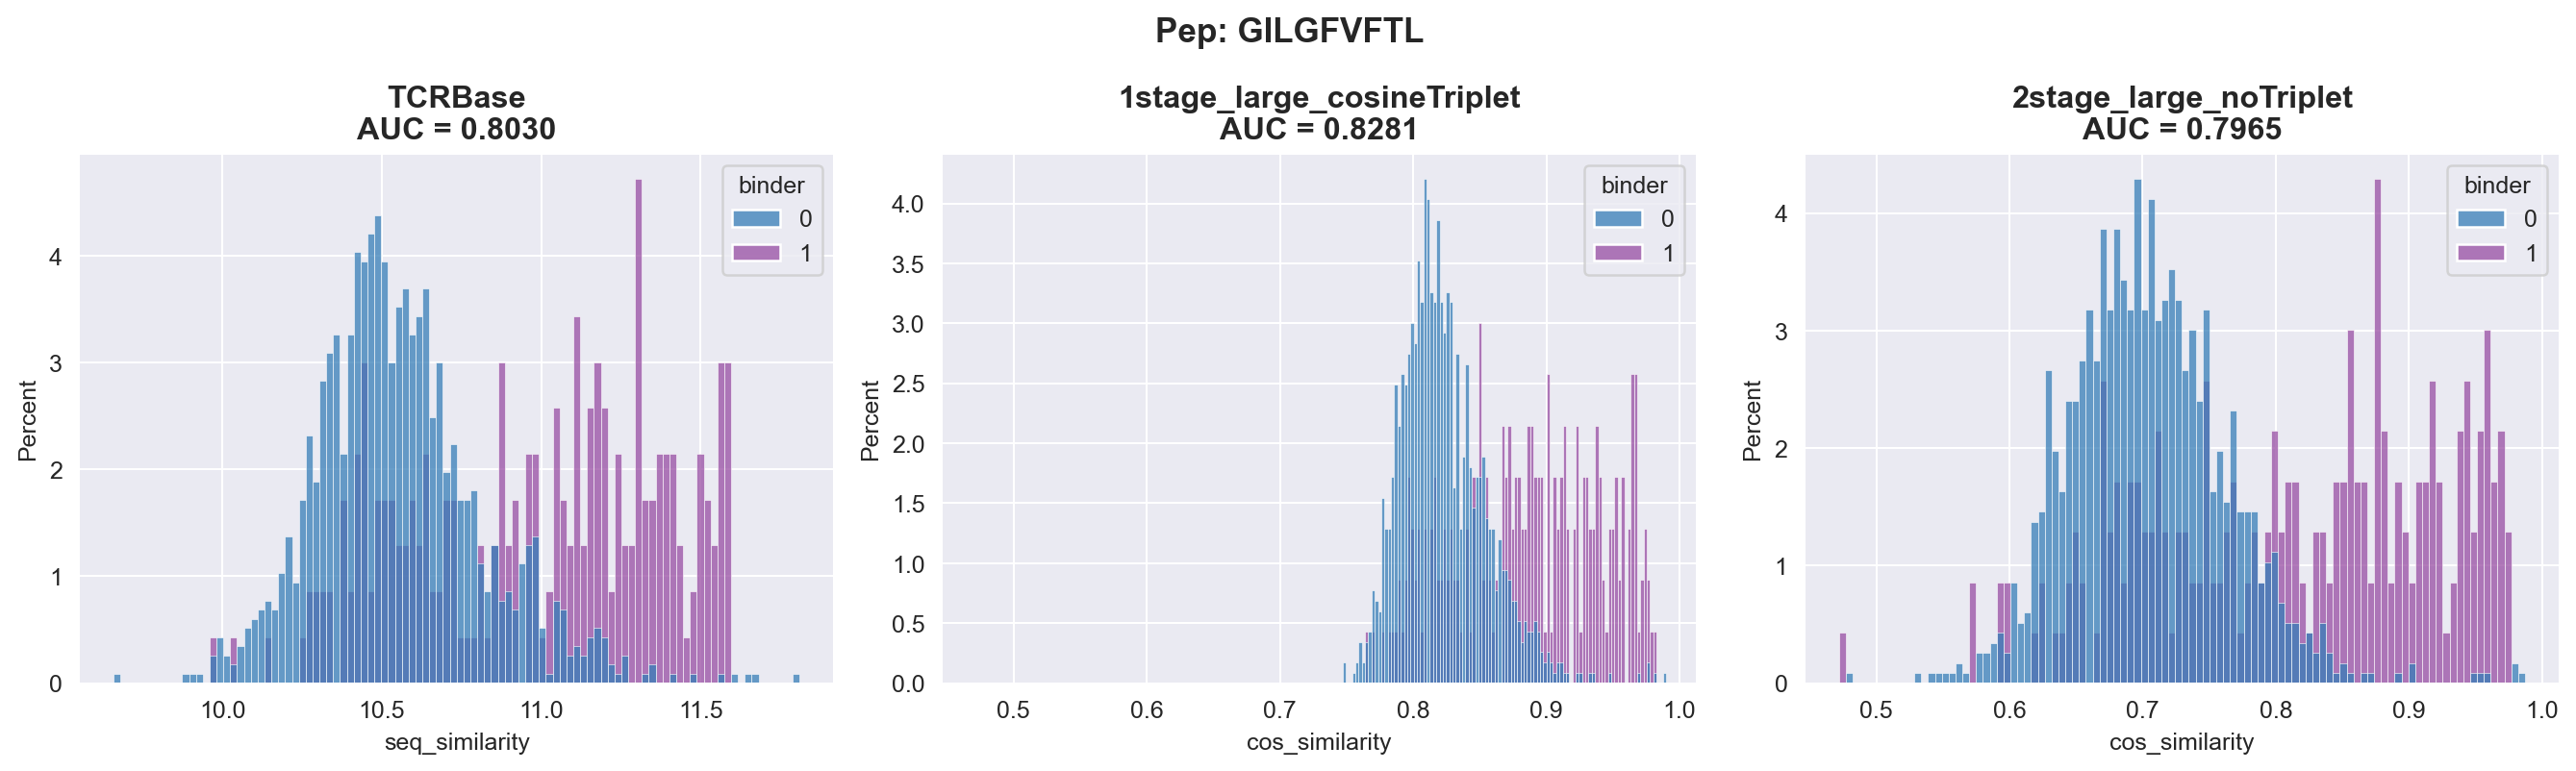

In [772]:
make_3_plots('GILGFVFTL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE/',
             name_old='1stage_large_cosineTriplet', name_new='2stage_large_noTriplet')

GILGFVFTL 0.803
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.80299, 'auc_01': 0.7191, 'auc_01_real': 0.46628, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.57919}


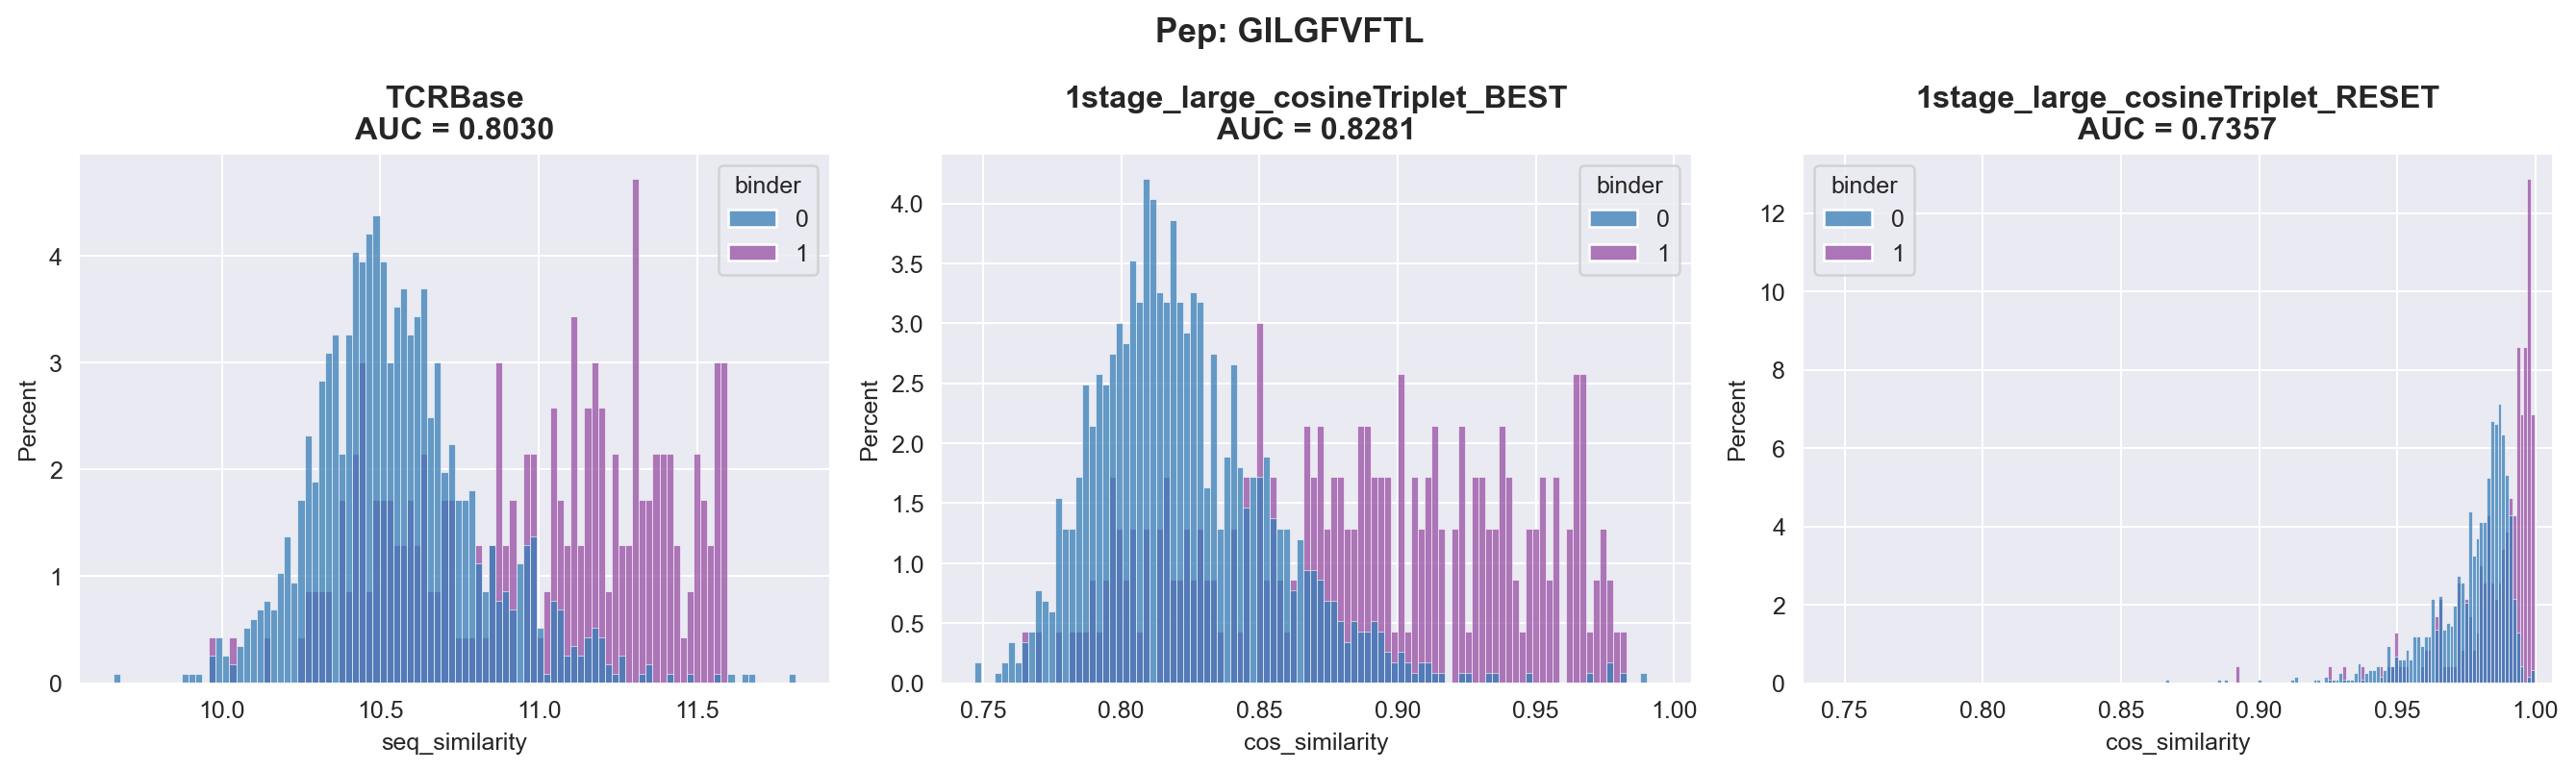

In [769]:
z = make_3_plots('GILGFVFTL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/RESET/RESET_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1444_SmCosTCRP1/',
             name_old='1stage_large_cosineTriplet_BEST', name_new='1stage_large_cosineTriplet_RESET')

GILGFVFTL 0.7475
{'peptide': 'GILGFVFTL', 'method': 'tcrbase', 'n_pos': 1095, 'auc': 0.74746, 'auc_01': 0.68567, 'auc_01_real': 0.40277, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.50236}


array([<Axes: title={'center': 'TCRBase_CDR3only\nAUC = 0.7475'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': '1stage_small_cdr3only\nAUC = 0.7395'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': '2stage_small_cdr3only\nAUC = 0.7203'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

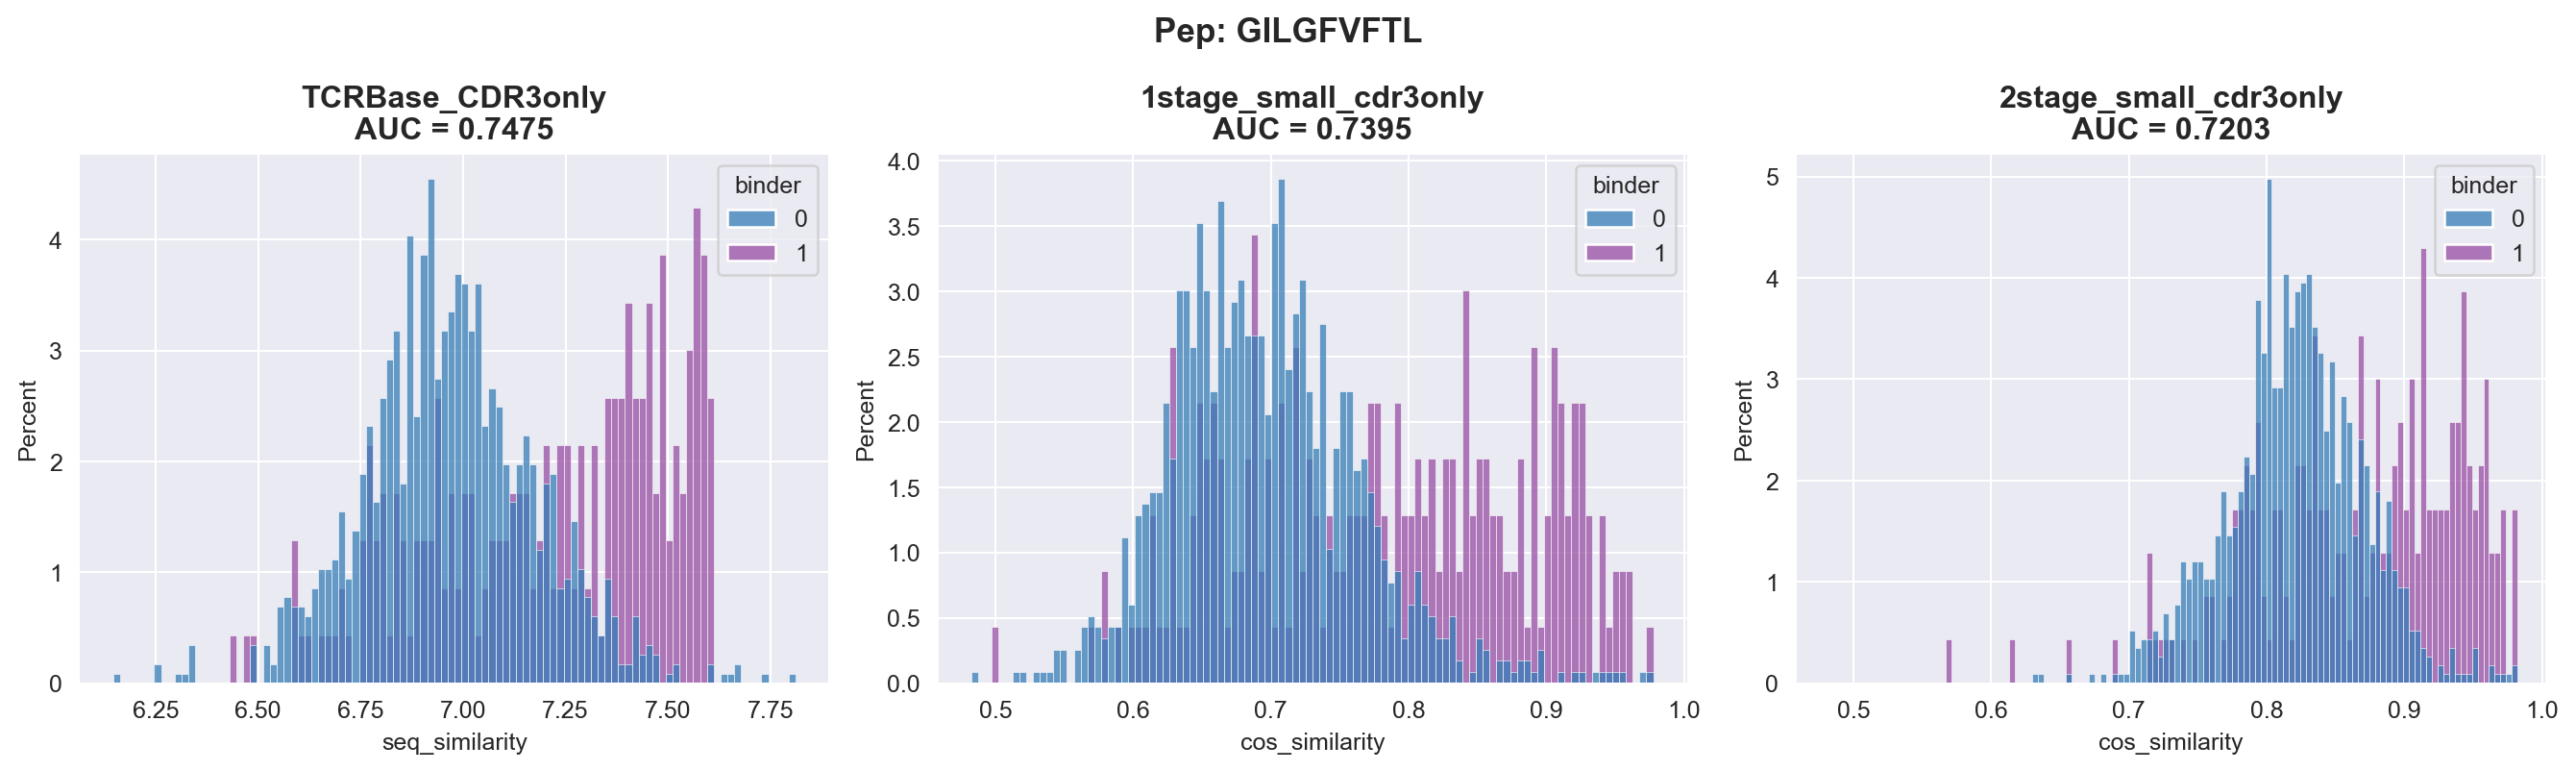

In [770]:
make_3_plots('GILGFVFTL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1343_ExpData_CDR3ONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1319_smCDR1ST/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1042_ExpData_CDR3ONLY_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1323_2stCDRsm/',
             '../output/TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/',
             '1stage_small_cdr3only', '2stage_small_cdr3only','TCRBase_CDR3only')

KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
KLGGALQAK 0.5739
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.57394, 'auc_01': 0.5419, 'auc_01_real': 0.12961, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.24869}


array([<Axes: title={'center': 'TCRBase_CDR3only\nAUC = 0.5739'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': '1stage_small_cdr3only\nAUC = 0.5916'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': '2stage_small_cdr3only\nAUC = 0.5793'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

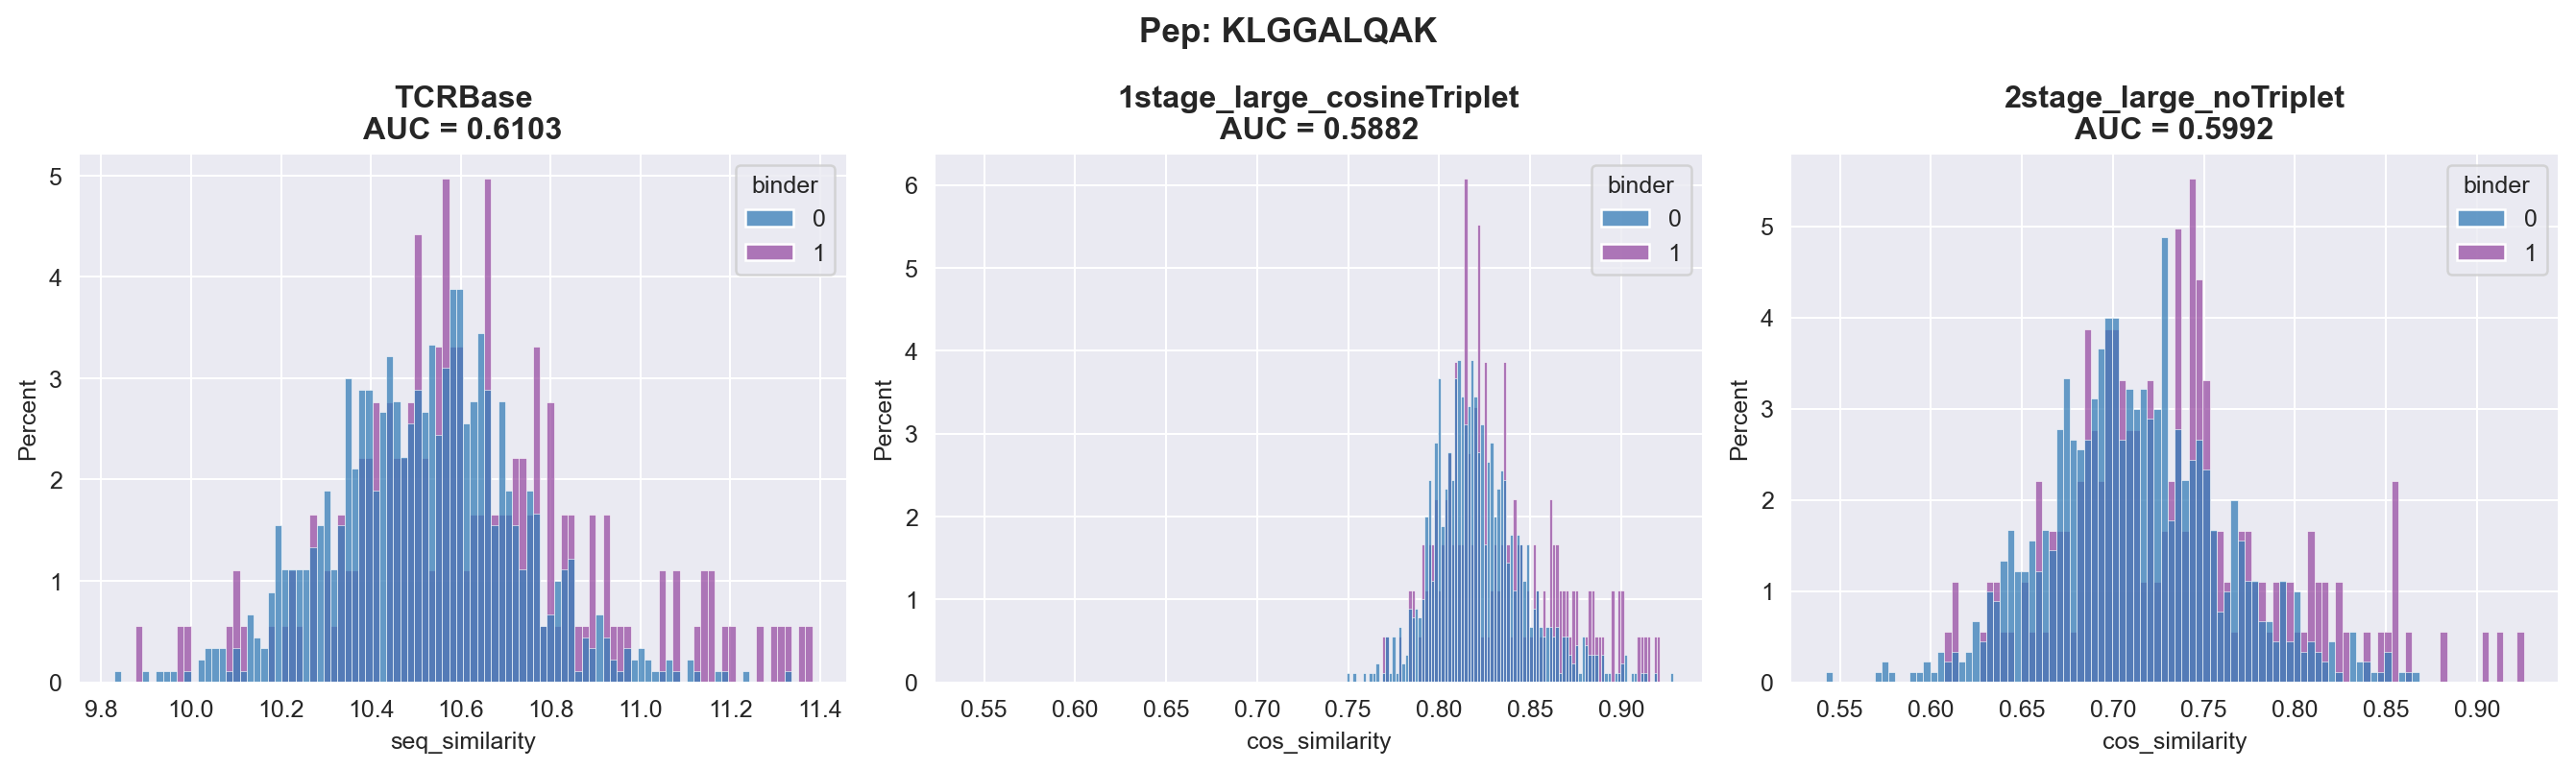

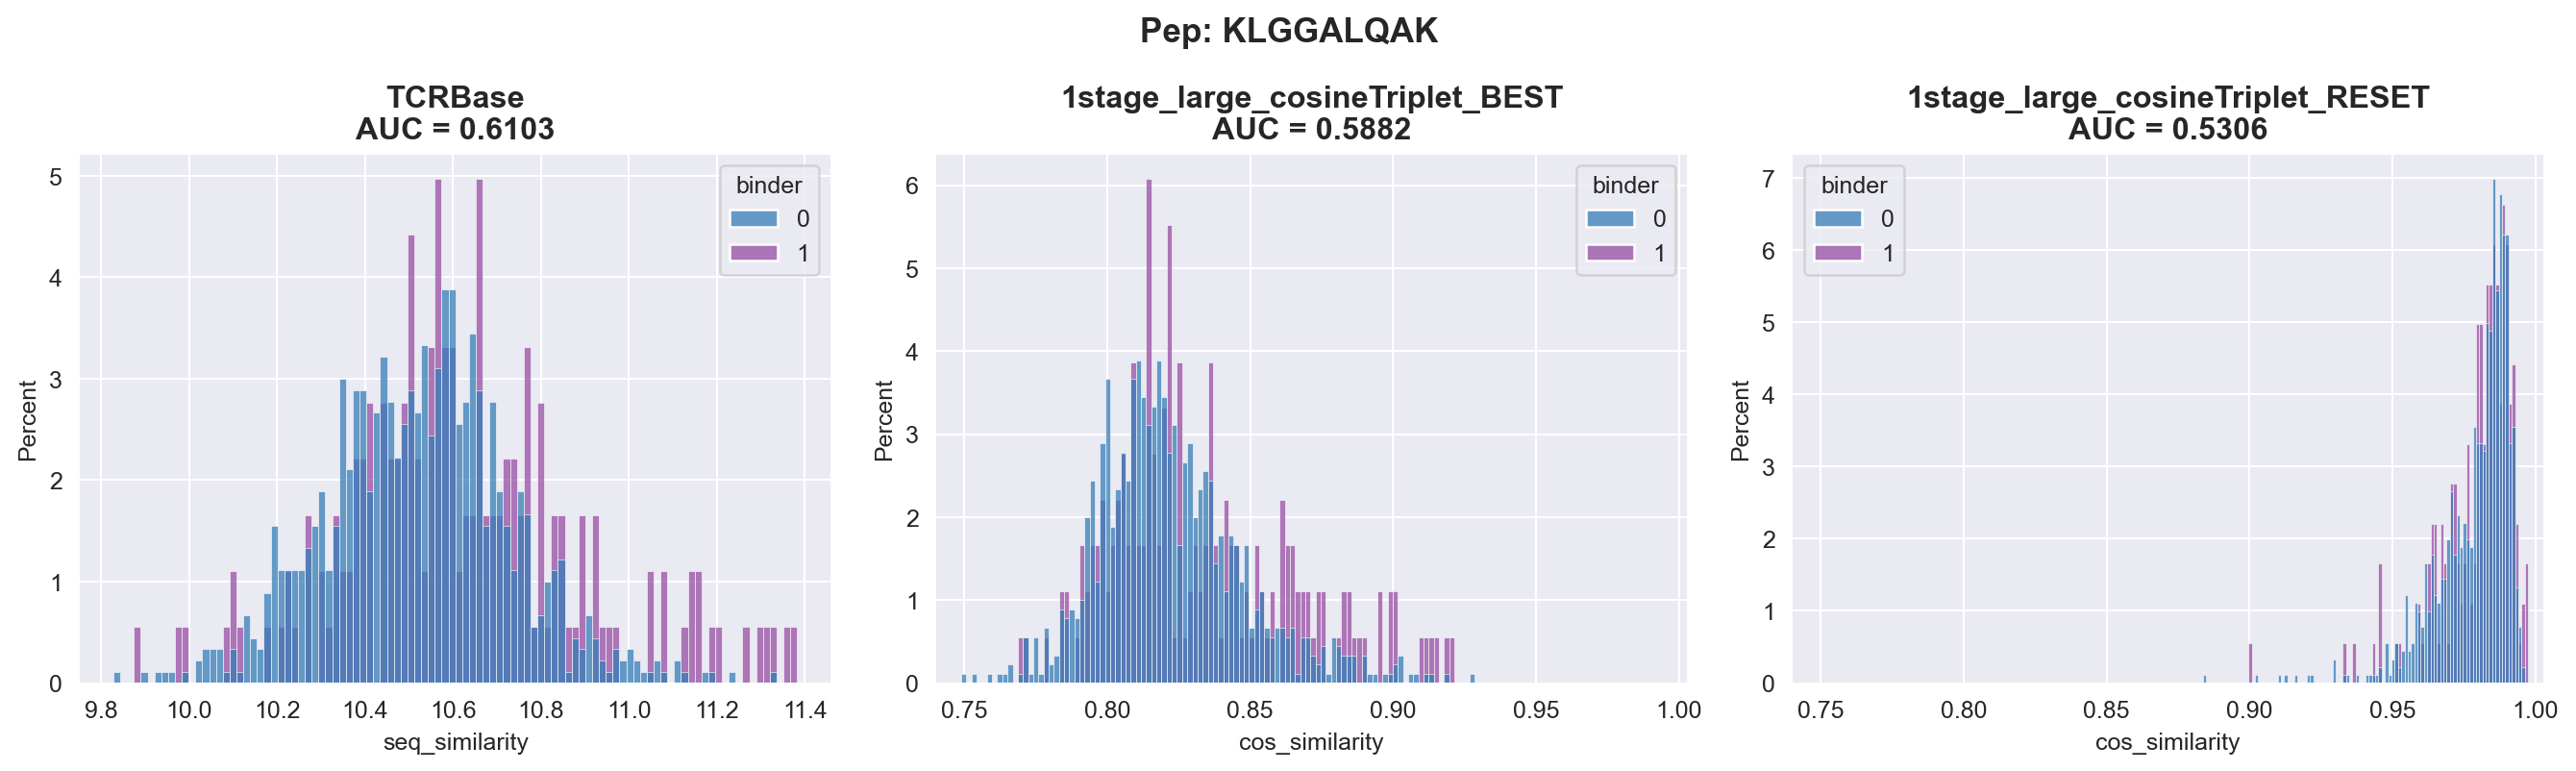

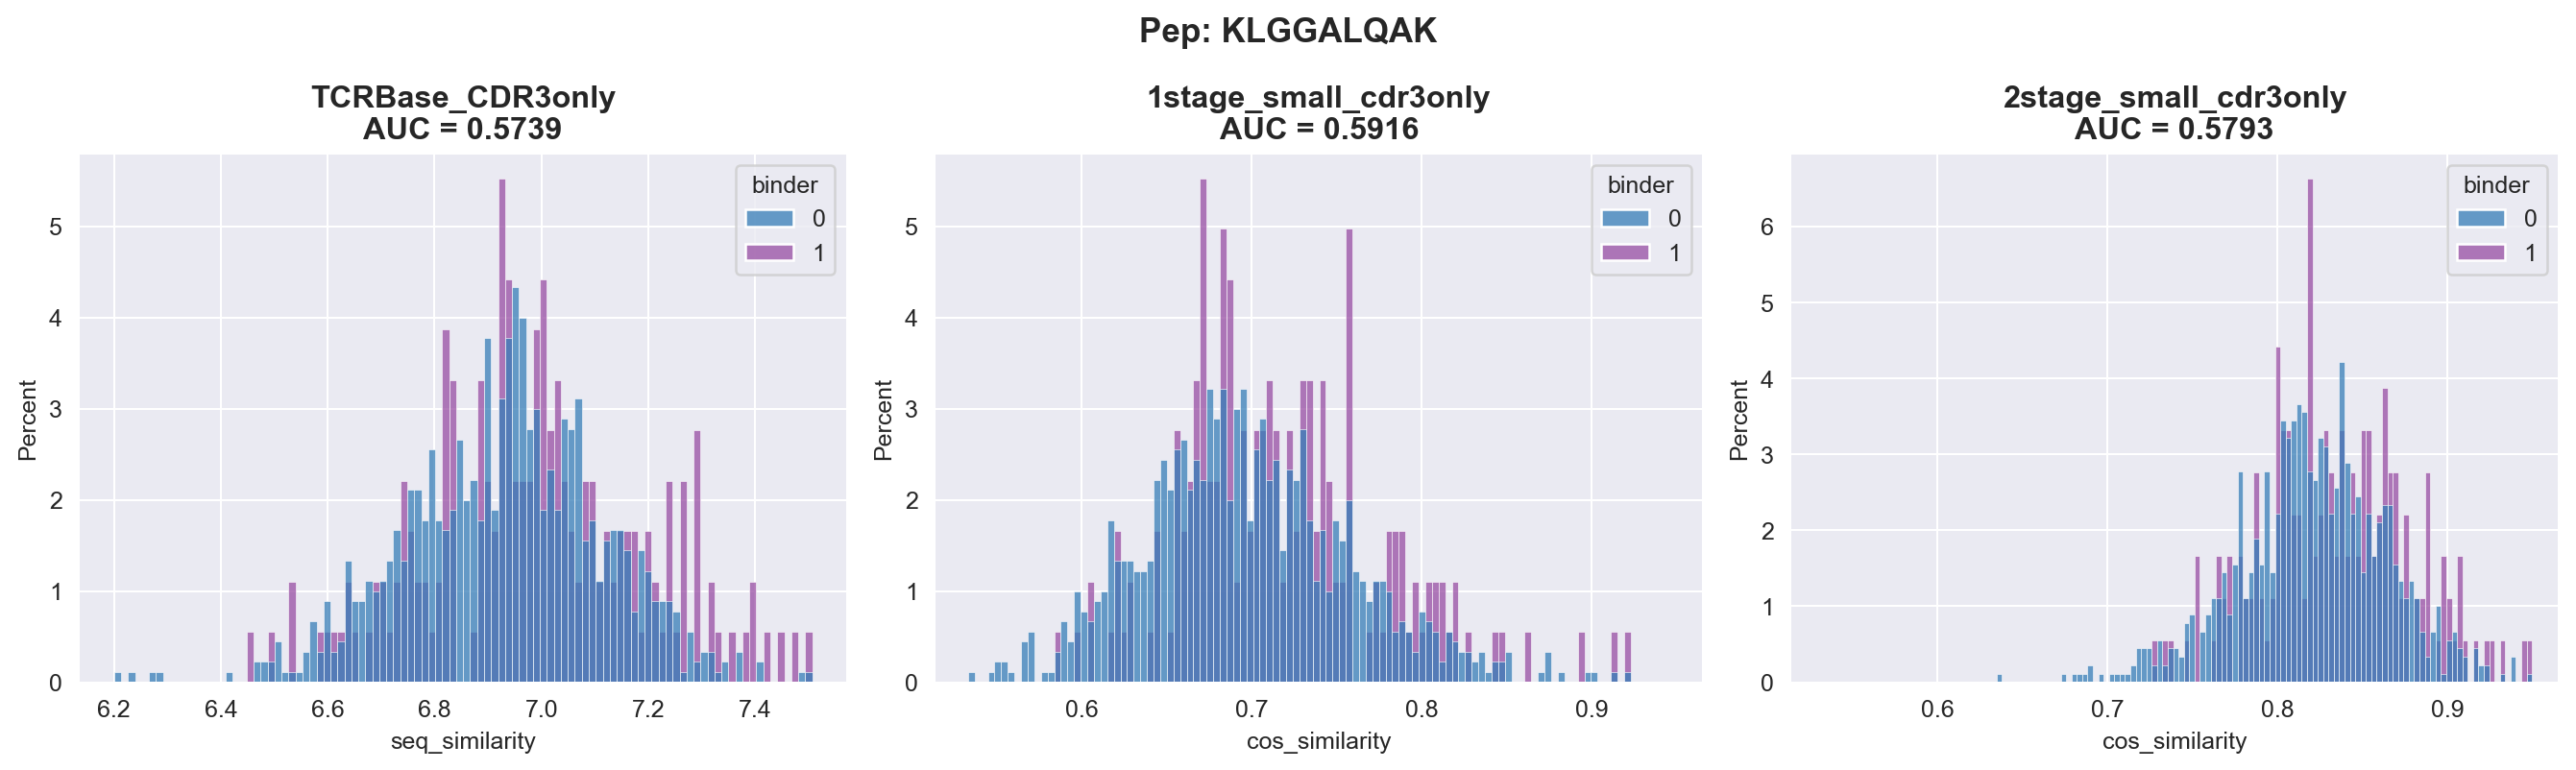

In [774]:
make_3_plots('KLGGALQAK', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE/',
             name_old='1stage_large_cosineTriplet', name_new='2stage_large_noTriplet')

make_3_plots('KLGGALQAK', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/RESET/RESET_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1444_SmCosTCRP1/',
             name_old='1stage_large_cosineTriplet_BEST', name_new='1stage_large_cosineTriplet_RESET')

make_3_plots('KLGGALQAK', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1343_ExpData_CDR3ONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1319_smCDR1ST/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1042_ExpData_CDR3ONLY_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1323_2stCDRsm/',
             '../output/TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/',
             '1stage_small_cdr3only', '2stage_small_cdr3only','TCRBase_CDR3only')

RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.76444}
RAKFKQLL 0.8618
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.86179, 'auc_01': 0.78016, 'auc_01_real': 0.58231, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.71408}
RAKFKQLL 0.8618
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.86179, 'auc_01': 0.78016, 'auc_01_real': 0.58231, 'precision': 0.16667, 'recall': 1.0, 'accuracy': 0.16667, 'AP': 0.71408}


array([<Axes: title={'center': 'TCRBase_CDR3only\nAUC = 0.8618'}, xlabel='seq_similarity', ylabel='Percent'>,
       <Axes: title={'center': '1stage_small_cdr3only_BEST\nAUC = 0.8175'}, xlabel='cos_similarity', ylabel='Percent'>,
       <Axes: title={'center': '1stage_small_cdr3only_RESET\nAUC = 0.7458'}, xlabel='cos_similarity', ylabel='Percent'>],
      dtype=object)

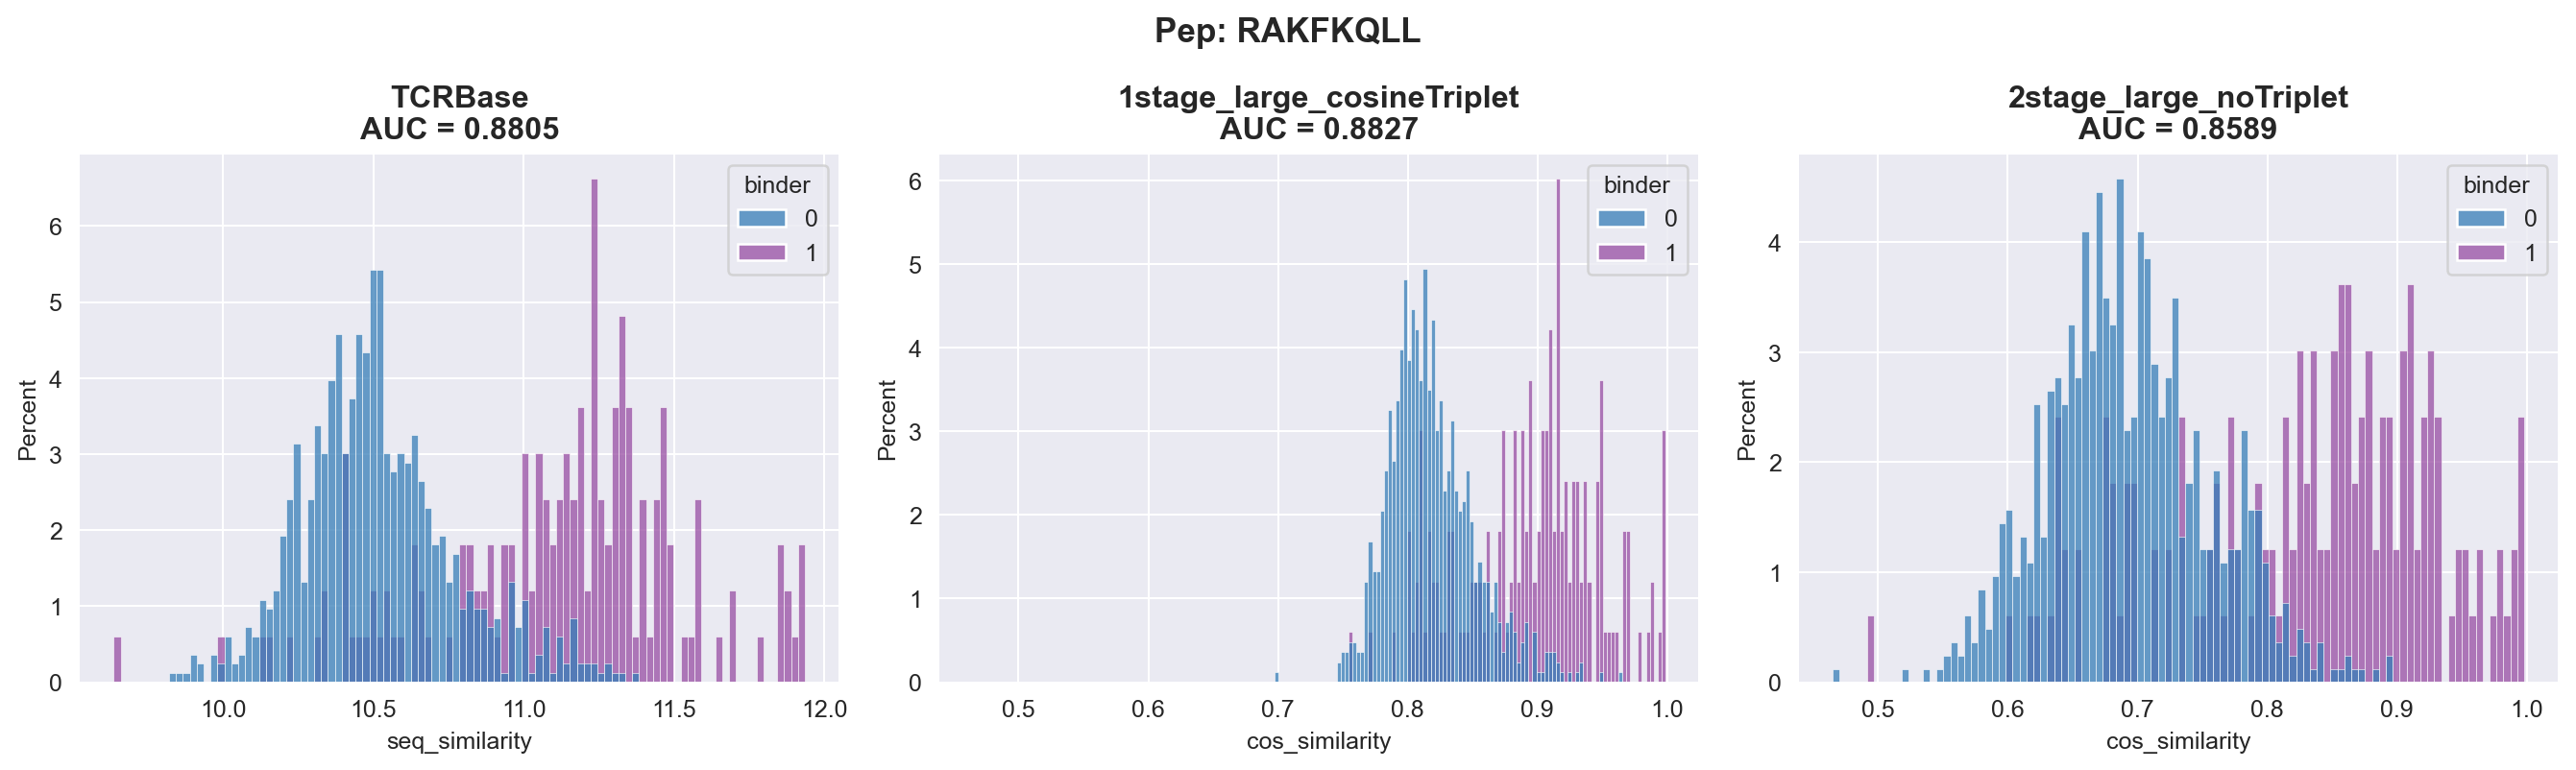

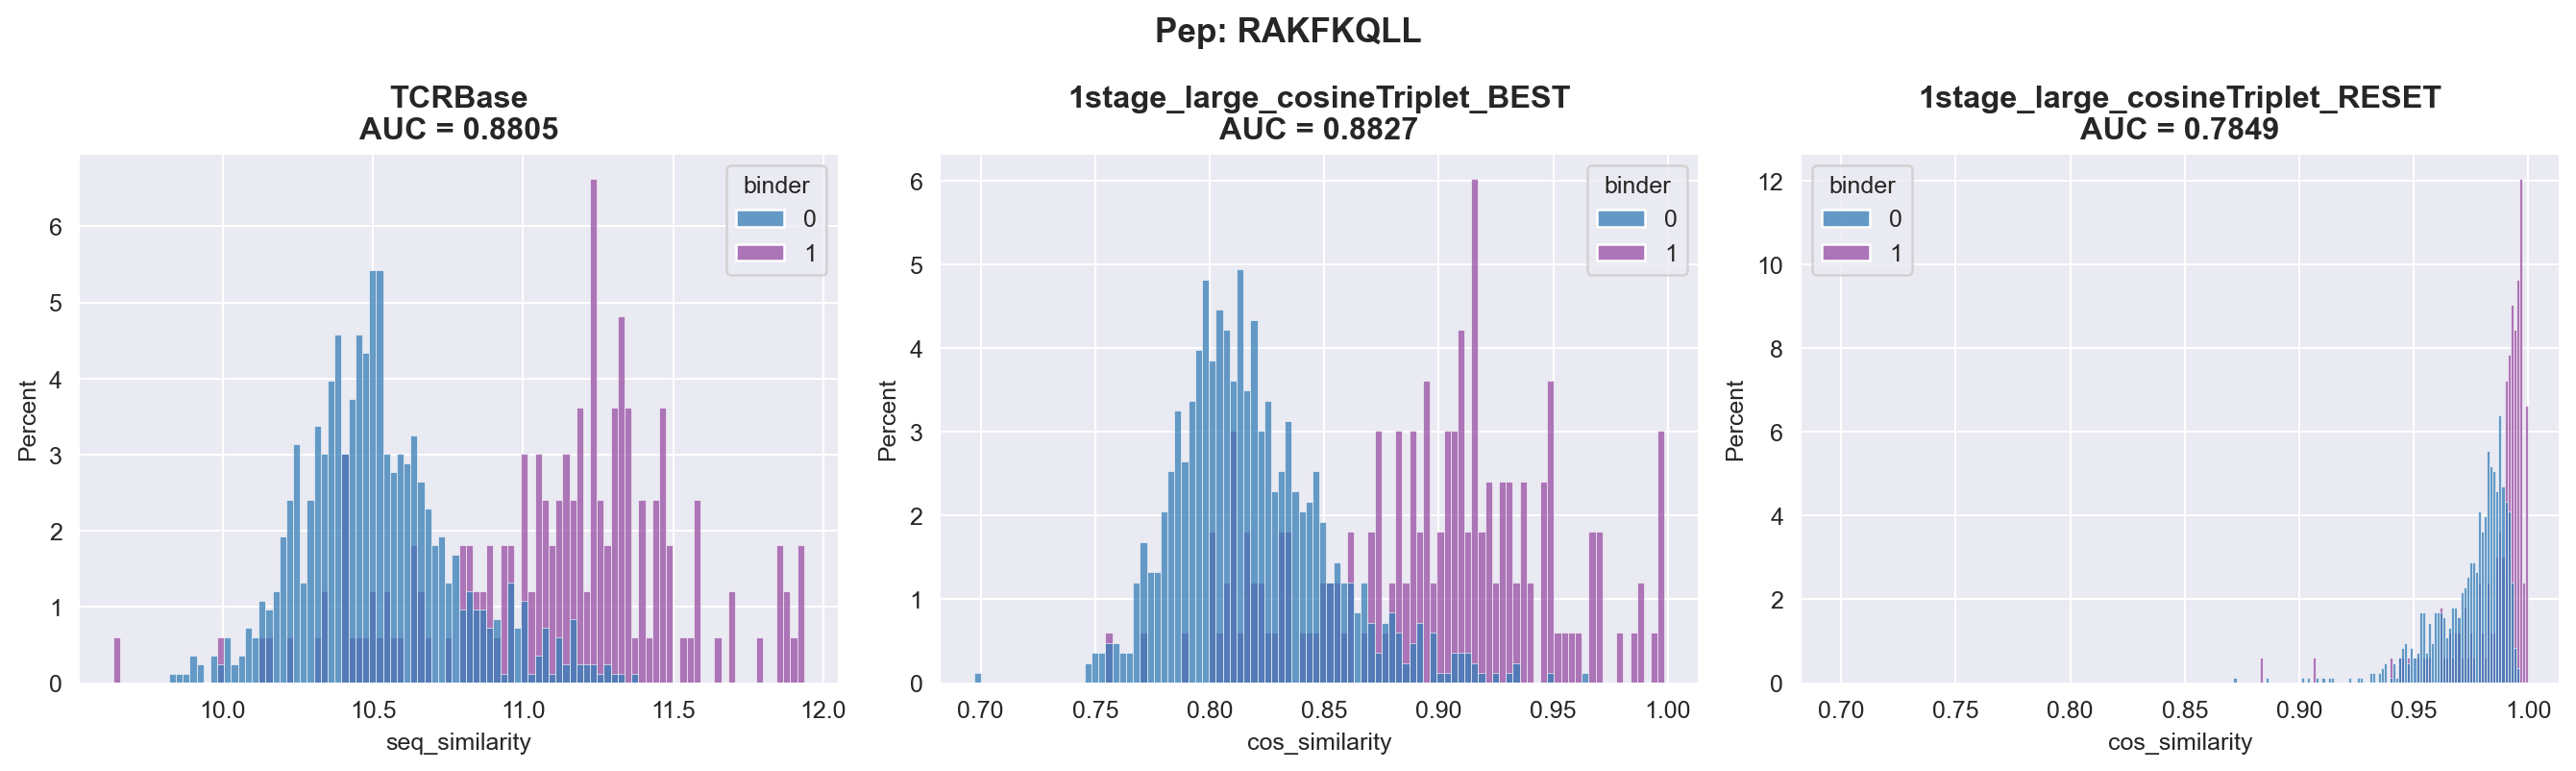

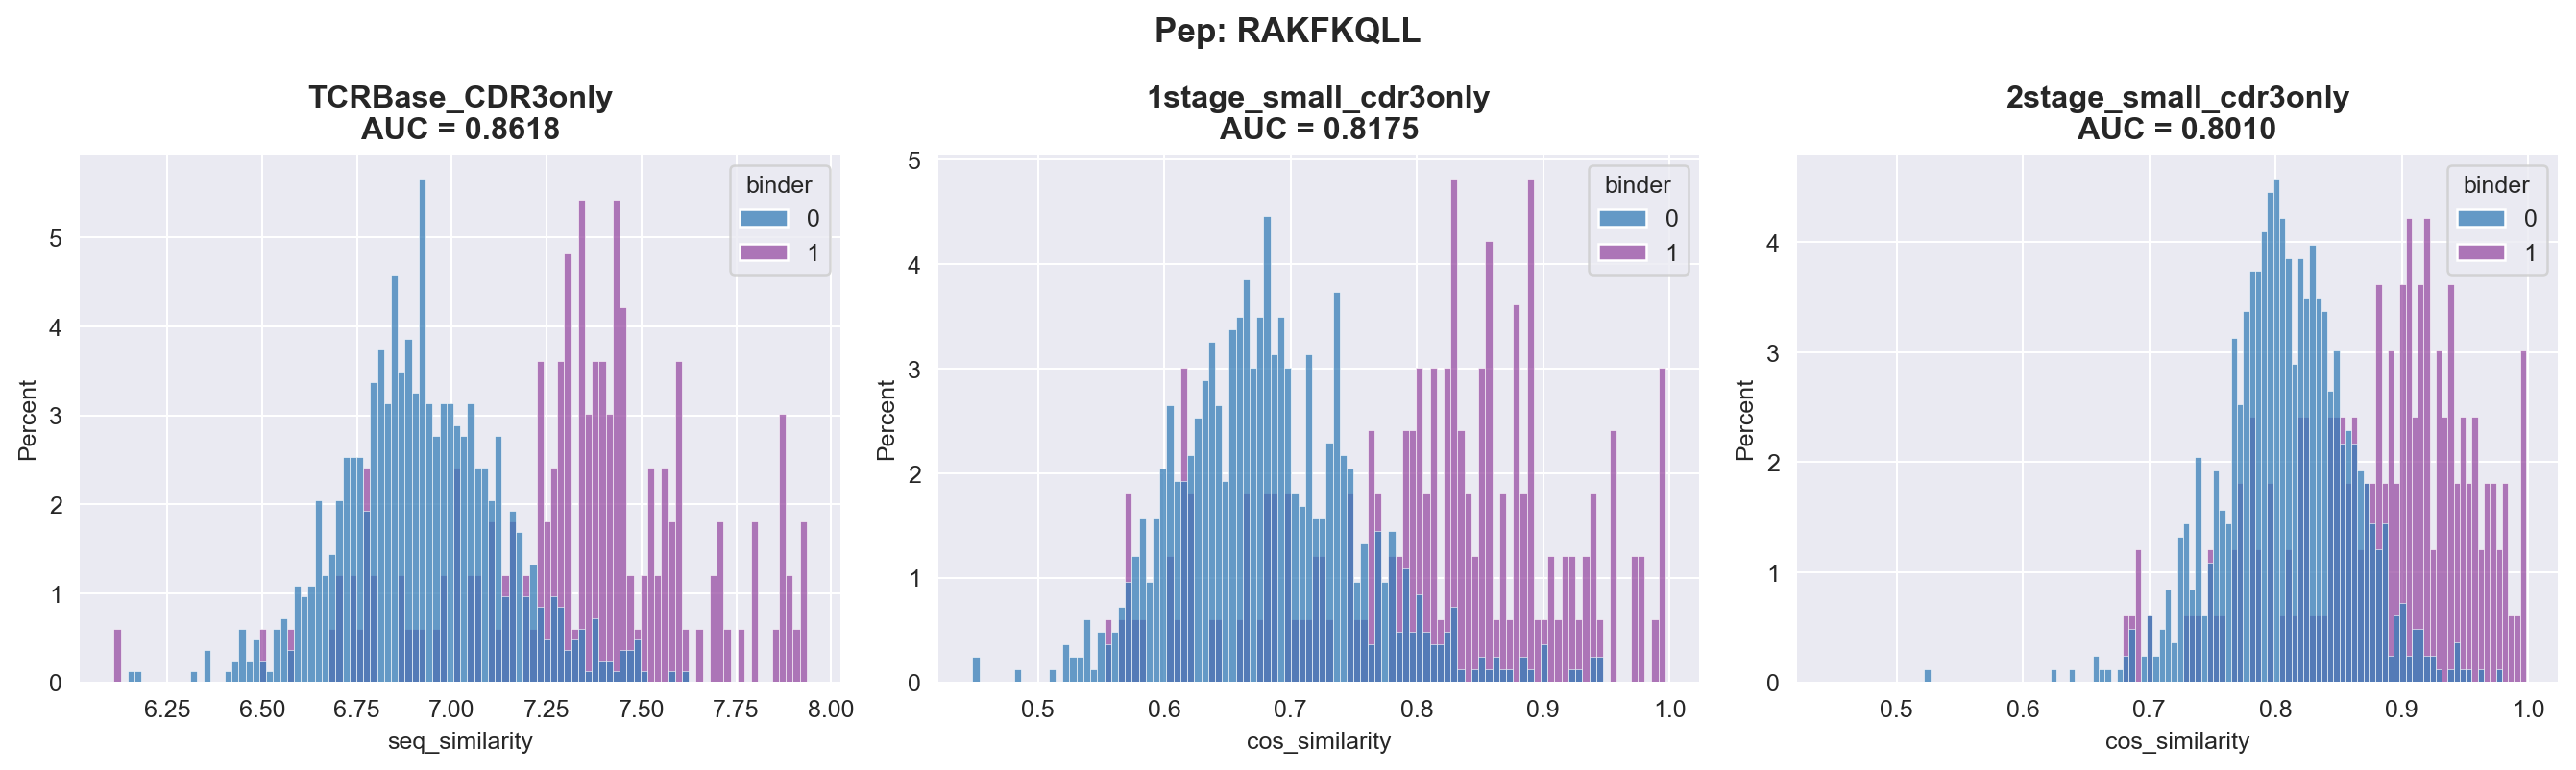

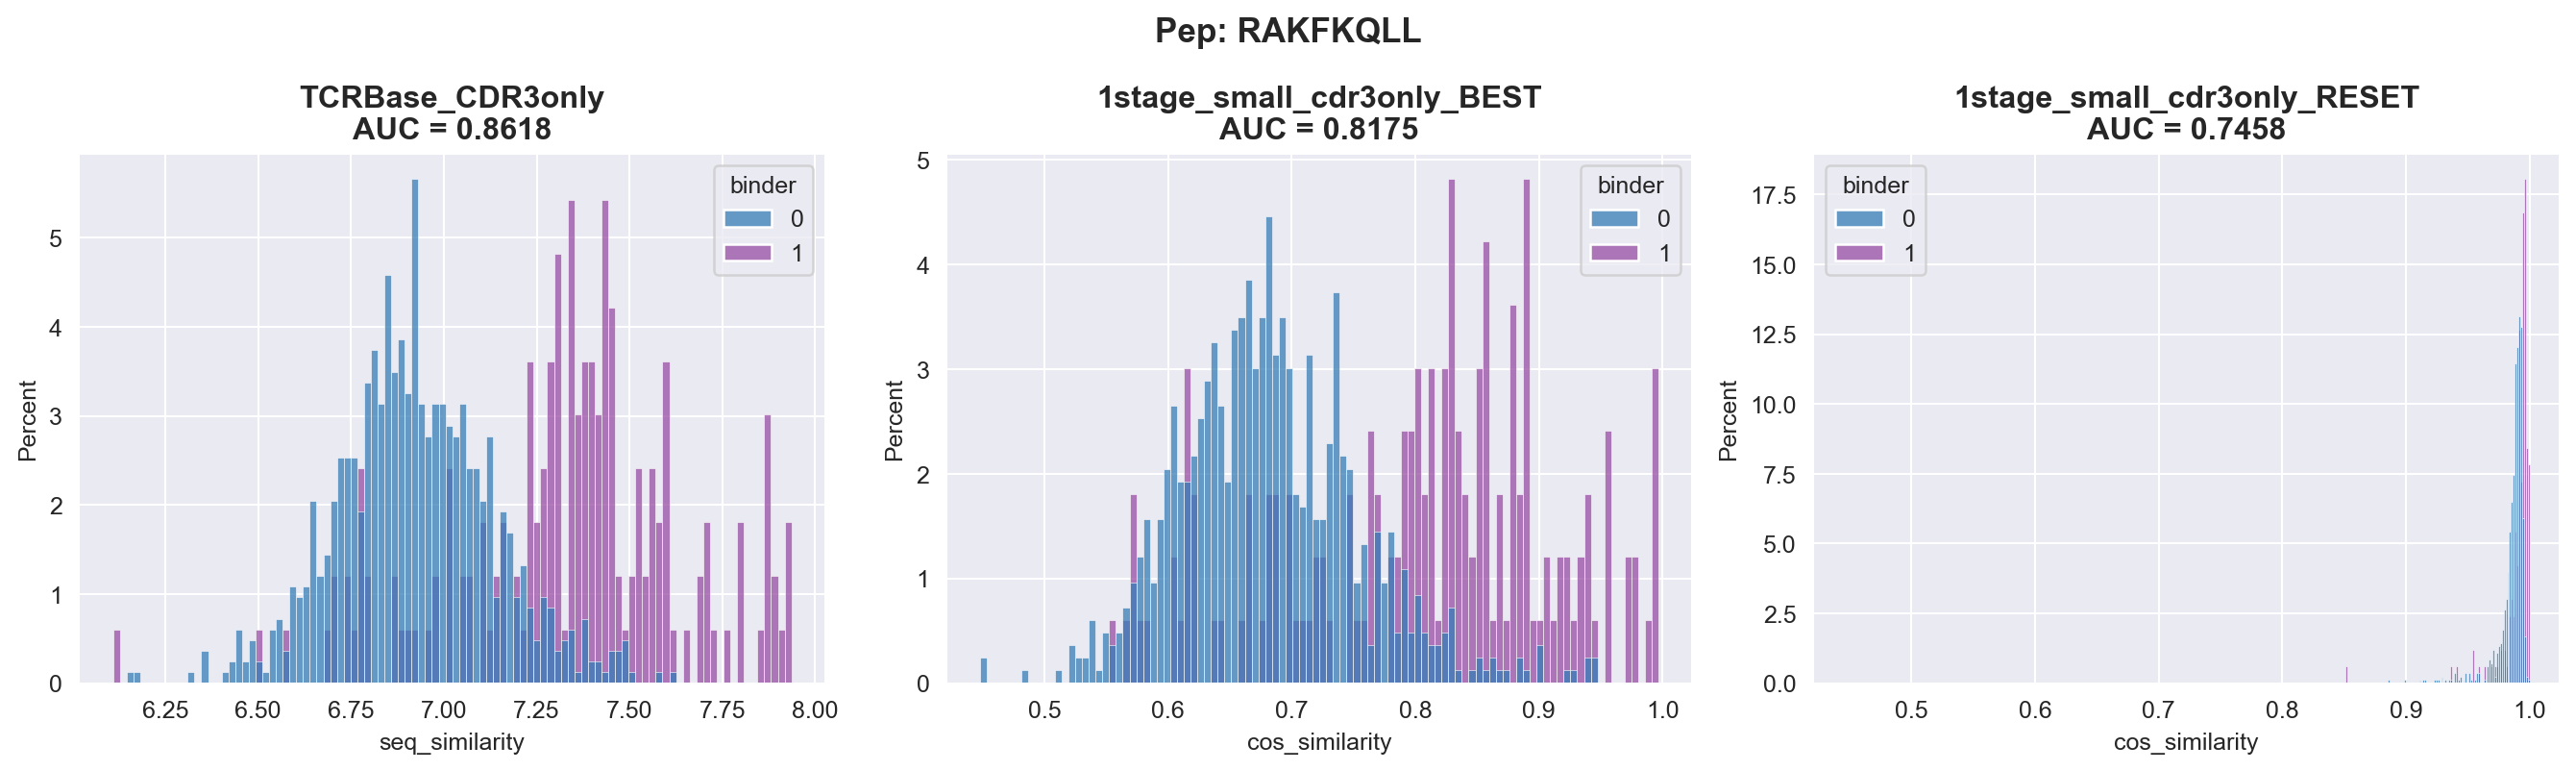

In [778]:
make_3_plots('RAKFKQLL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_1150_ExpData_TCRONLY_2stage_LARGE_256h_100l_NoTrp_KFold_0_KFold_0_240408_1332_2stTCRPLARGE/',
             name_old='1stage_large_cosineTriplet', name_new='2stage_large_noTriplet')

make_3_plots('RAKFKQLL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1441_SmCosTCRP1/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/RESET/RESET_tcrbase_240404_2342_ExpData_TCRONLY_1stage_LARGE_256h_100l_CosTrp_KFold_0_KFold_0_240408_1444_SmCosTCRP1/',
             name_old='1stage_large_cosineTriplet_BEST', name_new='1stage_large_cosineTriplet_RESET')

make_3_plots('RAKFKQLL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1343_ExpData_CDR3ONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1319_smCDR1ST/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1042_ExpData_CDR3ONLY_2stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1323_2stCDRsm/',
             '../output/TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/',
             '1stage_small_cdr3only', '2stage_small_cdr3only','TCRBase_CDR3only')

make_3_plots('RAKFKQLL', new_df, 
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/BEST/BEST_tcrbase_240405_1343_ExpData_CDR3ONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1319_smCDR1ST/',
             '../output/240405_SelectedVAEs_TCRBASE/tcrbase_outputs/RESET/RESET_tcrbase_240405_1343_ExpData_CDR3ONLY_1stage_SMALL_128h_64l_NoTrp_KFold_0_KFold_0_240408_1320_smCDR1ST/',
              '../output/TCRBASE/tcrbase_expanded_p0_swapped_CDR3ONLY/',
             name_old='1stage_small_cdr3only_BEST', name_new='1stage_small_cdr3only_RESET', name_tcrbase='TCRBase_CDR3only')


## check NetTCR maxpool vectors

In [ ]:
def make_3_plots(peptide, original_df, dir_old, dir_new, dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/',
                 name_old=None, name_new=None, name_tcrbase='TCRBase', bins=100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, dir_tcrbase)
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    

    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'{name_tcrbase}\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)

    # Align plot2 and 3 on xlim
    ax0_xlim = ax[1].get_xlim()
    ax1_xlim = ax[2].get_xlim()
    new_xlim = [min(ax0_xlim[0], ax1_xlim[0]), max(ax0_xlim[1], ax1_xlim[1])]
    ax[1].set_xlim(new_xlim)
    ax[2].set_xlim(new_xlim)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()
    return ax

In [ ]:
# Make each distance matrix and save them cause it's gonna be big as shit with 1120 maxpoold vector
# THIS IS DONE ON COMPUTEROME AT ${CDH}nettcr_maxpoolvectors/make_matrix.py≥

In [ ]:
def make_3_plots(peptide, original_df, dir_old, dir_new, dir_tcrbase='../output/TCRBASE/tcrbase_expanded_p0_swapped/',
                 name_old=None, name_new=None, name_tcrbase='TCRBase', bins=100):
    _, tcrbase_df = read_tcrbase_results(peptide, original_df, dir_tcrbase)
    _, tcrold_df = read_tcrvae_results(peptide, original_df, dir_old)
    _, tcrnew_df = read_tcrvae_results(peptide, original_df, dir_new)
    
    f,a = plt.subplots(1,3, figsize=(15,4.5))
    ax = a.ravel()
    name_old = 'Old VAE' if name_old is None else name_old
    name_new = 'New MMVAE' if name_new is None else name_new
    tcrbase_auc = roc_auc_score(tcrbase_df['binder'], tcrbase_df['score'])
    tcrold_auc = roc_auc_score(tcrold_df['binder'], tcrold_df['score'])
    tcrnew_auc = roc_auc_score(tcrnew_df['binder'], tcrnew_df['score'])
    

    sns.histplot(data = tcrbase_df.rename(columns={'score':'seq_similarity'}), x='seq_similarity', hue='binder', ax=ax[0], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[0].set_title(f'{name_tcrbase}\nAUC = {tcrbase_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrold_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[1], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[1].set_title(f'{name_old}\nAUC = {tcrold_auc:.4f}', fontweight='semibold',fontsize=13)
    sns.histplot(data = tcrnew_df.rename(columns={'score':'cos_similarity'}), x='cos_similarity', hue='binder', ax=ax[2], kde=False, stat='percent', common_norm=False, bins=bins, alpha=0.75)
    ax[2].set_title(f'{name_new}\nAUC = {tcrnew_auc:.4f}', fontweight='semibold',fontsize=13)

    # Align plot2 and 3 on xlim
    ax0_xlim = ax[1].get_xlim()
    ax1_xlim = ax[2].get_xlim()
    new_xlim = [min(ax0_xlim[0], ax1_xlim[0]), max(ax0_xlim[1], ax1_xlim[1])]
    ax[1].set_xlim(new_xlim)
    ax[2].set_xlim(new_xlim)
    f.suptitle(f'Pep: {peptide}', fontweight='semibold', fontsize=14)
    f.tight_layout()
    return ax

In [924]:
res.head()

min_dist                  most_similar  label
IQSQGGSEKLVASSLRDGSEAF       0.579322     ALSDQGNSGYALNASSQDWPAEKLF      1
ALSEAYAGGTSYGKLTASSLRDGSEAF  0.571473     ALSDQGNSGYALNASSQDWPAEKLF      1
AEMEGGSYIPTASSLRDGSEAF       0.562735  LVGDMRGGSNYQLIASSQDTGTVNSPLH      1
AEGGNTGKLIASSFPSGDGTQY       0.565636   LVGSPFPTSGTYKYIASSVAPGRDGYT      1
AAKEGGSEKLVSAGGNTEAF         0.603344        AASNRDSNYQLIASTYSFETQY      1

In [914]:
def do_tcrbase_and_histplots_local(dist_matrix, peptide, f=None, ax=None, unique_filename=None, outdir=None, bins=100):
    query = dist_matrix.query('set=="query"')
    database = dist_matrix.query('set=="database"')
    db_tcrs = database.index.tolist()
    # Scoring query against database & splitting by label
    pos = query[db_tcrs + ['binder']].query('binder==1')
    neg = query[db_tcrs + ['binder']].query('binder==0')
    tcrbase_output = pd.concat([pos, neg])
    pos = pos.drop(columns=['binder']).values
    neg = neg.drop(columns=['binder']).values

    # Getting the AUC for labelling and output DF ;
    pos_out = tcrbase_output.query('binder==1').drop(columns=['binder'])
    neg_out = tcrbase_output.query('binder!=1').drop(columns=['binder'])
    pos_out = pos_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    neg_out = neg_out.apply(lambda x: [np.min(x), x.index[int(np.argmin(x))]], axis=1, result_type='expand').rename(
        columns={0: 'min_dist', 1: 'most_similar'})
    cat_out = pd.concat([pos_out.assign(label=1), neg_out.assign(label=0)])
    auc = roc_auc_score(cat_out['label'], 1 - cat_out['min_dist'])

    # Plot both the distribution of scores and the "best" score as done above
    #   Plotting distribution of all scores
    pos_flat = pos.flatten()
    neg_flat = neg.flatten()
    cat = np.concatenate([pos_flat, neg_flat])
    labels = np.concatenate([np.array(['pos'] * len(pos_flat) + ['neg'] * len(neg_flat))])
    df_plot_allvsall = pd.DataFrame(data=np.stack([cat, labels]).T, columns=['distance', 'label'])
    df_plot_allvsall['distance'] = df_plot_allvsall['distance'].astype(float)
    pal = sns.color_palette('gnuplot2', 4)
    sns.set_palette([pal[-1], pal[0]])
    sns.set_style('darkgrid')

    if ax is None:
        f, ax = plt.subplots(1, 1, figsize=(9, 5))
    sns.histplot(data=df_plot_allvsall, x='distance', hue='label', ax=ax, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])
    ax.set_title(f'TCRBase: All vs All {peptide}: {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f.savefig(f'{outdir}{peptide}_AvA_TCRBase_distances_histplot_{unique_filename}', dpi=150,
                  bbox_inches='tight')

    #   Plotting "Best" score
    pos_best = pos.min(axis=1).flatten()
    neg_best = neg.min(axis=1).flatten()
    cat_best = np.concatenate([pos_best, neg_best])
    labels_best = np.concatenate([np.array(['pos'] * len(pos_best) + ['neg'] * len(neg_best))])
    df_plot_best = pd.DataFrame(data=np.stack([cat_best, labels_best]).T, columns=['distance', 'label'])
    df_plot_best['distance'] = df_plot_best['distance'].astype(float)
    f2, ax2 = plt.subplots(1, 1, figsize=(9, 5))
    bins = max(int(len(query.query('binder==1')) / 9), 25)

    sns.histplot(data=df_plot_best, x='distance', hue='label', ax=ax2, kde=False,
                 stat='percent', common_norm=False, bins=bins, alpha=0.75)
    # ax.set_xlim([0,1.1])

    ax2.set_title(f'TCRBase: Best score {peptide}, AUC = {auc:.4f}', fontsize=14, fontweight='semibold')
    if unique_filename is not None:
        outdir = './' if outdir is None else outdir
        f2.savefig(f'{outdir}{peptide}_Best_TCRBase_distances_histplot_{unique_filename}', dpi=150, bbox_inches='tight')

    return cat_out

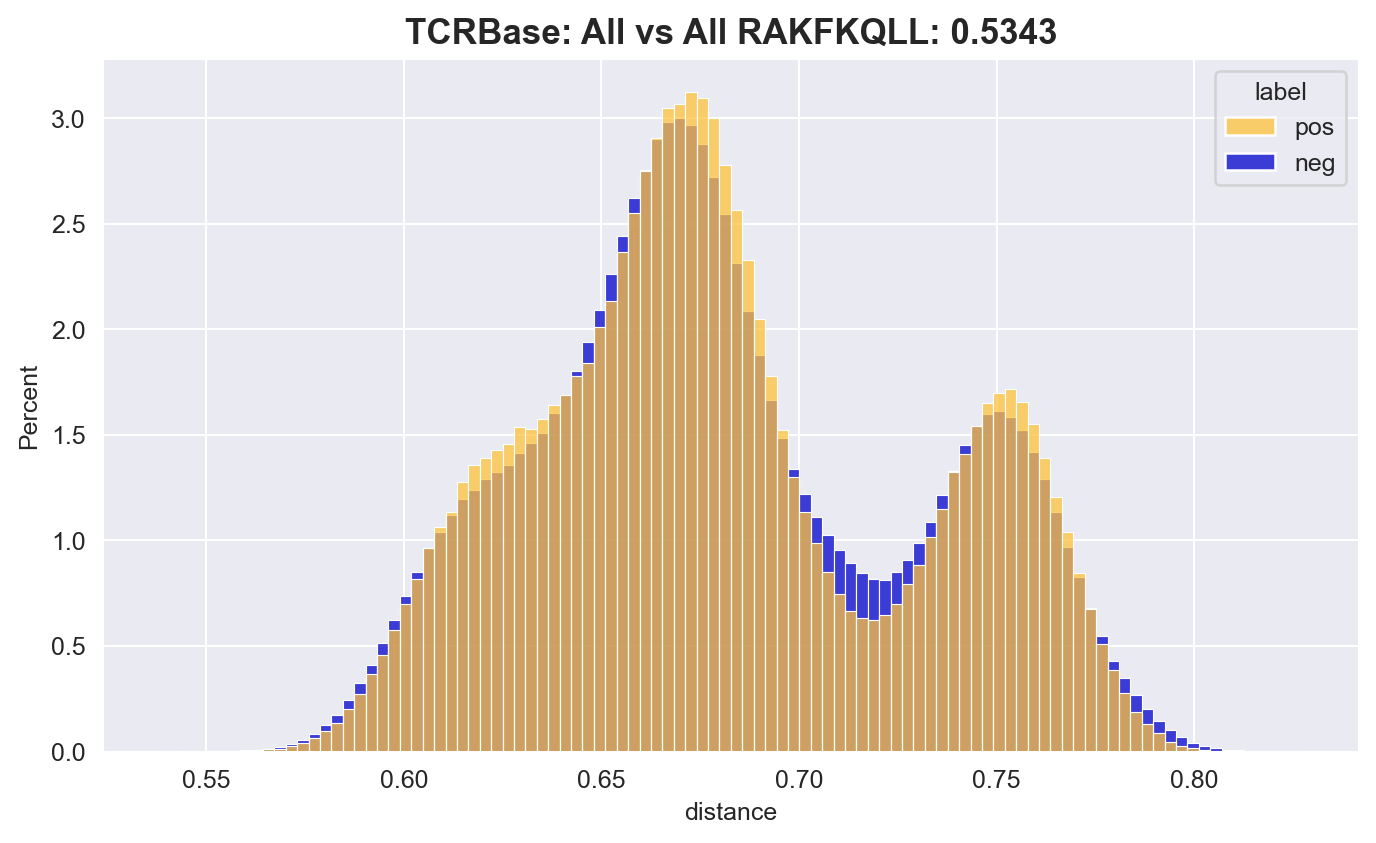

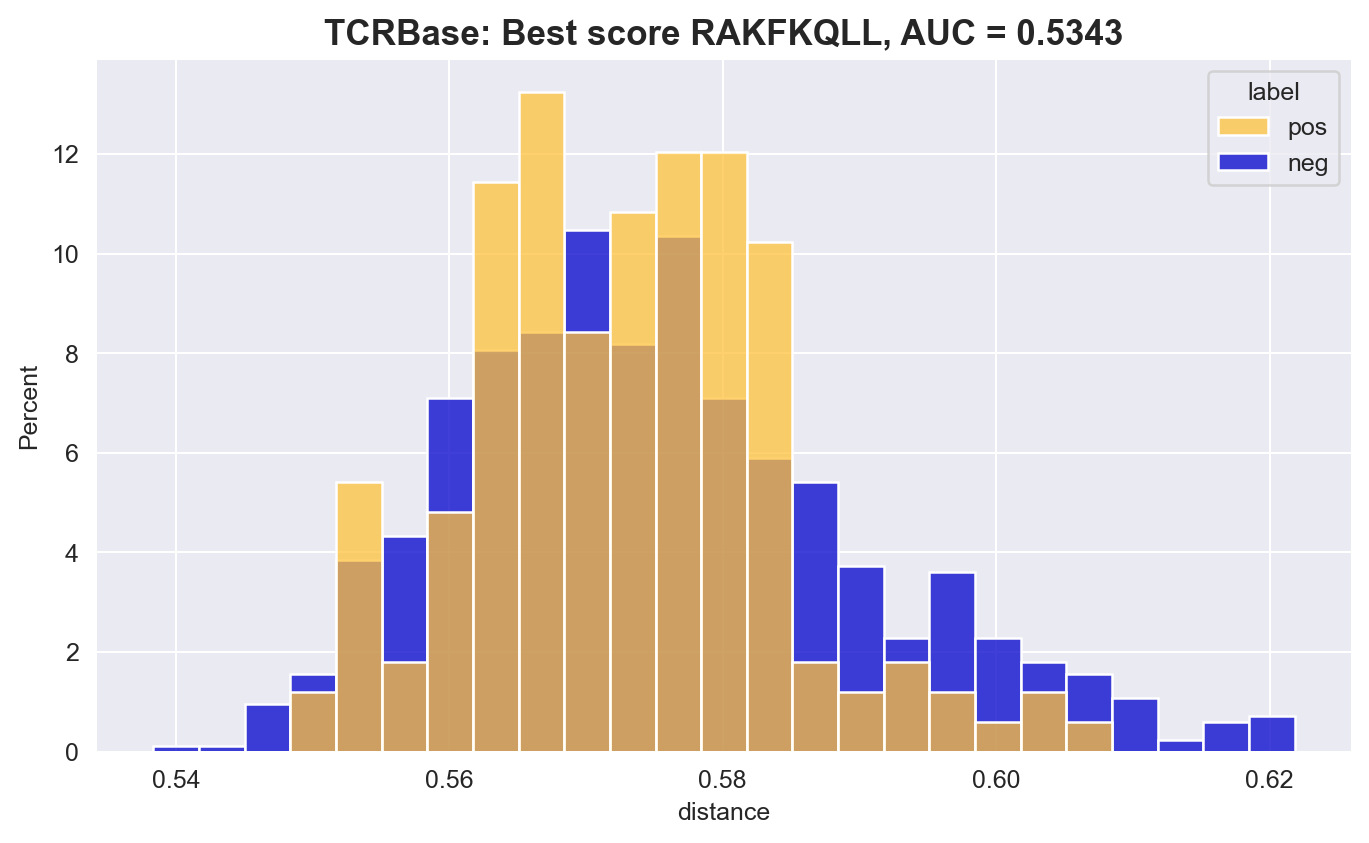

In [922]:
pep = 'RAKFKQLL'
dm = pd.read_csv(f'../output/240410_MaxPoolVectorDistMatrices/dist_{pep}_v_3.csv', index_col=0)
res = do_tcrbase_and_histplots_local(dm, f'{pep}')

# Check where the performance comes from in the reset "random" models

In [606]:
wtfdf = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')

In [611]:
# Run one more with original pep column deleted to make sure ??
wtfdf.drop(columns=['original_peptide']).to_csv('../data/multimodal/240404_nettcr_swapped_no_original.csv', index=False)

In [632]:
wtfdf

peptide       A1        A2              A3     B1      B2  \
0      AVFDRKSDAK  TSDQSYG  QGSYDEQN     ALHSGGYQKVT  MNHEY  SMNVEV   
1       KLGGALQAK  TISGTDY     GLTSN     ILTETSYDKVI  SEHNR  FQNEAQ   
2      ELAGIGILTV  TSESDYY  QEAYKQQN       AYMDNNDMR  SGDLS  YYNGEE   
3      TTDPSFLGRY   ATGYPS   ATKADDK      ALSGNTDKLI  MDHEN  SYDVKM   
4      AVFDRKSDAK    TSINN   IRSNERE  ATYSITQGGSEKLV  MRHNA  SNTAGT   
...           ...      ...       ...             ...    ...     ...   
58609  AVFDRKSDAK  TSDQSYG  QGSYDEQN  AMRDFEDSGNTPLV  LNHDA  SQIVND   
58610    RAKFKQLL  TRDTTYY  RNSFDEQN   ALSAVGTNAGKST  MNHEY  SMNVEV   
58611   GILGFVFTL    SIFNT   LYKAGEL   AGQNYGGATNKLI  SEHNR  FQNEAQ   
58612  ELAGIGILTV   SSYSPS  YTSAATLV     VVSDRNFNKFY  ENHRY  SYGVKD   
58613   VAANIVLTV    TSINN   IRSNERE       AVTGANNLF  LNHDA  SQIVND   

                  B3       allele  partition  binder           origin  \
0        ASSPTRPVEQY  HLA-A*11:01          4       0  peptide_swapped   
1      ASASLGGGLYEQY  HLA-A*03:01          0       0  peptide_swapped   
2       ASSDGQGGYGYT  HLA-A*02:01          3       0  peptide_swapped   
3      ASSLAGGIVDEQF  HLA-A*01:01          1       1            VDJdb   
4      ASSPSTYKYNEQF  HLA-A*11:01          1       0  peptide_swapped   
...              ...          ...        ...     ...              ...   
58609    ASSTYSRDTQY  HLA-A*11:01          2       0  peptide_swapped   
58610  ASRIGGAGNSPLH  HLA-B*08:01          3       0  peptide_swapped   
58611   ASSIDNFYDEQF  HLA-A*02:01          4       0  peptide_swapped   
58612     AGRDHTDTQY  HLA-A*02:01          2       0  peptide_swapped   
58613   ASSIEGPTGELF  HLA-A*02:01          0       1            VDJdb   

      original_peptide    raw_index  \
0            GILGFVFTL  VDJdb_65943   
1             RAKFKQLL    ITRAP_793   
2            KLWAQCVQL  VDJdb_78926   
3           TTDPSFLGRY  VDJdb_69875   
4            KTFPPTEPK  VDJdb_81316   
...                ...          ...   
58609        GILGFVFTL  VDJdb_24577   
58610       TPRVTGGGAM  VDJdb_74917   
58611        KLGGALQAK   ITRAP_2470   
58612        CTELKLNDY   IEDB_27207   
58613        VAANIVLTV  VDJdb_24025   

                                                 reference  \
0                                                 28636592   
1                                                 37133356   
2                                                 34793243   
3      https://github.com/antigenomics/vdjdb-db/issues/326   
4                                                 35750048   
...                                                    ...   
58609                                             29483513   
58610                                             34793243   
58611                                             37133356   
58612                                             30575715   
58613                                             29429978   

           source_organism input_type  
0               InfluenzaA    tcr_pep  
1                      NaN    tcr_pep  
2               SARS-CoV-2    tcr_pep  
3               SARS-CoV-2    tcr_pep  
4               SARS-CoV-2    tcr_pep  
...                    ...        ...  
58609           InfluenzaA    tcr_pep  
58610                  CMV    tcr_pep  
58611                  NaN    tcr_pep  
58612  H1N1 subtype (H1N1)    tcr_pep  
58613          HomoSapiens    tcr_pep  

[58614 rows x 16 columns]

In [635]:
wtfdf['cdr12'] = wtfdf.apply(lambda x: x['A1']+x['A2']+x['B1']+x['B2'], axis=1)
len(wtfdf['cdr12'].unique())

1500

## Check per-peptide performance for various predictions (Best, Reset, BLOSUM) for given VAEsFrozenCLFs

### For SmCDR3 comparisons

In [659]:
# On a per-peptide basis, compare First, Reset, BLOSUM and see where/who wins
best = pd.read_csv('../output/240404_RESET_PARAMS_LATENT_TEST/CDR3_1stage_BEST_KFold_0_240405_1408_SmCDR3one/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_CDR3_VAE_1stage_KFold_0_240405_1408_SmCDR3one.csv')
reset = pd.read_csv('../output/240404_RESET_PARAMS_LATENT_TEST/CDR3_1stage_WITH_RESET_KFold_0_240405_1158_SmCDR3/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_CDR3_1stage_WITH_RESET_KFold_0_240405_1158_SmCDR3.csv')
blsm = pd.read_csv('../output/240404_RESET_PARAMS_LATENT_TEST/CDR3_BLOSUM_only_noLatent_KFold_0_240405_1201_frVvuv/valid_predictions_f00_CDR3_BLSMonly_noLatent_KFold_0_240405_1201_frVvuv.csv')

pep_order = wtfdf.groupby('peptide').agg(count=('B3','count')).sort_values('count', ascending=False).index

print('CDR3 ONLY MODELS\tBEST\t\tRESET\t\tBLOSUM\t\tN Binders')
results = []
for p in pep_order:
    best_metrics = get_metrics(best.query('peptide==@p')['binder'], best.query('peptide==@p')['pred_prob'])
    reset_metrics = get_metrics(reset.query('peptide==@p')['binder'], reset.query('peptide==@p')['pred_prob'])
    blsm_metrics = get_metrics(blsm.query('peptide==@p')['binder'], blsm.query('peptide==@p')['pred_prob'])
    print(f"{p}\t\t{best_metrics['auc']}\t\t{reset_metrics['auc']}\t\t{blsm_metrics['auc']}\t\t{len(best.query('peptide==@p and binder==1'))}")
    results.append({'peptide':p, 'best':best_metrics['auc'], 'reset':reset_metrics['auc'], 'blsm':blsm_metrics['auc'], 'npos':len(best.query('peptide==@p and binder==1'))})
results = pd.DataFrame(results)
results['d_best_blsm'] = round(results['best']-results['blsm'], 4)
results['d_best_reset'] = round(results['best']-results['reset'], 4)
results['d_reset_blsm'] = round(results['reset']-results['blsm'], 4)
results.to_csv('../output/240404_RESET_PARAMS_LATENT_TEST/CDR3_SingleStageVAE_comps.tsv', index=False, sep='\t')

CDR3 ONLY MODELS	BEST		RESET		BLOSUM		N Binders
GILGFVFTL		0.7877		0.7559		0.8109		233
KLGGALQAK		0.5955		0.5652		0.6255		181
RAKFKQLL		0.812		0.728		0.8776		166
AVFDRKSDAK		0.6016		0.5627		0.6165		143
ELAGIGILTV		0.857		0.6966		0.8951		92
SPRWYFYYL		0.7134		0.6177		0.7514		89
YLQPRTFLL		0.752		0.647		0.7405		80
TTDPSFLGRY		0.6488		0.5998		0.6375		78
LLWNGPMAV		0.8449		0.8448		0.8861		75
NLVPMVATV		0.6496		0.6684		0.5903		74
IVTDFSVIK		0.5953		0.5413		0.6145		63
GLCTLVAML		0.7383		0.6585		0.7794		55
CINGVCWTV		0.7307		0.6423		0.8372		45
QYIKWPWYI		0.6524		0.4473		0.5853		27
LTDEMIAQY		0.684		0.6014		0.6136		26
KTFPPTEPK		0.5714		0.6001		0.5977		24
ATDALMTGF		0.7199		0.7913		0.7641		20
DATYQRTRALVR		0.6244		0.7053		0.724		18
KSKRTPMGF		0.6104		0.7668		0.737		17
NQKLIANQF		0.5416		0.5516		0.5836		15
TPRVTGGGAM		0.8645		0.8834		0.8456		14
RPPIFIRRL		0.7371		0.8611		0.7784		13
CTELKLSDY		0.5014		0.5889		0.5792		12
HPVTKYIM		0.753		0.7376		0.7187		11
NYNYLYRLF		0.9406		0.8899		0.9371		11
GP

In [662]:
results.best.mean(), results.reset.mean(), results.blsm.mean()

(0.5718229411764706, 0.5784029411764705, 0.6521864705882353)

### For Full TCR comparisons


In [670]:
# On a per-peptide basis, compare First, Reset, BLOSUM and see where/who wins
best = pd.read_csv('../output/240404_FirstBestLast_comparison/clf_outputs/BEST_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240404_1530_AAAAAA/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_BEST_240326_1750_240326_1stage_NoTrp_AddAll_ExpData_KFold_0_KFold_0_240404_1530_AAAAAA.csv')
reset = pd.read_csv('../output/240404_RESET_PARAMS_LATENT_TEST/RESET_PARAMS_1stVAE_KFold_0_240405_1115_AAAAAA/valid_predictions_kcv_240326_nettcr_paired_withswaps_f00_RESET_PARAMS_KFold_0_240405_1115_AAAAAA.csv')
blsm = pd.read_csv('../output/240404_RESET_PARAMS_LATENT_TEST/TCR_BLOSUM_only_noLatent_KFold_0_240404_2302_IzcVOH/valid_predictions_f00_NEW_MODEL_TCRBLSM_KFold_0_240404_2302_IzcVOH.csv')

pep_order = wtfdf.groupby('peptide').agg(count=('B3','count')).sort_values('count', ascending=False).index

print('CDR3 ONLY MODELS\tBEST\t\tRESET\t\tBLOSUM\t\tN Binders')
results2 = []
for p in pep_order:
    best_metrics = get_metrics(best.query('peptide==@p')['binder'], best.query('peptide==@p')['pred_prob'])
    reset_metrics = get_metrics(reset.query('peptide==@p')['binder'], reset.query('peptide==@p')['pred_prob'])
    blsm_metrics = get_metrics(blsm.query('peptide==@p')['binder'], blsm.query('peptide==@p')['pred_prob'])
    print(f"{p}\t\t{best_metrics['auc']}\t\t{reset_metrics['auc']}\t\t{blsm_metrics['auc']}\t\t{len(best.query('peptide==@p and binder==1'))}")
    results2.append({'peptide':p, 'best':best_metrics['auc'], 'reset':reset_metrics['auc'], 'blsm':blsm_metrics['auc'], 'npos':len(best.query('peptide==@p and binder==1'))})

results2 = pd.DataFrame(results2)
results2['d_best_blsm'] = round(results2['best']-results2['blsm'], 4)
results2['d_best_reset'] = round(results2['best']-results2['reset'], 4)
results2['d_reset_blsm'] = round(results2['reset']-results2['blsm'], 4)
results2.to_csv('../output/240404_RESET_PARAMS_LATENT_TEST/FULLTCR_SingleStageVAE_comps.tsv', index=False, sep='\t')

CDR3 ONLY MODELS	BEST		RESET		BLOSUM		N Binders
GILGFVFTL		0.819		0.8344		0.8678		233
KLGGALQAK		0.6052		0.5337		0.6622		181
RAKFKQLL		0.8463		0.8318		0.8814		166
AVFDRKSDAK		0.6114		0.6083		0.6453		143
ELAGIGILTV		0.9432		0.9273		0.9311		92
SPRWYFYYL		0.7698		0.702		0.8006		89
YLQPRTFLL		0.749		0.7409		0.7778		80
TTDPSFLGRY		0.725		0.7603		0.7295		78
LLWNGPMAV		0.8759		0.8655		0.8898		75
NLVPMVATV		0.6345		0.6823		0.6399		74
IVTDFSVIK		0.594		0.6191		0.6133		63
GLCTLVAML		0.8466		0.8061		0.8141		55
CINGVCWTV		0.8387		0.8123		0.8543		45
QYIKWPWYI		0.651		0.654		0.7074		27
LTDEMIAQY		0.6416		0.6106		0.7364		26
KTFPPTEPK		0.5634		0.6218		0.5588		24
ATDALMTGF		0.7723		0.6752		0.7631		20
DATYQRTRALVR		0.7657		0.7144		0.6582		18
KSKRTPMGF		0.672		0.6907		0.5509		17
NQKLIANQF		0.6055		0.6922		0.6584		15
TPRVTGGGAM		0.8992		0.8561		0.9517		14
RPPIFIRRL		0.8152		0.8209		0.7876		13
CTELKLSDY		0.6597		0.4306		0.6917		12
HPVTKYIM		0.8525		0.7873		0.8868		11
NYNYLYRLF		0.8706		0.8269		0.972		11
GP